In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

TEST_MODE = 0 # Testing macro

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
CORES = -1
SEED = 567

import os

if TEST_MODE:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade pip
# !pip install python-docx
# !pip install antropy

MAGENTA = (202/255, 18/255, 125/255)
from sklearn.neighbors import NearestNeighbors
from scipy.fft import fft, ifft
from scipy.fft import fft, fftfreq
from scipy import signal
import numpy as np # linear algebraf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold
from sklearn.utils import shuffle as sklearn_shuffle
from joblib import Parallel, delayed


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Ftrl, Nadam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate as keras_concat
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau




pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_abs_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.stats import entropy
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
import time
import json
# import docx
from matplotlib.ticker import MaxNLocator

from pandas.testing import assert_frame_equal


sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 180, "legend.fontsize": 26, "axes.labelsize": 26, #"xtick.fontsize": 26, "ytick.fontsize": 20, 
            "xtick.labelsize": 20, "ytick.labelsize": 20})

err_distro_rc={'figure.figsize':(20,10), 'figure.dpi': 180, "legend.fontsize": 30, "axes.labelsize": 30, #"xtick.fontsize": 26, "ytick.fontsize": 20, 
            "xtick.labelsize": 25, "ytick.labelsize": 25}

# Global utitlity functions are in separate notebook
print("utility_functions imports setup complete")

utility_functions imports setup complete


In [3]:
sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 180, "legend.fontsize": 9, "axes.labelsize": 11, #"xtick.fontsize": 26, "ytick.fontsize": 20, 
            "xtick.labelsize": 11, "ytick.labelsize": 11})
# sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 180, "legend.fontsize":11, "axes.labelsize": 11, #"xtick.fontsize": 26, "ytick.fontsize": 20, 
#             "xtick.labelsize": 11, "ytick.labelsize": 11})
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set(font="sans")
sns.set_palette("tab10")
# for plain matplotlib:
plt.style.use(["seaborn-darkgrid", "seaborn-paper"])
plt.rc("font", family="sans", size=8)
plt.rc("axes", titlesize=6)
plt.rc("axes", labelsize=6)
plt.rc("xtick", labelsize=6)
plt.rc("ytick", labelsize=6)
plt.rc("xtick.major", pad=1)
plt.rc("ytick.major", pad=3)
plt.rc("legend", fontsize=6)
plt.rc("figure", titlesize=6)

In [4]:
err_distro_rc["figure.figsize"]

(20, 10)

In [5]:
!python --version

Python 3.9.10


In [6]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))


def k_contrastive_loss(y_true, dist, margin):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

def contrastive_loss_test(y_true, dist, margin=1):
    """Test function above using implementation with numpy instead tensors."""
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

if TEST_MODE:
    print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
    print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
    print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
    print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
    print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

    print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
    print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
    print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
    print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
    print("Negative: class=0, distance=1,     loss:", contrastive_loss_test(0, 1))




    print("Positive: class=1, distance=0,     loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0, dtype=tf.float32), 1))
    print("Positive: class=1, distance=0.01,  loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0.01, dtype=tf.float32), 1))
    print("Positive: class=1, distance=0.3,   loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0.3, dtype=tf.float32), 1))
    print("Positive: class=1, distance=0.5,   loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0.5, dtype=tf.float32), 1))
    print("Positive: class=1, distance=1,     loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(1, dtype=tf.float32), 1))

    print("Negative: class=0, distance=0,     loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0, dtype=tf.float32), 1))
    print("Negative: class=0, distance=0.01,  loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0.01, dtype=tf.float32), 1))
    print("Negative: class=0, distance=0.3,   loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0.3, dtype=tf.float32), 1))
    print("Negative: class=0, distance=0.5,   loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0.5, dtype=tf.float32), 1))
    print("Negative: class=0, distance=1,     loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(1, dtype=tf.float32), 1))

In [7]:
def get_optimizer(name, lr=None, decay=None):
    if name == "SGD":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(learning_rate=lr, decay=decay)
    elif name == "Adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(learning_rate=lr, decay=decay)
    elif name == "RMSprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(learning_rate=lr)
    elif name == "Adadelta":
        lr = lr if lr != None else 0.001
        optimizer = Adadelta(learning_rate=lr)
    elif name == "Adagrad":
        lr = lr if lr != None else 0.001
        optimizer = Adagrad(learning_rate=lr)
    elif name == "Adamax":
        lr = lr if lr != None else 0.001
        optimizer = Adamax(learning_rate=lr)
    elif name == "Ftrl":
        lr = lr if lr != None else 0.001
        optimizer = Ftrl(learning_rate=lr)
    elif name == "Nadam":
        lr = lr if lr != None else 0.001
        optimizer = Nadam(learning_rate=lr)
    else:
        print(name)
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer


def get_loss_func(arg_dict):
    name = arg_dict["loss_func_name"]
    if name == "k_contrastive_loss":
        loss_func = lambda y_true, dist: k_contrastive_loss(y_true, dist, arg_dict["contrastive_loss_margin"])
    else:
        print(name)
        raise BaseException("Error: Not a valid loss func name")
    return loss_func

In [8]:
# # cite: Siamese Model with 2D Filters, as derived from Centeno et al. (2018)
# # the thesis I found
# def build_model_2d(input_shape, filters):
#     """
#         Siamese CNN architecture with 3D input and 2D filters
#     """
#     # Define the tensors for the two input images
#     left_inputs = Input(input_shape, name="left_inputs")
#     right_inputs = Input(input_shape, name="right_inputs")

#     # Convolutional Neural Network
#     inputs = Input(input_shape, name="input")
#     x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
#     x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
#     x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
#     x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
#     x = Flatten(name="flat")(x)
    
#     # Basemodel instance
#     basemodel = Model(inputs, x, name="basemodel")

#     # using same instance of "basemodel" to share weights between left/right networks
#     encoded_l = basemodel(left_inputs)
#     encoded_r = basemodel(right_inputs)

#     # Add a customized layer to compute the distance between the encodings
#     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

#     # Combine into one net
#     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

#     # return the model
#     return siamese_net, basemodel


# def get_model(name, window_size, feature_cols, filters):
#     print(f"Using Model variant {name}...")
#     if name == "1d":
#         model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
#     elif name == "2d":
#         model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
#     elif name == "fcn":
#         model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
#     else:
#         raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

#     return model, basemodel

In [9]:
# def generate_index_pairs_multi_input(index_arr_1, index_arr_2):
#     '''
#     return an array of indices for negative/positive pairs. It is assumed that every 
#     index of pair corresponds to different sessions.
#     '''
#     mesh = np.array(np.meshgrid(index_arr_1, index_arr_2))
#     negative_index_pairs = mesh.T.reshape(-1, 2)
    
#     return negative_index_pairs

# def generate_pairs_multi_input(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
#     '''
#     return positive and negative pairs
#     '''
#     num_users = len(user_id_list)
#     # print(num_users)
# #     X_neg[np.random.choice(X_neg.shape[0], size=X_pos.shape[0], replace=False), :]
#     negative_pairs_dic = {}
#     positive_pairs_dic = {}
    
#     total_samples_per_user = len(X_exp2_dic[list(X_exp2_dic.keys())[0]])
#     # print(total_samples_per_user)
#     multi_input_anchor_index_array = getIndices(sampleSize=3, step=5, numSamplePoints=total_samples_per_user)
    
#     print(multi_input_anchor_index_array)
#     anchor_index_arr=range(multi_input_anchor_index_array.shape[0])
#     new_user_index_arr=range(total_samples_per_user)
    
#     positive_pairs_indices = generate_index_pairs_multi_input(anchor_index_arr, new_user_index_arr)
#     negative_pairs_indices = generate_index_pairs_multi_input(anchor_index_arr, new_user_index_arr)
    
#     # negative_pairs_indices = negative_pairs_indices[np.random.choice(negative_pairs_indices.shape[0], size=positive_pairs_indices.shape[0], replace=False)]
#     # negative_pairs_indices = np.sort(negative_pairs_indices)
#     # print(negative_pairs_indices)
#     positive_left = positive_pairs_indices[:, 0]
#     positive_right = positive_pairs_indices[:, 1]
    
#     negative_left = negative_pairs_indices[:, 0]
#     negative_right = negative_pairs_indices[:, 1]
#     # fitted_scaler_SNN_exp2_train_dic
#     # print(positive_pairs_indices.shape)
#     # print(negative_pairs_indices.shape)
    
#     total_num_pairs = (positive_pairs_indices.shape[0]+negative_pairs_indices.shape[0]) * num_users 
#     if num_pair_limit < total_num_pairs: 
#         limit_ratio = num_pair_limit/total_num_pairs
#     else:
#         limit_ratio=1
            
    
#     # neg_fraction =  ((total_samples_per_user-1) / (total_samples_per_user * (num_users-1)))  # works accurate
#     neg_fraction =  1 / (num_users-1)  # works accurate
#     # neg_fraction =  (total_samples_per_user-1) / (total_samples_per_user * (num_users)) # works accurate
#     for owner_key in tqdm(user_id_list):
#         # debugging was: X_exp2_dic is not an array, but needs to be an array if we want integer indexing. This can be changed in utility_functions; however, need to modify other code. 
#         # print(type(positive_left))
#         # print(len(X_exp2_dic[owner_key]))
#         # print(np.array(X_exp2_dic[owner_key])[positive_left])
#         np.random.seed(SEED + owner_key)
#         # transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner_key])
#         u1_array = np.array(X_exp2_dic[owner_key])
#         u2_array = np.array(transform_user_windows(X_exp1_dic[owner_key], fitted_raw_scaler_dict[owner_key]))
        
#         # print(multi_input_anchor_index_array.shape)
#         # print(u1_array.shape)
#         # print(positive_pairs_indices)
#         # print(total_samples_per_user)
#         # print(positive_right.shape)
#         # print(negative_right.shape)
#         # quick fix for user 47
#         if owner_key == 29:
            
#             u1_array = np.concatenate([u1_array, u1_array[np.random.choice(u1_array.shape[0], size=total_samples_per_user-u1_array.shape[0], replace=False)]], axis=0)#55-47
#             u2_array = np.concatenate([u2_array, u2_array[np.random.choice(u2_array.shape[0], size=total_samples_per_user-u2_array.shape[0], replace=False)]], axis=0)
          
#         u1_array = u1_array[multi_input_anchor_index_array, :]
#         # print(u1_array.shape)
#         # print(u1_array.shape)
#         # print(u2_array.shape)
#         # try:
#         # print(f"owner_key: {owner_key}, u1_array.shape: {u1_array.shape}, u2_array.shape: {u2_array.shape}")
#         positive_pairs_dic[owner_key] = np.array(list(zip(u1_array[positive_left], u2_array[positive_right])))
#         # except:
#         #     print(owner_key)
#         # print(f"positive_pairs per user: {positive_pairs_dic[owner_key].shape[0]}")
#         new_pos_size = int(np.round(limit_ratio * positive_pairs_dic[owner_key].shape[0]))
#         positive_pairs_dic[owner_key] = positive_pairs_dic[owner_key][np.random.choice(
#                     positive_pairs_dic[owner_key].shape[0], size=new_pos_size, replace=False), :]
        

#         for u2_key in user_id_list:
#             # 47 55
#             np.random.seed(SEED + u2_key)
#             # should i eliminate less informative pairs like (w_n, w_m) vs (w_m, w_n)?
#             if u2_key != owner_key:
#                 u2_array = np.array(transform_user_windows(X_exp1_dic[u2_key], fitted_raw_scaler_dict[owner_key]))
                
#                 # quick fix for user 47
#                 if u2_key == 29:
#                     u2_array = np.concatenate([u2_array, u2_array[np.random.choice(u2_array.shape[0], size=total_samples_per_user-u2_array.shape[0], replace=False)]], axis=0)#55-47,
                
                
#                 # print(u1_array.shape)
#                 # print(u2_array.shape)
#                 # print(f"u2_key {u2_key}, u1_array.shape: {u1_array.shape}, u2_array.shape: {u2_array.shape}")
#                 negative_pairs_dic[(owner_key, u2_key)] = np.array(list(zip(u1_array[negative_left], u2_array[negative_right])))
#                 # print(f"neg_pairs per user: {negative_pairs_dic[(owner_key, u2_key)].shape[0]}")
                
#                 new_neg_size = int(np.round(negative_pairs_dic[(owner_key, u2_key)].shape[0] * neg_fraction * limit_ratio))
#                 negative_pairs_dic[(owner_key, u2_key)] = negative_pairs_dic[(owner_key, u2_key)][np.random.choice(
#                     negative_pairs_dic[(owner_key, u2_key)].shape[0], size=new_neg_size, replace=False), :]
#     # print(new_pos_size)
#     # print(new_neg_size)
#     return {"positive_pairs_dic": positive_pairs_dic, "negative_pairs_dic": negative_pairs_dic}

# def prep_X_y_pair_multi_input(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
    
#     X_dic = generate_pairs_multi_input(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=fitted_raw_scaler_dict, num_pair_limit=num_pair_limit)
#     # print(X_dic['negative_pairs_dic'].keys())
#     pos_X, neg_X = get_pos_array(X_dic['positive_pairs_dic']), get_neg_array(X_dic['negative_pairs_dic'])
    
#     pos_y = np.repeat(1., pos_X.shape[0]).reshape((pos_X.shape[0], 1))
#     neg_y = np.repeat(0., neg_X.shape[0]).reshape((neg_X.shape[0], 1))
    
#     print(np.stack(pos_X[:, 0]).shape)
#     print(pos_X[:, 1][0].shape)
#     pos_X_left = np.stack(pos_X[:, 0])
#     pos_X_right = np.stack(pos_X[:, 1])
#     print(pos_X_left.shape)
#     print(pos_X_right.shape)
    
#     neg_X_left = np.stack(neg_X[:, 0])
#     neg_X_right = np.stack(neg_X[:, 1])
    
#     X_left = np.concatenate([pos_X_left, neg_X_left]).astype("float32")
#     X_right = np.concatenate([pos_X_right, neg_X_right]).astype("float32")
#     y = np.concatenate([pos_y, neg_y]).astype("float32")

#     np.random.seed(SEED)
#     X_left, X_right, y = sklearn_shuffle(X_left, X_right, y, random_state=SEED)
    
#     X = [X_left, X_right]
    
#     return X, y


# def create_multi_input_model_fcn(anchor_shape, input_shape, arg_dict, do_plot=True):
#     '''
#     input_dropout_streams = arg_dict["input_dropout_streams"]
#     filters_streams = arg_dict["filters_streams"]
#     kernels_streams = arg_dict["kernels_streams"]
#     kernels_init_streams = arg_dict["kernels_init_streams"] 
#     kernels_constraint_streams = arg_dict["kernels_constraint_streams"] 
#     strides_streams = arg_dict["strides_streams"] 
#     paddings_streams = arg_dict["paddings_streams"] 
#     activations_streams = arg_dict["activations_streams"]
#     dropouts_streams = arg_dict["dropouts_streams"] 
    
#     dense_layers = arg_dict["dense_layers"] 
#     dense_kernel_constraints = arg_dict["dense_kernel_constraints"]
#     dense_kernel_inits = arg_dict["dense_kernel_inits"] 
#     dense_dropouts = arg_dict["dense_dropouts"] 
#     dense_activations = arg_dict["dense_activations"] 
    
#     loss_func = arg_dict["loss_func"] 
#     optimizer = arg_dict["optimizer"] 
    
#     # Define the tensors for the two input images
#     left_inputs = Input(input_shape, name="left_inputs")
#     right_inputs = Input(input_shape, name="right_inputs")
    
#     '''
#     # conv
#     input_dropout_streams = arg_dict["input_dropout_streams"]
#     filters_streams = arg_dict["filters_streams"]
#     kernels_streams = arg_dict["kernels_streams"]
#     kernels_init_streams = arg_dict["kernels_init_streams"] 
#     kernels_Max_Norm_constraint_streams = arg_dict["kernels_Max_Norm_constraint_streams"] 
#     strides_streams = arg_dict["strides_streams"] 
#     paddings_streams = arg_dict["paddings_streams"] 
#     activations_streams = arg_dict["activations_streams"]
#     dropouts_streams = arg_dict["dropouts_streams"]
#     conv_kernel_regularizer_streams = arg_dict["conv_kernel_regularizer_streams"]
    
#     # dense
#     dense_layers = arg_dict["dense_layers"] 
#     dense_kernel_Max_Norm_constraints = arg_dict["dense_kernel_Max_Norm_constraints"]
#     dense_kernel_inits = arg_dict["dense_kernel_inits"] 
#     dense_dropouts = arg_dict["dense_dropouts"] 
#     dense_activations = arg_dict["dense_activations"] 
#     dense_kernel_regularizer = arg_dict["dense_kernel_regularizer"]
    
#     # loss_func = get_loss_func(arg_dict["loss_func_name"], arg_dict["loss_func_args"]) improve in future
#     loss_func = get_loss_func(arg_dict)
#     optimizer = get_optimizer(arg_dict["optimizer_name"] , lr=arg_dict["optimizer_lr"], decay=arg_dict["optimizer_decay"])
    
#     # Define the tensors for the two input images
#     left_inputs = Input(anchor_shape, name="left_inputs")
#     right_inputs = Input(input_shape, name="right_inputs")
    
#     # print(tf.squeeze(tf.slice(left_inputs, [0, 1, 0, 0], [-1, 1, -1, -1]), axis=1))
#     # Convolutional Neural Network
#     inputs_dict = {}
#     for head_idx in range(len(filters_streams)):
#         inputs_dict[head_idx] = Input(input_shape, name=f"inputs_{head_idx}")

    
#     flat_output_dict = {}
#     for head in inputs_dict:
#         x= inputs_dict[head]

#         x = Dropout(input_dropout_streams[head], seed=SEED, name=f"stream_{head}_input_drop")(x)
#         for idx in range(len(filters_streams[head])):
#             x = Conv1D(filters=filters_streams[head][idx], kernel_size=kernels_streams[head][idx], kernel_initializer=kernels_init_streams[head][idx], 
#                        kernel_constraint=MaxNorm(kernels_Max_Norm_constraint_streams[head][idx]), strides=strides_streams[head][idx], activation=None, 
#                        padding=paddings_streams[head][idx], kernel_regularizer=conv_kernel_regularizer_streams[head][idx], name=f"stream_{head}_conv_{idx+1}")(x)
#             x = BatchNormalization()(x)
#             x = Activation(activations_streams[head][idx])(x)
#             x = Dropout(dropouts_streams[head][idx], seed=SEED, name=f"stream_{head}_drop_{idx+1}")(x)

#         x = GlobalAveragePooling1D()(x)
        
#         flat_output_dict[head] = x
    
#     # merge
#     merged = keras_concat([flat_output_dict[head_idx] for head_idx in range(len(flat_output_dict))])

#     x = merged
    
#     for dense_idx in range(len(dense_layers)):
#         x = Dropout(dense_dropouts[dense_idx], name=f"dense_{dense_idx+1}_dropout")(x)
#         x = Dense(dense_layers[dense_idx], kernel_constraint=MaxNorm(dense_kernel_Max_Norm_constraints[dense_idx]), kernel_initializer=dense_kernel_inits[dense_idx], 
#                   kernel_regularizer=dense_kernel_regularizer[dense_idx], name=f"dense_{dense_idx+1}")(x) # excluded activation=dense_activations[dense_idx]
#         x = BatchNormalization()(x)
#         x = Activation(dense_activations[dense_idx], name=f"dense_activation_{dense_idx+1}" )(x)
    
#     # Basemodel instance
#     basemodel = Model(inputs=[inputs_dict[idx] for idx in range(len(inputs_dict))], outputs=x, name="basemodel")

#     # using same instance of "basemodel" to share weights between left/right networks
#     print(left_inputs.shape)
#     # basemodel_left_inputs_lst=[tf.squeeze(tf.slice(left_inputs, [0, i, 0, 0], [-1, 1, -1, -1]), axis=1) for i in range(len(inputs_dict))]
#     # basemodel_left_inputs_lst = Lambda(lambda x: tf.squeeze(tf.split(x, num_or_size_splits=len(inputs_dict), axis=1)))(left_inputs)
#     basemodel_left_inputs_lst=[left_inputs[:, i, :, :] for i in range(len(inputs_dict))]

#     basemodel_right_inputs_lst=[right_inputs for i in range(len(inputs_dict))]
    
#     print(basemodel_left_inputs_lst)
#     print(basemodel_right_inputs_lst)

#     encoded_l = basemodel(basemodel_left_inputs_lst)
#     encoded_r = basemodel(basemodel_right_inputs_lst)

#     # Add a customized layer to compute the distance between the encodings
#     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

#     # Combine into one net
#     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)
#     if do_plot: 
#         plot_model(siamese_net, show_shapes=True, to_file='multichannel.png')
#         plot_model(basemodel, show_shapes=True, to_file='basemodel.png')
        
#     siamese_net.compile(loss=loss_func, optimizer=optimizer)
    
#     # return the model
#     return siamese_net

# def get_create_model_func_multi_input(name, window_size, feature_cols, num_input):
#     print(f"Using Model variant {name}...")
#     if name == "multi_input":
#          return lambda arg_dict: create_multi_input_model_fcn((num_input, window_size, len(feature_cols)), (window_size, len(feature_cols)), arg_dict)
        
#     else:
#         raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")
        
        
# class MetricsCallback_multi_input(Callback):
#     """
#     Custom Keras Callback function.
    
#     Used to predict and plot distances for positive and negative pairs
#     after each n-th epoch, along with some 'classification' metrics. 
#     'Classification' here means to ability to distinguish between positive 
#     and negative pairs using a threshold for the distance.
    
#     Arguments:
#         payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
#         epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
#                                      the results are evaluated and printed
#         save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
#                                      parameter REPORT_PATH.
#     """
#     def __init__(self, payload, epoch_evaluate_freq=1, loss_record_dict={}, metric_record_dict={}, save_plots=False, 
#                  plot_pca=False, print_interm_epochs=True, early_stoping=False, ReduceLROnPlateau_args=None, optimal_lr_epoch_dict=None, lr_epoch_log_dict={}):
#         # super(MetricsCallback, self).__init__()
        
#         self.lr_epoch_log_dict=lr_epoch_log_dict
        
#         self.optimal_lr_epoch_dict=optimal_lr_epoch_dict
            
        
#         self.ReduceLROnPlateau_args=ReduceLROnPlateau_args
#         self.valid_metrics={"roc_val", "eer_val", "thres", "acc_val", "f1_val"}
#         if self.ReduceLROnPlateau_args != None:
#             ReduceLROnPlateau_mode={"val_loss": "min", "roc_val": "max", "eer_val": "min", "thres": "min", "acc_val": "max", "f1_val": "max"}
#             self.reduce_lr = MyReduceLROnPlateau(monitor=ReduceLROnPlateau_args['mointored_metric'], factor=ReduceLROnPlateau_args["factor"], 
#                                                patience=ReduceLROnPlateau_args["patience"], verbose=ReduceLROnPlateau_args["verbose"], 
#                                                min_lr=ReduceLROnPlateau_args["min_lr"], mode=ReduceLROnPlateau_mode[ReduceLROnPlateau_args['mointored_metric']])

#         self.X_valid, self.y_valid, self.X_train, self.y_train = payload
#         self.save_plots = save_plots
#         self.epoch_evaluate_freq = epoch_evaluate_freq
#         self.loss_record_dict = loss_record_dict
#         self.metric_record_dict = metric_record_dict
#         self.epoch = []
#         self.history = {}
#         self.plot_pca = plot_pca
#         self.print_interm_epochs = print_interm_epochs
#         self.early_stoping = early_stoping
        
#         self.metric_record_dict['roc_val'] = {"Train": [], "Valid": []}
#         self.metric_record_dict['eer_val'] = {"Train": [], "Valid": []}
#         self.metric_record_dict['thres'] = {"Train": [], "Valid": []}
#         self.metric_record_dict['acc_val'] = {"Train": [], "Valid": []}
#         self.metric_record_dict['f1_val'] = {"Train": [], "Valid": []}
        
#         # Do we have train and valid set?
#         self.sets = []
#         if self.X_train:
#             self.sets.append([self.X_train, self.y_train, "Train"])
#         if self.X_valid:
#             self.sets.append([self.X_valid, self.y_valid, "Valid"])

#     def on_train_begin(self, logs={}):

#         print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
#         for X, y, desc in self.sets:
#             self.evaluate(X, y, logs, desc, -1)
            
        

#         if self.plot_pca:
#             deep_feature_model = Model(
#                 inputs=self.model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
#                 outputs=self.model.get_layer("basemodel").get_output_at(0),
#                 )
#             deep_feature_model.summary()
#             deep_features_test = None
#             for X, y, subj in samples_test:  
                
#                 # if 2d, maybe need to import P
#                 # if P.model_variant == "2d":
#                 #     X = X.reshape((*X.shape, 1))
#                 pred = deep_feature_model.predict(X)
#                 df_features = pd.DataFrame(pred)
#                 df_features["subject"] = subj
#                 deep_features_test = pd.concat([deep_features_test, df_features])
            
#             plot_pca(deep_features_test)
            

#     def on_train_end(self, logs={}):
#         print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
#         for X, y, desc in self.sets:
#             self.evaluate(X, y, logs, desc, -1)
            
#     def on_epoch_begin(self, epoch, logs={}, verbose=0):
        
#         optimizer = self.model.optimizer
#         if self.optimal_lr_epoch_dict != None:

#             K.set_value(optimizer.lr, self.optimal_lr_epoch_dict[epoch])
#             if verbose:
#                 print(f"Learning rate changed to {self.optimal_lr_epoch_dict[epoch]} for epoch {epoch}")
            
#         else:
#             self.lr_epoch_log_dict[epoch]=K.get_value(optimizer.lr)
#             if verbose:
#                 print(f"Logged learning rate of {self.lr_epoch_log_dict[epoch]} for epoch {epoch}") 
            
            
#     def on_epoch_end(self, epoch, logs={}):
#         if self.print_interm_epochs:
#             print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
#             if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
#                 for X, y, desc in self.sets:
#                     self.evaluate(X, y, logs, desc, epoch)
#             else:
#                 print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")
            

#         logs = logs or {}
#         self.epoch.append(epoch)
#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
    
        
#         if 'val_loss' in logs:
#             if self.early_stoping and len(self.loss_record_dict['val_loss'])>1 and self.loss_record_dict['val_loss'][-1] < logs['val_loss']:
#                 self.model.stop_training = True
                
#             else:
#                 self.loss_record_dict['val_loss'].append(logs['val_loss'])

#                 self.loss_record_dict['loss'].append(logs['loss'])

#                 for X, y, desc in self.sets:
#                     self.evaluate(X, y, logs, desc, epoch, print_metric=False, save_metric_record_dict=True)
            
#             # print(logs)
#             if self.ReduceLROnPlateau_args != None:
#                 if self.ReduceLROnPlateau_args['mointored_metric'] == "val_loss":
#                     self.reduce_lr.on_epoch_end(epoch, self.model, logs)

#                 elif self.ReduceLROnPlateau_args['mointored_metric'] in self.valid_metrics:
#                     mointored_metric_dict={self.ReduceLROnPlateau_args['mointored_metric']: self.metric_record_dict[self.ReduceLROnPlateau_args['mointored_metric']]["Valid"][-1]}
#                     self.reduce_lr.on_epoch_end(epoch, self.model, mointored_metric_dict)

#                 else:
#                     raise Exception("invalid mointored metric")
            
                    
#         else:
#             self.loss_record_dict['loss'].append(logs['loss'])

#             for X, y, desc in self.sets:
#                 self.evaluate(X, y, logs, desc, epoch, print_metric=False, save_metric_record_dict=True)
                
        

            
#     def evaluate(self, X, y, logs, desc, epoch, print_metric=True, save_metric_record_dict=False):
#         print(X[0].shape)
#         print(X[1].shape)

#         print(len(X))
#         print(self.model.layers)
#         print(self.model.summary())
# #         anchor_model = Model(
# #                 inputs=self.model.get_layer("basemodel").get_input_at(0),  # get_layer("left_inputs").input,
# #                 outputs=self.model.get_layer("basemodel").get_output_at(0),
# #             )
        
#         # test_model = Model(
#         #         inputs=self.model.get_layer("right_inputs").get_input_at(0),  # get_layer("left_inputs").input,
#         #         outputs=self.model.get_layer("basemodel").get_output_at(0),
#         #     )
#         # test_model.predict(X[1])
#         # Predict
#         y_score = self.model.predict(X)
#         y_score_neg = y_score * -1  # lower distance means closer to positive class

#         # Calc Metrics
#         roc_val = metrics.roc_auc_score(y, y_score_neg)
#         eer_val, thres = utils_eer(y, y_score_neg, True)
#         y_pred = np.where(y_score_neg > thres, 1, 0)
#         acc_val = metrics.accuracy_score(y, y_pred)
#         f1_val = metrics.f1_score(y, y_pred)
        
#         if print_metric:
#             print(
#                 f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
#                 + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
#                 + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
#                 + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
#             )

#         if save_metric_record_dict:
#             self.metric_record_dict['roc_val'][desc].append(roc_val)
#             self.metric_record_dict['eer_val'][desc].append(eer_val)
#             self.metric_record_dict['thres'][desc].append(float(thres))
#             self.metric_record_dict['acc_val'][desc].append(acc_val)
#             self.metric_record_dict['f1_val'][desc].append(f1_val)
        
#         # Plot distances
#         mask = np.where(y == 1, True, False)
#         dist_positive = y_score[mask]
#         dist_negative = y_score[~mask]
        
        
#         if self.plot_pca:
#             # Extract one of the child networks
#             deep_feature_model = Model(
#                 inputs=self.model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
#                 outputs=self.model.get_layer("basemodel").get_output_at(0),
#             )
#             deep_feature_model.summary()
#             deep_features_test = None
#             for X, y, subj in samples_test:  
#                 # if 2d, maybe need to import P
#                 # if P.model_variant == "2d":
#                 #     X = X.reshape((*X.shape, 1))
#                 pred = deep_feature_model.predict(X)
#                 df_features = pd.DataFrame(pred)
#                 df_features["subject"] = subj
#                 deep_features_test = pd.concat([deep_features_test, df_features])

#             plot_pca(deep_features_test)
        
#         #plt = utils_plot_distance_hist(
#         #    dist_positive, dist_negative, thres * -1, desc=desc, fig_size=(12, 2), margin=P.margin
#         #)

# #         if self.save_plots:
# #             utils_save_plot(
# #                 plt,
# #                 REPORT_PATH
# #                 / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
# #             )

#         # plt.show()
    
    
#         #|, basemodel
# # generate_index_pairs(50)
# # anchor_indices = getIndices(sampleSize=10, step=5, numSamplePoints=136)
# # len(pos_idices) * 136 * 20
# # anchor_indices
# # 17000/125
# # generate_index_pairs_multi_input(range(2), range(10))

#         # # a.append(df_array[windows[i], :]) #CNN
#         # a.append(df.iloc[windows[i], :]) #waca

#### Siamese Model with FCN architecture

In [10]:
def create_multi_headed_model_fcn(input_shape, arg_dict, do_plot=True):
    '''
    input_dropout_streams = arg_dict["input_dropout_streams"]
    filters_streams = arg_dict["filters_streams"]
    kernels_streams = arg_dict["kernels_streams"]
    kernels_init_streams = arg_dict["kernels_init_streams"] 
    kernels_constraint_streams = arg_dict["kernels_constraint_streams"] 
    strides_streams = arg_dict["strides_streams"] 
    paddings_streams = arg_dict["paddings_streams"] 
    activations_streams = arg_dict["activations_streams"]
    dropouts_streams = arg_dict["dropouts_streams"] 
    
    dense_layers = arg_dict["dense_layers"] 
    dense_kernel_constraints = arg_dict["dense_kernel_constraints"]
    dense_kernel_inits = arg_dict["dense_kernel_inits"] 
    dense_dropouts = arg_dict["dense_dropouts"] 
    dense_activations = arg_dict["dense_activations"] 
    
    loss_func = arg_dict["loss_func"] 
    optimizer = arg_dict["optimizer"] 
    
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")
    
    '''
    # conv
    input_dropout_streams = arg_dict["input_dropout_streams"]
    filters_streams = arg_dict["filters_streams"]
    kernels_streams = arg_dict["kernels_streams"]
    kernels_init_streams = arg_dict["kernels_init_streams"] 
    kernels_Max_Norm_constraint_streams = arg_dict["kernels_Max_Norm_constraint_streams"] 
    strides_streams = arg_dict["strides_streams"] 
    paddings_streams = arg_dict["paddings_streams"] 
    activations_streams = arg_dict["activations_streams"]
    dropouts_streams = arg_dict["dropouts_streams"]
    conv_kernel_regularizer_streams = arg_dict["conv_kernel_regularizer_streams"]
    
    # dense
    dense_layers = arg_dict["dense_layers"] 
    dense_kernel_Max_Norm_constraints = arg_dict["dense_kernel_Max_Norm_constraints"]
    dense_kernel_inits = arg_dict["dense_kernel_inits"] 
    dense_dropouts = arg_dict["dense_dropouts"] 
    dense_activations = arg_dict["dense_activations"] 
    dense_kernel_regularizer = arg_dict["dense_kernel_regularizer"]
    
    # loss_func = get_loss_func(arg_dict["loss_func_name"], arg_dict["loss_func_args"]) improve in future
    loss_func = get_loss_func(arg_dict)
    optimizer = get_optimizer(arg_dict["optimizer_name"] , lr=arg_dict["optimizer_lr"], decay=arg_dict["optimizer_decay"])
    
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")
    
    
    # Convolutional Neural Network
    inputs_dict = {}
    for head_idx in range(len(filters_streams)):
        inputs_dict[head_idx] = Input(input_shape, name=f"inputs_{head_idx}")

    
    flat_output_dict = {}
    for head in inputs_dict:
        x= inputs_dict[head]

        x = Dropout(input_dropout_streams[head], seed=SEED, name=f"stream_{head}_input_drop")(x)
        for idx in range(len(filters_streams[head])):
            x = Conv1D(filters=filters_streams[head][idx], kernel_size=kernels_streams[head][idx], kernel_initializer=kernels_init_streams[head][idx], 
                       kernel_constraint=MaxNorm(kernels_Max_Norm_constraint_streams[head][idx]), strides=strides_streams[head][idx], activation=None, 
                       padding=paddings_streams[head][idx], kernel_regularizer=conv_kernel_regularizer_streams[head][idx], name=f"stream_{head}_conv_{idx+1}")(x)
            x = BatchNormalization()(x)
            x = Activation(activations_streams[head][idx])(x)
            x = Dropout(dropouts_streams[head][idx], seed=SEED, name=f"stream_{head}_drop_{idx+1}")(x)

        x = GlobalAveragePooling1D()(x)
        
        flat_output_dict[head] = x
    
    # merge
    merged = keras_concat([flat_output_dict[head_idx] for head_idx in range(len(flat_output_dict))])

    x = merged
    
    for dense_idx in range(len(dense_layers)):
        x = Dropout(dense_dropouts[dense_idx], name=f"dense_{dense_idx+1}_dropout")(x)
        x = Dense(dense_layers[dense_idx], kernel_constraint=MaxNorm(dense_kernel_Max_Norm_constraints[dense_idx]), kernel_initializer=dense_kernel_inits[dense_idx], 
                  kernel_regularizer=dense_kernel_regularizer[dense_idx], name=f"dense_{dense_idx+1}")(x) # excluded activation=dense_activations[dense_idx]
        x = BatchNormalization()(x)
        x = Activation(dense_activations[dense_idx], name=f"dense_activation_{dense_idx+1}" )(x)
    
    # Basemodel instance
    basemodel = Model(inputs=[inputs_dict[idx] for idx in range(len(inputs_dict))], outputs=x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel([left_inputs for i in range(len(inputs_dict))])
    encoded_r = basemodel([right_inputs for i in range(len(inputs_dict))])

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)
    if do_plot: 
        plot_model(siamese_net, show_shapes=True, to_file='multichannel.png')
        plot_model(basemodel, show_shapes=True, to_file='basemodel.png')
        
    siamese_net.compile(loss=loss_func, optimizer=optimizer)
    
    # return the model
    return siamese_net#|, basemodel

# def get_model(name, window_size, feature_cols, filters):
#     print(f"Using Model variant {name}...")
#     if name == "1d":
#         model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
#     elif name == "2d":
#         model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
#     elif name == "fcn":
#         model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
#     else:
#         raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

#     return model, basemodel
# temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# temp_basemodel.summary()
# temp_model.summary()

def get_create_model_func(name, window_size, feature_cols):
    print(f"Using Model variant {name}...")
    if name == "1d":
        return lambda filters, kernels, strides, dropouts, activations, dense, loss_func, optimizer: build_model_1d((window_size, len(feature_cols)),
                                                                                                               filters, kernels, strides, 
                                                                                                                    dropouts, activations, dense, 
                                                                                                                    loss_func, optimizer)
    elif name == "2d":
        return lambda filters, kernels, strides, dropouts, activations, dense, loss_func, optimizer: build_model_2d((window_size, len(feature_cols)),
                                                                                                               filters, kernels, strides, 
                                                                                                                    dropouts, activations, dense, 
                                                                                                                    loss_func, optimizer)
    elif name == "fcn":
        return lambda filters, kernels, strides, dropouts, activations, dense, loss_func, optimizer: create_model_fcn((window_size, len(feature_cols)),
                                                                                                               filters, kernels, strides, 
                                                                                                                      dropouts, activations, dense, 
                                                                                                                      loss_func, optimizer)
    elif name == "multi_head_fcn":
         return lambda arg_dict: create_multi_headed_model_fcn((window_size, len(feature_cols)), arg_dict)
        
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")
        
        
def generate_index_pairs(diagonal_size):
    '''
    return an array of indices for negative/positive pairs. It is assumed that every 
    index of pair corresponds to different sessions.
    '''
    indices = list(range(diagonal_size))
    mesh = np.array(np.meshgrid(indices, indices))
    negative_index_pairs = mesh.T.reshape(-1, 2)
    
    return negative_index_pairs


def generate_pairs(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
    '''
    return positive and negative pairs
    '''
    num_users = len(user_id_list)
    # print(num_users)
#     X_neg[np.random.choice(X_neg.shape[0], size=X_pos.shape[0], replace=False), :]
    negative_pairs_dic = {}
    positive_pairs_dic = {}
    
    total_samples_per_user = len(X_exp2_dic[list(X_exp2_dic.keys())[0]])
    # print(total_samples_per_user)
    positive_pairs_indices = generate_index_pairs(total_samples_per_user)
    negative_pairs_indices = generate_index_pairs(total_samples_per_user)
    
    # negative_pairs_indices = negative_pairs_indices[np.random.choice(negative_pairs_indices.shape[0], size=positive_pairs_indices.shape[0], replace=False)]
    # negative_pairs_indices = np.sort(negative_pairs_indices)
    # print(negative_pairs_indices)
    positive_left = positive_pairs_indices[:, 0]
    positive_right = positive_pairs_indices[:, 1]
    
    negative_left = negative_pairs_indices[:, 0]
    negative_right = negative_pairs_indices[:, 1]
    # fitted_scaler_SNN_exp2_train_dic
    # print(positive_pairs_indices.shape)
    # print(negative_pairs_indices.shape)
    
    total_num_pairs = (positive_pairs_indices.shape[0]+negative_pairs_indices.shape[0]) * num_users 
    if num_pair_limit < total_num_pairs: 
        limit_ratio = num_pair_limit/total_num_pairs
    else:
        limit_ratio=1
            
    
    # neg_fraction =  ((total_samples_per_user-1) / (total_samples_per_user * (num_users-1)))  # works accurate
    neg_fraction =  1 / (num_users-1)  # works accurate
    # neg_fraction =  (total_samples_per_user-1) / (total_samples_per_user * (num_users)) # works accurate
    for owner_key in tqdm(user_id_list):
        # debugging was: X_exp2_dic is not an array, but needs to be an array if we want integer indexing. This can be changed in utility_functions; however, need to modify other code. 
        # print(type(positive_left))
        # print(len(X_exp2_dic[owner_key]))
        # print(np.array(X_exp2_dic[owner_key])[positive_left])
        np.random.seed(SEED + owner_key)
        # transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner_key])
        u1_array = np.array(X_exp2_dic[owner_key])
        u2_array = np.array(transform_user_windows(X_exp1_dic[owner_key], fitted_raw_scaler_dict[owner_key]))
        
        # print(total_samples_per_user)
        # print(positive_right.shape)
        # print(negative_right.shape)
        
        # quick fix no longer needed as this is done in get_raw_windows_user_47()
        # quick fix for user 47
#         if owner_key == 29:
            
#             u1_array = np.concatenate([u1_array, u1_array[np.random.choice(u1_array.shape[0], size=total_samples_per_user-u1_array.shape[0], replace=False)]], axis=0)#55-47
#             u2_array = np.concatenate([u2_array, u2_array[np.random.choice(u2_array.shape[0], size=total_samples_per_user-u2_array.shape[0], replace=False)]], axis=0)
                
        # print(u1_array.shape)
        # print(u2_array.shape)
        # try:
        # print(f"owner_key: {owner_key}, u1_array.shape: {u1_array.shape}, u2_array.shape: {u2_array.shape}")
        positive_pairs_dic[owner_key] = np.array(list(zip(u1_array[positive_left], u2_array[positive_right])))
        # except:
        #     print(owner_key)
        # print(f"positive_pairs per user: {positive_pairs_dic[owner_key].shape[0]}")
        new_pos_size = int(np.round(limit_ratio * positive_pairs_dic[owner_key].shape[0]))
        positive_pairs_dic[owner_key] = positive_pairs_dic[owner_key][np.random.choice(
                    positive_pairs_dic[owner_key].shape[0], size=new_pos_size, replace=False), :]
        

        for u2_key in user_id_list:
            # 47 55
            np.random.seed(SEED + u2_key)
            # should i eliminate less informative pairs like (w_n, w_m) vs (w_m, w_n)?
            if u2_key != owner_key:
                u2_array = np.array(transform_user_windows(X_exp1_dic[u2_key], fitted_raw_scaler_dict[owner_key]))
                
                # quick fix no longer needed as this is done in get_raw_windows_user_47()
                # quick fix for user 47
                # if u2_key == 29:
                #     u2_array = np.concatenate([u2_array, u2_array[np.random.choice(u2_array.shape[0], size=total_samples_per_user-u2_array.shape[0], replace=False)]], axis=0)#55-47,
                
                
                # print(u1_array.shape)
                # print(u2_array.shape)
                # print(f"u2_key {u2_key}, u1_array.shape: {u1_array.shape}, u2_array.shape: {u2_array.shape}")
                negative_pairs_dic[(owner_key, u2_key)] = np.array(list(zip(u1_array[negative_left], u2_array[negative_right])))
                # print(f"neg_pairs per user: {negative_pairs_dic[(owner_key, u2_key)].shape[0]}")
                
                new_neg_size = int(np.round(negative_pairs_dic[(owner_key, u2_key)].shape[0] * neg_fraction * limit_ratio))
                negative_pairs_dic[(owner_key, u2_key)] = negative_pairs_dic[(owner_key, u2_key)][np.random.choice(
                    negative_pairs_dic[(owner_key, u2_key)].shape[0], size=new_neg_size, replace=False), :]
                
    # print(new_pos_size)
    # print(new_neg_size)
    return {"positive_pairs_dic": positive_pairs_dic, "negative_pairs_dic": negative_pairs_dic}


def get_pos_array(X_dic):
    
    return np.concatenate([X_dic[key] for key in X_dic])

def get_neg_array(X_dic):
    
    return np.concatenate([X_dic[key] for key in X_dic])

# sklearn.utils.shuffle(*arrays, random_state=None, n_samples=None)
def prep_X_y_pair(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
    
    X_dic = generate_pairs(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=fitted_raw_scaler_dict, num_pair_limit=num_pair_limit)
    # print(X_dic['negative_pairs_dic'].keys())
    pos_X, neg_X = get_pos_array(X_dic['positive_pairs_dic']), get_neg_array(X_dic['negative_pairs_dic'])
    
    pos_y = np.repeat(1., pos_X.shape[0]).reshape((pos_X.shape[0], 1))
    neg_y = np.repeat(0., neg_X.shape[0]).reshape((neg_X.shape[0], 1))
    
    pos_X_left = pos_X[:, 0, :, :]
    pos_X_right = pos_X[:, 1, :, :]
    
    neg_X_left = neg_X[:, 0, :, :]
    neg_X_right = neg_X[:, 1, :, :]
    
    X_left = np.concatenate([pos_X_left, neg_X_left]).astype("float32")
    X_right = np.concatenate([pos_X_right, neg_X_right]).astype("float32")
    y = np.concatenate([pos_y, neg_y]).astype("float32")

    np.random.seed(SEED)
    X_left, X_right, y = sklearn_shuffle(X_left, X_right, y, random_state=SEED)
    
    X = [X_left, X_right]
    
    return X, y

# coppied and modified to get optimizer: https://github.com/keras-team/keras/blob/v2.11.0/keras/callbacks.py#L2905-L3042
from tensorflow.python.platform import tf_logging as logging
class MyReduceLROnPlateau(Callback):
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This callback monitors a
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.
    Example:
    ```python
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=0.001)
    model.fit(X_train, Y_train, callbacks=[reduce_lr])
    ```
    Args:
        monitor: quantity to be monitored.
        factor: factor by which the learning rate will be reduced.
          `new_lr = lr * factor`.
        patience: number of epochs with no improvement after which learning rate
          will be reduced.
        verbose: int. 0: quiet, 1: update messages.
        mode: one of `{'auto', 'min', 'max'}`. In `'min'` mode,
          the learning rate will be reduced when the
          quantity monitored has stopped decreasing; in `'max'` mode it will be
          reduced when the quantity monitored has stopped increasing; in
          `'auto'` mode, the direction is automatically inferred from the name
          of the monitored quantity.
        min_delta: threshold for measuring the new optimum, to only focus on
          significant changes.
        cooldown: number of epochs to wait before resuming normal operation
          after lr has been reduced.
        min_lr: lower bound on the learning rate.
    """

    def __init__(
        self,
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="auto",
        min_delta=1e-4,
        cooldown=0,
        min_lr=0,
        **kwargs,
    ):
        super().__init__()

        self.monitor = monitor
        if factor >= 1.0:
            raise ValueError(
                "ReduceLROnPlateau does not support "
                f"a factor >= 1.0. Got {factor}"
            )
        if "epsilon" in kwargs:
            min_delta = kwargs.pop("epsilon")
            logging.warning(
                "`epsilon` argument is deprecated and "
                "will be removed, use `min_delta` instead."
            )
        self.factor = factor
        self.min_lr = min_lr
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.monitor_op = None
        self._reset()

    def _reset(self):
        """Resets wait counter and cooldown counter."""
        if self.mode not in ["auto", "min", "max"]:
            logging.warning(
                "Learning rate reduction mode %s is unknown, "
                "fallback to auto mode.",
                self.mode,
            )
            self.mode = "auto"
        if self.mode == "min" or (
            self.mode == "auto" and "acc" not in self.monitor
        ):
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        self.cooldown_counter = 0
        self.wait = 0

    def on_train_begin(self, logs=None):
        self._reset()

    def on_epoch_end(self, epoch, model, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(model.optimizer.lr)
        # print(logs)
        current = logs.get(self.monitor)
        if current is None:
            logging.warning(
                "Learning rate reduction is conditioned on metric `%s` "
                "which is not available. Available metrics are: %s",
                self.monitor,
                ",".join(list(logs.keys())),
            )

        else:
            if self.in_cooldown():
                self.cooldown_counter -= 1
                self.wait = 0

            if self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
            elif not self.in_cooldown():
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = K.get_value(model.optimizer.lr)
                    if old_lr > np.float32(self.min_lr):
                        new_lr = old_lr * self.factor
                        new_lr = max(new_lr, self.min_lr)
                        K.set_value(model.optimizer.lr, new_lr)
                        if self.verbose > 0:
                            print(
                                f"\nEpoch {epoch +1}: "
                                "ReduceLROnPlateau reducing "
                                f"learning rate to {new_lr}."
                            )
                        self.cooldown_counter = self.cooldown
                        self.wait = 0

    def in_cooldown(self):
        return self.cooldown_counter > 0

    
    
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """
    def __init__(self, payload, epoch_evaluate_freq=1, loss_record_dict={}, metric_record_dict={}, save_plots=False, 
                 plot_pca=False, print_interm_epochs=True, early_stoping=False, ReduceLROnPlateau_args=None, optimal_lr_epoch_dict=None, lr_epoch_log_dict={}):
        # super(MetricsCallback, self).__init__()
        
        self.lr_epoch_log_dict=lr_epoch_log_dict
        
        self.optimal_lr_epoch_dict=optimal_lr_epoch_dict
            
        
        self.ReduceLROnPlateau_args=ReduceLROnPlateau_args
        self.valid_metrics={"roc_val", "eer_val", "thres", "acc_val", "f1_val"}
        if self.ReduceLROnPlateau_args != None:
            ReduceLROnPlateau_mode={"val_loss": "min", "roc_val": "max", "eer_val": "min", "thres": "min", "acc_val": "max", "f1_val": "max"}
            self.reduce_lr = MyReduceLROnPlateau(monitor=ReduceLROnPlateau_args['mointored_metric'], factor=ReduceLROnPlateau_args["factor"], 
                                               patience=ReduceLROnPlateau_args["patience"], verbose=ReduceLROnPlateau_args["verbose"], 
                                               min_lr=ReduceLROnPlateau_args["min_lr"], mode=ReduceLROnPlateau_mode[ReduceLROnPlateau_args['mointored_metric']])

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq
        self.loss_record_dict = loss_record_dict
        self.metric_record_dict = metric_record_dict
        self.epoch = []
        self.history = {}
        self.plot_pca = plot_pca
        self.print_interm_epochs = print_interm_epochs
        self.early_stoping = early_stoping
        
        self.metric_record_dict['roc_val'] = {"Train": [], "Valid": []}
        self.metric_record_dict['eer_val'] = {"Train": [], "Valid": []}
        self.metric_record_dict['thres'] = {"Train": [], "Valid": []}
        self.metric_record_dict['acc_val'] = {"Train": [], "Valid": []}
        self.metric_record_dict['f1_val'] = {"Train": [], "Valid": []}
        
        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):

        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)
            
        

        if self.plot_pca:
            deep_feature_model = Model(
                inputs=self.model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
                outputs=self.model.get_layer("basemodel").get_output_at(0),
                )
            deep_feature_model.summary()
            deep_features_test = None
            for X, y, subj in samples_test:  
                
                # if 2d, maybe need to import P
                # if P.model_variant == "2d":
                #     X = X.reshape((*X.shape, 1))
                pred = deep_feature_model.predict(X)
                df_features = pd.DataFrame(pred)
                df_features["subject"] = subj
                deep_features_test = pd.concat([deep_features_test, df_features])
            
            plot_pca(deep_features_test)
            

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)
            
    def on_epoch_begin(self, epoch, logs={}, verbose=0):
        
        optimizer = self.model.optimizer
        if self.optimal_lr_epoch_dict != None:

            K.set_value(optimizer.lr, self.optimal_lr_epoch_dict[epoch])
            if verbose:
                print(f"Learning rate changed to {self.optimal_lr_epoch_dict[epoch]} for epoch {epoch}")
            
        else:
            self.lr_epoch_log_dict[epoch]=K.get_value(optimizer.lr)
            if verbose:
                print(f"Logged learning rate of {self.lr_epoch_log_dict[epoch]} for epoch {epoch}") 
            
            
    def on_epoch_end(self, epoch, logs={}):
        if self.print_interm_epochs:
            print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
            if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
                for X, y, desc in self.sets:
                    self.evaluate(X, y, logs, desc, epoch)
            else:
                print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")
            

        logs = logs or {}
        self.epoch.append(epoch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
    
        
        if 'val_loss' in logs:
            if self.early_stoping and len(self.loss_record_dict['val_loss'])>1 and self.loss_record_dict['val_loss'][-1] < logs['val_loss']:
                self.model.stop_training = True
                
            else:
                self.loss_record_dict['val_loss'].append(logs['val_loss'])

                self.loss_record_dict['loss'].append(logs['loss'])

                for X, y, desc in self.sets:
                    self.evaluate(X, y, logs, desc, epoch, print_metric=False, save_metric_record_dict=True)
            
            # print(logs)
            if self.ReduceLROnPlateau_args != None:
                if self.ReduceLROnPlateau_args['mointored_metric'] == "val_loss":
                    self.reduce_lr.on_epoch_end(epoch, self.model, logs)

                elif self.ReduceLROnPlateau_args['mointored_metric'] in self.valid_metrics:
                    mointored_metric_dict={self.ReduceLROnPlateau_args['mointored_metric']: self.metric_record_dict[self.ReduceLROnPlateau_args['mointored_metric']]["Valid"][-1]}
                    self.reduce_lr.on_epoch_end(epoch, self.model, mointored_metric_dict)

                else:
                    raise Exception("invalid mointored metric")
            
                    
        else:
            self.loss_record_dict['loss'].append(logs['loss'])

            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch, print_metric=False, save_metric_record_dict=True)
                
        

            
    def evaluate(self, X, y, logs, desc, epoch, print_metric=True, save_metric_record_dict=False):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)
        
        if print_metric:
            print(
                f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
                + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
                + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
                + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
            )

        if save_metric_record_dict:
            self.metric_record_dict['roc_val'][desc].append(roc_val)
            self.metric_record_dict['eer_val'][desc].append(eer_val)
            self.metric_record_dict['thres'][desc].append(float(thres))
            self.metric_record_dict['acc_val'][desc].append(acc_val)
            self.metric_record_dict['f1_val'][desc].append(f1_val)
        
        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        
        
        if self.plot_pca:
            # Extract one of the child networks
            deep_feature_model = Model(
                inputs=self.model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
                outputs=self.model.get_layer("basemodel").get_output_at(0),
            )
            deep_feature_model.summary()
            deep_features_test = None
            for X, y, subj in samples_test:  
                # if 2d, maybe need to import P
                # if P.model_variant == "2d":
                #     X = X.reshape((*X.shape, 1))
                pred = deep_feature_model.predict(X)
                df_features = pd.DataFrame(pred)
                df_features["subject"] = subj
                deep_features_test = pd.concat([deep_features_test, df_features])

            plot_pca(deep_features_test)
        
        #plt = utils_plot_distance_hist(
        #    dist_positive, dist_negative, thres * -1, desc=desc, fig_size=(12, 2), margin=P.margin
        #)

#         if self.save_plots:
#             utils_save_plot(
#                 plt,
#                 REPORT_PATH
#                 / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
#             )

        # plt.show()
    
def tune_stream(data_dict, arg_dict, stream_key, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    '''
    return the best value found after one round of hyper paramteer tuning of a stream
    
    arg_dict is the dict of arguments needed for training
    stream key is the dict key that specifies the stream from the arg_dict we want to tune
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the stream key value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    '''
    best_params_lst=[]
    for stream_idx in range(len(arg_dict[stream_key])):
        for idx in range(len(arg_dict[stream_key][stream_idx])):
            result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key=stream_key, 
                                      pool_dict=pool_dict, pool_key=pool_key, 
                                      create_model_func=create_model_func, 
                                      tuning_metric=tuning_metric, idx=idx, 
                                      stream_idx=stream_idx, verbose=verbose)
            arg_dict = result["improved_arg_dict"]
            best_params_lst.append(result["best_params"])
    
    tuning_metric_val_dict[stream_key]=best_params_lst
    return arg_dict, tuning_metric_val_dict

def tune_param(data_dict, arg_dict, param_key, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    """
    return the best value found after one round of hyper parameter tuning of a param
    
    arg_dict is the dict of arguments needed for training
    param_key is the dict key that specifies the param from the arg_dict we want to tune
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the param_key value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    """
    best_params_lst=[]
    for idx in range(len(arg_dict[param_key])):
        result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key=param_key, 
                                  pool_dict=pool_dict, pool_key=pool_key, 
                                  create_model_func=create_model_func, 
                                  tuning_metric=tuning_metric, idx=idx, 
                                  stream_idx=None, verbose=verbose)
        
        arg_dict = result["improved_arg_dict"]
        best_params_lst.append(result["best_params"])
        
    tuning_metric_val_dict[param_key]=best_params_lst
    return arg_dict, tuning_metric_val_dict

def tune_dense_activations(data_dict, arg_dict, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    """
    return the best value found after one round of hyper parameter tuning of a param
    
    arg_dict is the dict of arguments needed for training
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the dense_activations value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    """
    best_params_lst=[]
    for idx in range(len(arg_dict["dense_activations"]) - 1): # do not tune the final sigmoid
        result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key="dense_activations", 
                                  pool_dict=pool_dict, pool_key=pool_key, 
                                  create_model_func=create_model_func, 
                                  tuning_metric=tuning_metric, idx=idx, 
                                  stream_idx=None, verbose=verbose)
        
        arg_dict = result["improved_arg_dict"]
        best_params_lst.append(result["best_params"])
        
    tuning_metric_val_dict['dense_activations']=best_params_lst
    return arg_dict, tuning_metric_val_dict

def tune_training_params(data_dict, arg_dict, param_key, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    """
    return the best value found after one round of hyper parameter tuning of a training param
    training params are as follows: 
    batch_size, loss function, loss function args, optimizer function, optimizer function args
    
    arg_dict is the dict of arguments needed for training
    param_key is the dict key that specifies the param from the arg_dict we want to tune
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the param_key value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    """
    best_params_lst=[]
    result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key=param_key, 
                              pool_dict=pool_dict, pool_key=pool_key, 
                              create_model_func=create_model_func, 
                              tuning_metric=tuning_metric, idx=None, 
                              stream_idx=None, verbose=verbose)

    arg_dict = result["improved_arg_dict"]
    best_params_lst.append(result["best_params"])
    
    tuning_metric_val_dict[param_key]=best_params_lst
    return arg_dict, tuning_metric_val_dict

def find_param_ranking(data_dict, arg_dict, dict_key, pool_dict, pool_key, create_model_func, tuning_metric, idx=None, stream_idx=None, verbose=0, early_stoping=False):

    X_valid, y_valid, X_train, y_train = data_dict["X_valid"], data_dict["y_valid"], data_dict["X_train"], data_dict["y_train"]
    param_metric_performance_dict = {}
    
    pool=pool_dict[pool_key]
    for pool_param in pool:
        # keep the initial state fixed
        tf.random.set_seed(SEED)
        
        new_arg_dict = arg_dict.copy()
        if stream_idx != None:
            new_arg_dict[dict_key][stream_idx][idx] = pool_param
        elif idx != None:
            new_arg_dict[dict_key][idx] = pool_param
        else:
            new_arg_dict[dict_key] = pool_param
            
        # P.margin = new_arg_dict["contrastive_loss_margin"] obsolete
        print(new_arg_dict)
        loss_record_dict = {'loss': [], 'val_loss': []}
        metric_record_dict = {}
        model = create_model_func(new_arg_dict)
        
        ReduceLROnPlateau_err_mode={}
        ReduceLROnPlateau_args={'mointored_metric': tuning_metric, "factor": 0.2, "patience": 2, "verbose": 1, "min_lr": 1e-6}

        # Train
        history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=new_arg_dict["batch_size"],
            epochs=30,
            verbose=verbose,
            validation_data=(X_valid, y_valid),
            callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, 
                                       loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                       save_plots=True, print_interm_epochs=False, early_stoping=early_stoping,
                                      ReduceLROnPlateau_args=ReduceLROnPlateau_args)],
        )
        print(loss_record_dict)
        print("Training History:")
        # loss_fig = utils_plot_training_loss(loss_record_dict)
        if early_stoping:
            param_metric_performance_dict[pool_param]={
                'val_loss': loss_record_dict['val_loss'][-1], 
                'roc_val': metric_record_dict['roc_val']['Valid'][-1], 
                'eer_val': metric_record_dict['eer_val']['Valid'][-1], 
                'thres': metric_record_dict['thres']['Valid'][-1], 
                'acc_val': metric_record_dict['acc_val']['Valid'][-1], 
                'f1_val': metric_record_dict['f1_val']['Valid'][-1],
                }
            
        else: 
            param_metric_performance_dict[pool_param]={
                'val_loss': min(loss_record_dict['val_loss']), 
                'roc_val': max(metric_record_dict['roc_val']['Valid']), 
                'eer_val': min(metric_record_dict['eer_val']['Valid']), 
                'thres': min(metric_record_dict['thres']['Valid']), 
                'acc_val': max(metric_record_dict['acc_val']['Valid']), 
                'f1_val': max(metric_record_dict['f1_val']['Valid']),
                }
    
    print(param_metric_performance_dict)
    best_params = get_best_parameters(param_metric_performance_dict)
    print(("{}\n"*len(best_params)).format(*best_params.items()))
    improved_arg_dict = arg_dict.copy()
    
    if stream_idx != None:
        improved_arg_dict[dict_key][stream_idx][idx] = best_params['best_'+tuning_metric]["param"]
    elif idx != None:
        improved_arg_dict[dict_key][idx] = best_params['best_'+tuning_metric]["param"]
    else:
        improved_arg_dict[dict_key] = best_params['best_'+tuning_metric]["param"]
    
    return {"improved_arg_dict": improved_arg_dict, "best_params": best_params} #, param_ranking # not sure if returning this is useful for now

# def log_metrics_tuning(arg_dict, best_params_dict):
#     """
#     log best params through tuning in arg_dict
#     """
#     best_params = {
#     'best_val_loss': {"param": best_val_loss[0], "value": best_val_loss[1]['val_loss']}, 
#     'best_roc_val': {"param": best_roc_val[0], "value": best_roc_val[1]['roc_val']},
#     'best_eer_val': {"param": best_eer_val[0], "value": best_eer_val[1]['eer_val']},
#     'best_thres': {"param": best_thres[0], "value": best_thres[1]['thres']},
#     'best_acc_val': {"param": best_acc_val[0], "value": best_acc_val[1]['acc_val']},
#     'best_f1_val': {"param": best_f1_val[0], "value": best_f1_val[1]['f1_val']},
#     }
def get_best_parameters(param_metric_performance_dict):
    '''
    calculate and return best valiation parameters given the param_metric_dict.
    param_metric_dict is the dicitonary containing the parameters with their correspongin performance
    '''
    lst = list(param_metric_performance_dict.items())
    # sort all in descending order, first element is max and last element is min
    # best_val_loss = sorted(lst, key = lambda x: x[1]['val_loss'], reverse=True)[-1] # min
    # best_roc_val = sorted(lst, key = lambda x: x[1]['roc_val'], reverse=True)[0] # max
    # best_eer_val = sorted(lst, key = lambda x: x[1]['eer_val'], reverse=True)[-1] # min
    # best_thres = sorted(lst, key = lambda x: x[1]['thres'], reverse=True)[-1] # min
    # best_acc_val = sorted(lst, key = lambda x: x[1]['acc_val'], reverse=True)[0] # max
    # best_f1_val = sorted(lst, key = lambda x: x[1]['f1_val'], reverse=True)[0] # max
    
    best_val_loss = min(lst, key = lambda x: x[1]['val_loss']) # min
    best_roc_val = max(lst, key = lambda x: x[1]['roc_val']) # max
    best_eer_val = min(lst, key = lambda x: x[1]['eer_val']) # min
    best_thres = min(lst, key = lambda x: x[1]['thres']) # min
    best_acc_val = max(lst, key = lambda x: x[1]['acc_val']) # max
    best_f1_val = max(lst, key = lambda x: x[1]['f1_val']) # max
    
    best_params = {
        'best_val_loss': {"param": best_val_loss[0], "value": best_val_loss[1]['val_loss']}, 
        'best_roc_val': {"param": best_roc_val[0], "value": best_roc_val[1]['roc_val']},
        'best_eer_val': {"param": best_eer_val[0], "value": best_eer_val[1]['eer_val']},
        'best_thres': {"param": best_thres[0], "value": best_thres[1]['thres']},
        'best_acc_val': {"param": best_acc_val[0], "value": best_acc_val[1]['acc_val']},
        'best_f1_val': {"param": best_f1_val[0], "value": best_f1_val[1]['f1_val']},
            }
    
    return best_params


In [11]:
test_module = 0
if test_module:
    # param_metric_performance_dict={}
    param_metric_performance_dict={3: {'val_loss': 1, 
                                          'roc_val': 2, 
                                          'eer_val': 3, 
                                          'thres': 4, 
                                          'acc_val': 5, 
                                          'f1_val': 6,
                                         },
                                  4: {'val_loss': 6, 
                                          'roc_val': 5, 
                                          'eer_val': 4, 
                                          'thres': 3, 
                                          'acc_val': 2, 
                                          'f1_val': 1,
                                         }
                                  }

    best_params = get_best_parameters(param_metric_performance_dict)
    assert best_params['best_val_loss']['value'] == param_metric_performance_dict[3]['val_loss']
    assert best_params['best_roc_val']['value'] == param_metric_performance_dict[4]['roc_val']
    assert best_params['best_eer_val']['value'] == param_metric_performance_dict[3]['eer_val']
    assert best_params['best_thres']['value'] == param_metric_performance_dict[4]['thres']
    assert best_params['best_acc_val']['value'] == param_metric_performance_dict[3]['acc_val']
    assert best_params['best_f1_val']['value'] == param_metric_performance_dict[3]['f1_val']

    assert best_params['best_val_loss']['param'] == 3
    assert best_params['best_roc_val']['param'] == 4
    assert best_params['best_eer_val']['param'] == 3
    assert best_params['best_thres']['param'] == 4
    assert best_params['best_acc_val']['param'] == 3
    assert best_params['best_f1_val']['param'] == 3
    print("no err")
    # # rank_f = lambda 
    # # use lambda functions to sort and store
    # lst = list(param_metric_performance_dict.items())
    # print(max(lst, key = lambda x: x[1]['thres']))
    # param_metric_performance_dict.items()
    

In [12]:
def generate_pca_dataframe(Raw_X_exp_test_dic, session_id=None):
    
    columns=['X', 'subject', 'session', 'win_idx']
    df = pd.DataFrame(columns=columns)
    
    for subject_id in Raw_X_exp_test_dic:
        win_idx = 0
        for subject_window in Raw_X_exp_test_dic[subject_id]:
            new_row = pd.DataFrame([[subject_window.to_numpy(), subject_id, session_id, win_idx]], columns=columns)
            df = pd.concat([df, new_row])
            win_idx +=1
        
            
    return df
   
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y


def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(10 / 1.5, 10 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        # palette=pal,
        s=5,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt



In [13]:
def MakeDeepXExpDic(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic, deep_feature_model):
    X_exp_train_dic = MakeDeepXExpDicOwner(X_exp2_train_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_train_dic = MakeDeepXExpDicUnknown(X_exp1_train_dic, deep_feature_model, X_exp_train_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_train_dic)
    X_exp_test_dic = MakeDeepXExpDicOwner(X_exp2_test_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_test_dic = MakeDeepXExpDicUnknown(X_exp1_test_dic, deep_feature_model, X_exp_test_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_test_dic)
    
    return X_exp_train_dic, X_exp_test_dic

def MakeWACAXExpDic(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic):
    X_exp_train_dic = MakeWACAXExpDicOwner(X_exp2_train_dic, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_train_dic = MakeWACAXExpDicUnknown(X_exp1_train_dic, X_exp_train_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_train_dic)
    X_exp_test_dic = MakeWACAXExpDicOwner(X_exp2_test_dic, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_test_dic = MakeWACAXExpDicUnknown(X_exp1_test_dic, X_exp_test_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_test_dic)
    
    return X_exp_train_dic, X_exp_test_dic

def combine_X_exp_dicts(deep_X_exp_dic, WACA_X_exp_dic):
    
    union_dic = {}
    for user in deep_X_exp_dic:
        union_dic[user] = {"profile_windows": np.concatenate([WACA_X_exp_dic[user]["profile_windows"], deep_X_exp_dic[user]["profile_windows"]], axis=1),
                           'unknown_users_dict':{}}
        
        for unknown_user in deep_X_exp_dic[user]['unknown_users_dict']:
            union_dic[user]['unknown_users_dict'][unknown_user] = np.concatenate([WACA_X_exp_dic[user]["unknown_users_dict"][unknown_user], 
                                                                               deep_X_exp_dic[user]["unknown_users_dict"][unknown_user]], axis=1)
            
    return union_dic

In [14]:
# set(Raw_X_exp2_train_dic.keys())
# user_id_lst = list(Raw_X_exp2_train_dic.keys())

In [15]:
# validation_pairs_lst = []
# for user1_idx in range(len(user_id_lst)-1):
#     validation_pairs_lst.append((user_id_lst[user1_idx], user_id_lst[user1_idx+1]))
#     print(validation_pairs_lst)
    
# for user1, user2 in validation_pairs_lst:
#     print(user1, user2)

In [16]:
# generate_cv_split(valid_sets_lst[0], user_id_set, Raw_X_exp2_train_dic, Raw_X_exp1_train_dic, fitted_scaler_SNN_exp2_train_dic, num_pair_limit_train_2000, num_pair_limit_valid_2000)

In [17]:
# # valid_sets_lst = []
# # for user1_idx in range(len(user_id_lst)-2):
# #     valid_sets_lst.append((user_id_lst[user1_idx], user_id_lst[user1_idx+1], user_id_lst[user1_idx+2]))
    
# arr = [2, 3, 5, 7, 11, 13]
# def make_valid_sets_lst(user_id_lst, k):
#     valid_sets_lst=[]
#     for i in range(0, len(user_id_lst)-k+1, k):
#         valid_sets_lst.append(set(user_id_lst[i:i+k]))
    
#     return valid_sets_lst

# make_valid_sets_lst(user_id_lst, 4)
# valid_sets_lst = make_valid_sets_lst(user_id_lst, 5)
# # key = list(valid_sets_lst[1])
# # key.sort()
# valid_sets_lst

In [18]:
# import itertools

# user_id_array = list(range(10))
# # Get the unique user_ids
# unique_users = np.unique(user_id_array)


# # Iterate through all possible pairs of users
# # for user1, user2 in itertools.combinations(unique_users, 2):
# #     # Select samples for the current pair of users
# #     user1_samples = (user_id_array == user1)
# #     user2_samples = (user_id_array == user2)
    
# #     print(user1, user2)


    
    


# import itertools

# def generate_cv_split(valid_users_set, user_id_set, Raw_X_exp2_train_dic, Raw_X_exp1_train_dic, fitted_scaler_SNN_exp2_train_dic, num_pair_limit_train_2000, num_pair_limit_valid_2000):
#     cv_dict = {}
    
#     cnn_valid_set = valid_users_set
#     cnn_train_set = user_id_set - cnn_valid_set
    
#     cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in cnn_train_set}
#     cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in cnn_train_set}
#     cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in cnn_valid_set}
#     cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in cnn_valid_set}
    
#     X_train, y_train = prep_X_y_pair(cnn_train_exp2, cnn_train_exp1, list(cnn_train_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_train_2000)
#     X_valid, y_valid = prep_X_y_pair(cnn_valid_exp2, cnn_valid_exp1, list(cnn_valid_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_valid_2000)
    
#     key = list(valid_users_set)
#     key.sort()
#     key = tuple(key)
#     cv_dict[key] = {}
#     cv_dict[key]["train"] = X_train, y_train
#     cv_dict[key]["valid"] = X_valid, y_valid
    
#     return cv_dict


# num_pair_limit_train_2000 = 9182
# num_pair_limit_valid_2000 = 5310
# user_id_lst = list(Raw_X_exp2_train_dic.keys())
# user_id_set = set(Raw_X_exp2_train_dic.keys())

# valid_sets_lst = make_valid_sets_lst(user_id_lst, 5)

# print(valid_sets_lst)
# # user_id_array = {1,2,3}
# results = Parallel(n_jobs=-1, verbose=100)(delayed(generate_cv_split)(valid_users_set, user_id_set, Raw_X_exp2_train_dic, Raw_X_exp1_train_dic, fitted_scaler_SNN_exp2_train_dic, 
#                                                    num_pair_limit_train_2000, num_pair_limit_valid_2000) for valid_users_set in valid_sets_lst)


# results = {k: v for d in results for k, v in d.items()}

In [19]:
# results[(5, 6, 7, 8, 9, 10)]['train'][0][0].shape
# results.keys()
# len(cnn_valid_exp1[list(cnn_valid_exp1.keys())[0]])

In [20]:
# def generate_negative_index_pairs(diagonal_size):
#     '''
#     return an array of indices for negative pairs for user u1 and u2, where u1 != u2
#     u1 is the genuine user and u2 is the imposter.
#     '''
#     indices = list(range(diagonal_size))
#     mesh = np.array(np.meshgrid(indices, indices))
#     negative_index_pairs = mesh.T.reshape(-1, 2)
    
#     return negative_index_pairs

# def generate_positive_index_pairs(diagonal_size):
#     '''
#     return an array of tuple indices for the positive pairs.
#     '''
#     indices = list(range(diagonal_size))
#     mesh = np.array(np.meshgrid(indices, indices))
#     positive_index_pairs = mesh.T.reshape(-1, 2)
#     positive_index_pairs = positive_index_pairs.reshape(diagonal_size, diagonal_size, 2)

#     new_array_size = diagonal_size * diagonal_size - diagonal_size

#     positive_index_pairs = deleteDiagonal(positive_index_pairs).reshape(new_array_size, 2)
#     return positive_index_pairs



In [21]:
# lim = 2000
# for total_samples_per_user in [27]:
#     for num_users in [7, 10, 12, 15, 17, 20]:
        
        
#         print(generate_negative_index_pairs(total_samples_per_user).shape)
#         num_pos_per_owner = generate_positive_index_pairs(total_samples_per_user).shape[0]
#         total_num_pairs = num_pos_per_owner * num_users * 2
#         if lim < total_num_pairs: 
#             limit_ratio = lim/total_num_pairs
#         else:
#             limit_ratio=1
#         num_pos_per_owner = np.round(limit_ratio * num_pos_per_owner)
        
#         ratio = ((total_samples_per_user-1) / (total_samples_per_user * (num_users-1)))*limit_ratio
#         num_neg_per_owner = int(np.round(generate_negative_index_pairs(total_samples_per_user).shape[0]*ratio*(num_users-1)))
#         print(num_pos_per_owner)
#         print(num_neg_per_owner)
#         print(num_pos_per_owner==num_neg_per_owner)
#         print('---')

In [22]:
# import itertools

# def generate_cv_split(user1, user2, user_id_array, Raw_X_exp2_train_dic, Raw_X_exp1_train_dic, fitted_scaler_SNN_exp2_train_dic, num_pair_limit_train_2000, num_pair_limit_valid_2000):
#     cv_dict = {}
    
#     cnn_valid_set = {user1, user2}
#     cnn_train_set = user_id_array - cnn_valid_set
    
#     cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in cnn_train_set}
#     cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in cnn_train_set}
#     cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in cnn_valid_set}
#     cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in cnn_valid_set}
    
#     X_train, y_train = prep_X_y_pair(cnn_train_exp2, cnn_train_exp1, list(cnn_train_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_train_2000)
#     X_valid, y_valid = prep_X_y_pair(cnn_valid_exp2, cnn_valid_exp1, list(cnn_valid_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_valid_2000)
    
#     cv_dict[(user1, user2)] = {}
#     cv_dict[(user1, user2)]["train"] = X_train, y_train
#     cv_dict[(user1, user2)]["valid"] = X_valid, y_valid
    
#     return cv_dict


# num_pair_limit_train_2000 = 9182
# num_pair_limit_valid_2000 = 5310
# user_id_array = set(Raw_X_exp2_train_dic.keys())
# # user_id_array = {1,2,3,4,5}
# results = Parallel(n_jobs=-1, verbose=100)(delayed(generate_cv_split)(user1, user2, user_id_array, Raw_X_exp2_train_dic, Raw_X_exp1_train_dic, fitted_scaler_SNN_exp2_train_dic, 
#                                                    num_pair_limit_train_2000, num_pair_limit_valid_2000) for user1, user2 in itertools.combinations(user_id_array, 2))

In [23]:
# import itertools

# user_id_array = set(Raw_X_exp2_train_dic.keys())

# num_pair_limit_train_2000 = 9182
# num_pair_limit_valid_2000 = 5310

# cv_dict = {}
# # Iterate through all possible pairs of users
# for user1, user2 in tqdm(itertools.combinations(user_id_array, 2)):
#     cnn_valid_set = {user1, user2}
#     cnn_train_set = user_id_array - cnn_valid_set
    
#     cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in cnn_train_set}
#     cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in cnn_train_set}
#     cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in cnn_valid_set}
#     cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in cnn_valid_set}
    
#     X_train, y_train = prep_X_y_pair(cnn_train_exp2, cnn_train_exp1, list(cnn_train_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_train_2000)
#     X_valid, y_valid = prep_X_y_pair(cnn_valid_exp2, cnn_valid_exp1, list(cnn_valid_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_valid_2000)
    
#     cv_dict[(user1, user2)] = {}
#     cv_dict[(user1, user2)]["train"] = X_train, y_train
#     cv_dict[(user1, user2)]["valid"] = X_valid, y_valid
    
    

In [24]:
# def deleteDiagonal(array):
#     depth = array.shape[-1]
#     m = array.shape[1]
#     strided = np.lib.stride_tricks.as_strided
#     s0,s1,s2 = array.strides
#     return strided(array.ravel()[depth:], shape=(m-1, m, depth), strides=(s0+s1,s1, s2)).reshape(m, m-1, depth)
# print(mesh.shape)
# deleteDiagonal(mesh).reshape(12,2)

# def build_model_fcn(input_shape, filters):
#     # Define the tensors for the two input images
#     left_inputs = Input(input_shape, name="left_inputs")
#     right_inputs = Input(input_shape, name="right_inputs")

#     # Convolutional Neural Network
#     inputs = Input(input_shape, name="input")
#     x = Conv1D(filters=filters[0], kernel_size=8, strides=1, activation=None, padding="same", name="conv1")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Dropout(0.1, name="drop1")(x)
#     x = Conv1D(filters=filters[1], kernel_size=5, strides=1, activation=None, padding="same", name="conv2")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Dropout(0.1, name="drop2")(x)
#     x = Conv1D(filters=filters[2], kernel_size=3, strides=1, activation=None, padding="same", name="conv3")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = GlobalAveragePooling1D()(x)
#     # x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!
# #     x = Dense(64, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!
#     x = Dense(78, activation="sigmoid", name="dense")(x)

#     # Basemodel instance
#     basemodel = Model(inputs, x, name="basemodel")

#     # using same instance of "basemodel" to share weights between left/right networks
#     encoded_l = basemodel(left_inputs)
#     encoded_r = basemodel(right_inputs)

#     # Add a customized layer to compute the distance between the encodings
#     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

#     # Combine into one net
#     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

#     # return the model
#     return siamese_net, basemodel

# def create_model_fcn(input_shape, filters, kernels, kernel_initializers, strides, dropouts, activations, dense_kernels, dense_kernel_initializers, loss_func, optimizer):
#     '''
#     it is assumed that len(dropouts)=len(filters)-1
#     '''
#     # Define the tensors for the two input images
#     left_inputs = Input(input_shape, name="left_inputs")
#     right_inputs = Input(input_shape, name="right_inputs")

#     # Convolutional Neural Network
#     inputs = Input(input_shape, name="input")
    
    
# #     ------
#     x=inputs
#     for idx in range(len(dropouts)):
#         x = Conv1D(filters=filters[idx], kernel_size=kernels[idx], kernel_initializer=kernel_initializers[idx], kernel_constraint=MaxNorm(3), strides=strides[idx], 
#                    activation=None, padding="same", name=f"conv{idx+1}")(x)
#         x = BatchNormalization()(x)
#         x = Activation(activations[idx])(x)
#         x = Dropout(dropouts[idx], name=f"drop{idx+1}")(x)
    
#     x = Conv1D(filters=filters[idx+1], kernel_size=kernels[idx+1], kernel_initializer=kernel_initializers[idx+1], kernel_constraint=MaxNorm(3), strides=strides[idx+1], 
#                activation=None, padding="same", name=f"conv{idx+2}")(x)
#     x = BatchNormalization()(x)
#     x = Activation(activations[idx+1])(x)
#     x = GlobalAveragePooling1D()(x)
    

#     x = Dense(dense, kernel_constraint=MaxNorm(3), activation="relu", name="dense1")(x)
#     x = Dense(dense, kernel_constraint=MaxNorm(3), activation="sigmoid", name="dense")(x)

#     # Basemodel instance
#     basemodel = Model(inputs, x, name="basemodel")

#     # using same instance of "basemodel" to share weights between left/right networks
#     encoded_l = basemodel(left_inputs)
#     encoded_r = basemodel(right_inputs)

#     # Add a customized layer to compute the distance between the encodings
#     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

#     # Combine into one net
#     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)
    
#     siamese_net.compile(loss=loss_func, optimizer=optimizer)
    
#     # return the model
#     return siamese_net#|, basemodel

# # # cite: Siamese Model with 2D Filters, as derived from Centeno et al. (2018)
# # # the thesis I found
# # def build_model_2d(input_shape, filters):
# #     """
# #         Siamese CNN architecture with 3D input and 2D filters
# #     """
# #     # Define the tensors for the two input images
# #     left_inputs = Input(input_shape, name="left_inputs")
# #     right_inputs = Input(input_shape, name="right_inputs")

# #     # Convolutional Neural Network
# #     inputs = Input(input_shape, name="input")
# #     x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
# #     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
# #     x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
# #     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
# #     x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
# #     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
# #     x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
# #     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
# #     x = Flatten(name="flat")(x)
    
# #     # Basemodel instance
# #     basemodel = Model(inputs, x, name="basemodel")

# #     # using same instance of "basemodel" to share weights between left/right networks
# #     encoded_l = basemodel(left_inputs)
# #     encoded_r = basemodel(right_inputs)

# #     # Add a customized layer to compute the distance between the encodings
# #     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

# #     # Combine into one net
# #     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

# #     # return the model
# #     return siamese_net, basemodel

# # cite: Siamese Model with 2D Filters, as derived from Centeno et al. (2018)
# # the thesis I found
# def create_model_2d(input_shape, filters):
#     """
#         Siamese CNN architecture with 3D input and 2D filters
#     """
#     # Define the tensors for the two input images
#     left_inputs = Input(input_shape, name="left_inputs")
#     right_inputs = Input(input_shape, name="right_inputs")

#     # Convolutional Neural Network
#     inputs = Input(input_shape, name="input")
#     x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
#     x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
#     x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
#     x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
#     x = Flatten(name="flat")(x)
    
#     # Basemodel instance
#     basemodel = Model(inputs, x, name="basemodel")

#     # using same instance of "basemodel" to share weights between left/right networks
#     encoded_l = basemodel(left_inputs)
#     encoded_r = basemodel(right_inputs)

#     # Add a customized layer to compute the distance between the encodings
#     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

#     # Combine into one net
#     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

#     # return the model
#     return siamese_net, basemodel

# # def build_model_1d(input_shape, filters):
# #     """
# #         Model architecture
# #     """
# #     # Define the tensors for the two input images
# #     left_inputs = Input(input_shape, name="left_inputs")
# #     right_inputs = Input(input_shape, name="right_inputs")

# #     # Convolutional Neural Network
# #     inputs = Input(input_shape, name="input")
# #     x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
# #     x = MaxPooling1D(pool_size=2, name="mp1")(x)
# #     x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
# #     x = MaxPooling1D(pool_size=2, name="mp2")(x)
# #     x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
# #     x = MaxPooling1D(pool_size=2, name="mp3")(x)
# #     x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
# #     x = MaxPooling1D(pool_size=2, name="mp5")(x)
# #     x = Flatten(name="flat")(x)

# #     # Generate the encodings (feature vectors) for the two images
# #     basemodel = Model(inputs, x, name="basemodel")

# #     # using same instance of "basemodel" to share weights between left/right networks
# #     encoded_l = basemodel(left_inputs)
# #     encoded_r = basemodel(right_inputs)

# #     # Add a customized layer to compute the absolute difference between the encodings
# #     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

# #     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

# #     # return the model
# #     return siamese_net, basemodel


# def create_model_1d(input_shape, filters):
#     """
#         Model architecture
#     """
#     # Define the tensors for the two input images
#     left_inputs = Input(input_shape, name="left_inputs")
#     right_inputs = Input(input_shape, name="right_inputs")

#     # Convolutional Neural Network
#     inputs = Input(input_shape, name="input")
#     x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
#     x = MaxPooling1D(pool_size=2, name="mp1")(x)
#     x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
#     x = MaxPooling1D(pool_size=2, name="mp2")(x)
#     x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
#     x = MaxPooling1D(pool_size=2, name="mp3")(x)
#     x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
#     x = MaxPooling1D(pool_size=2, name="mp5")(x)
#     x = Flatten(name="flat")(x)

#     # Generate the encodings (feature vectors) for the two images
#     basemodel = Model(inputs, x, name="basemodel")

#     # using same instance of "basemodel" to share weights between left/right networks
#     encoded_l = basemodel(left_inputs)
#     encoded_r = basemodel(right_inputs)

#     # Add a customized layer to compute the absolute difference between the encodings
#     distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

#     siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

#     # return the model
#     return siamese_net, basemodel

In [25]:
def get_raw_windows_3(dfList_exp1, dfList_exp2, window_size, step_width, user_idx_set, scaler, num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None, verbose=1):

    # preparing data
    exp1_df_user_set_dict, exp2_df_user_set_dict = {user_key: dfList_exp1[user_key] for user_key in user_idx_set}, {user_key: dfList_exp2[user_key] for user_key in user_idx_set}
    print(f"len(exp1_df_user_set_dict): {len(exp1_df_user_set_dict)}")
    print(f"len(exp2_df_user_set_dict): {len(exp2_df_user_set_dict)}")
    
    exp1_data_prep_dict = MakeRawXExpDict(users_exp_df_dict=exp1_df_user_set_dict, window_size=window_size, step=step_width, numSamplePoints=num_sample_points_per_exp, 
                                          scaler=None, exp_num=1, EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)
    
    exp2_data_prep_dict = MakeRawXExpDict(users_exp_df_dict=exp2_df_user_set_dict, window_size=window_size, step=step_width, numSamplePoints=num_sample_points_per_exp, 
                                          scaler=scaler, exp_num=2, EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)

    fitted_scaler_exp2_dict = exp2_data_prep_dict["fitted_scaler_exp_dic"]
    X_exp1_dict, X_exp2_dict = exp1_data_prep_dict["raw_X_exp_dict"], exp2_data_prep_dict["raw_X_exp_dict"]

    if verbose: print(f"Done getting raw wondows for window_size: {window_size}")
    return X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict


def get_raw_windows_2(dfList_exp1, dfList_exp2, window_size, step_width, user_set, scaler, num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None):

    # preparing data
    exp1_df_user_set_dict, exp2_df_user_set_dict = {user_key: dfList_exp1[user_key] for user_key in user_set}, {user_key: dfList_exp2[user_key] for user_key in user_set}
    # dfList_exp1_user_set, dfList_exp2_user_set = [dfList_exp1[i] for i in user_set], [dfList_exp2[i] for i in user_set]
    print(f"len(exp1_df_user_set_dict): {len(exp1_df_user_set_dict)}")
    print(f"len(exp2_df_user_set_dict): {len(exp2_df_user_set_dict)}")
    
    exp1_data_prep_dict = MakeRawXExpDict(users_exp_df_dict=exp1_df_user_set_dict, window_size=window_size, step=step_width, numSamplePoints=num_sample_points_per_exp, 
                                          scaler=None, exp_num=1, EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)
    
    exp2_data_prep_dict = MakeRawXExpDict(users_exp_df_dict=exp2_df_user_set_dict, window_size=window_size, step=step_width, numSamplePoints=num_sample_points_per_exp, 
                                          scaler=scaler, exp_num=2, EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)

    fitted_scaler_exp2_dict = exp2_data_prep_dict["fitted_scaler_exp_dic"]
    X_exp1_dict, X_exp2_dict = exp1_data_prep_dict["raw_X_exp_dict"], exp2_data_prep_dict["raw_X_exp_dict"]


    #----
    return X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict


#     df_exps_dict_user_47 = load_data_frames([47], exp_begin_cutoff_idx, exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
#     dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

#     raw_dfList_exp1_user_47 = dfList_exp1_user_47
#     raw_dfList_exp2_user_47 = dfList_exp2_user_47
    
def get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, step_width, scaler, num_sample_points_per_exp, 
                                                     EMA_per_win_span=None, SMA_per_win_winsize=None):


    exp1_df_dict_user_47, exp2_df_dict_user_47 = {47: dfList_exp1_user_47[0]}, {47: dfList_exp2_user_47[0]}
    
    
    # Loading exp1 data:
    # 47) accel_count: 22777, gyro_count: 22226
    exp1_data_prep_dict_user_47 = MakeRawXExpDict(users_exp_df_dict=exp1_df_dict_user_47, window_size=window_size, step=step_width, 
                                                  numSamplePoints=num_sample_points_per_exp, scaler=None, exp_num=1, #+4000
                                                  EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)
    
    # Loading exp2 data:
    # 47) accel_count: 17718, gyro_count: 18353
    exp2_data_prep_dict_user_47 = MakeRawXExpDict(users_exp_df_dict=exp2_df_dict_user_47, window_size=window_size, step=step_width, 
                                                  numSamplePoints=18000, scaler=scaler, exp_num=2, # has to be manually chosen
                                                  EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)
    
    
    fitted_scaler_exp2_dict_user_47 = exp2_data_prep_dict_user_47["fitted_scaler_exp_dic"]
    X_exp1_dict_user_47, X_exp2_dict_user_47 = exp1_data_prep_dict_user_47["raw_X_exp_dict"], exp2_data_prep_dict_user_47["raw_X_exp_dict"]
    
    # ---- adjusting the len_exp2_user_47
    total_samples_per_user=len(X_exp1_dict_user_47[47])
    print(f"len(X_exp1_dict_user_47[47]): {len(X_exp1_dict_user_47[47])}")
    
    len_exp2_user_47 = len(X_exp2_dict_user_47[47])
    print(f"len_exp2_user_47: {len_exp2_user_47}")
    np.random.seed(SEED+len_exp2_user_47)
    X_exp2_dict_user_47[47] = X_exp2_dict_user_47[47] + [X_exp2_dict_user_47[47][idx] for idx in np.random.choice(len_exp2_user_47,
                                                                                                      size=total_samples_per_user-len_exp2_user_47,
                                                                                                      replace=False)]
    # ----
    
    return X_exp1_dict_user_47, X_exp2_dict_user_47, fitted_scaler_exp2_dict_user_47



def append_user_47_to_data(X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict, all_user_set, X_exp1_dict_user_47, X_exp2_dict_user_47, fitted_scaler_exp2_dict_user_47, verbose=0):
    user_47_idx = len(all_user_set)
    
    if user_47_idx not in all_user_set:
        all_user_set.append(user_47_idx)
        
    user_47_key = user_47_idx
    X_exp1_dict[user_47_key] = X_exp1_dict_user_47[47]
    X_exp2_dict[user_47_key] = X_exp2_dict_user_47[47]
    fitted_scaler_exp2_dict[user_47_key] = fitted_scaler_exp2_dict_user_47[47]

    if verbose:
        print(f"user_47_idx: {user_47_idx}")
        print(f"np.unique(all_user_set): {np.unique(all_user_set)}")

        print(f"X_exp1_dict.keys(): {X_exp1_dict.keys()}")
        print(f"X_exp2_dict.keys(): {X_exp2_dict.keys()}")
        print(f"fitted_scaler_exp2_dict.keys(): {fitted_scaler_exp2_dict.keys()}")
        
    return X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict

In [ ]:
# not used in all files, check where and how its used
def plot_EER_distro(EER_distro_df, discription, save_file_name=None):
    y_col = "EER"
    figsize=(30, 6)
    fontsize=11
    n_subject = len(EER_distro_df.columns)
    mean_col = EER_distro_df[y_col].mean()

    fig = plt.figure(figsize=figsize, dpi=180)
    ax = sns.boxplot(x="owner", y=y_col, data=EER_distro_df)#, **utils_boxplot_style)
    ax.set_ylim((0, 1))
    sns.swarmplot(x="owner", y=y_col, data=EER_distro_df, color=".25")

    plt.plot(
        [-0.6, figsize[0] + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=fontsize, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=fontsize, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.title(discription)
    
    plt.savefig(f'{save_file_name}.png', bbox_inches='tight')
    print(f"Overall mean: {mean_col:.4f}")

In [26]:
def extract_features_2(X_exp1_dic, X_exp2_dic, fitted_scaler_classifier_exp2_dic, verbose=1):
    X_exp_dic = MakeWACAXExpDicOwner(X_exp2_dic, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_dic = MakeWACAXExpDicUnknown(X_exp1_dic, X_exp_dic, fitted_raw_scaler_dict=fitted_scaler_classifier_exp2_dic)
    
    if verbose: print("Done extracting features")
    return X_exp_dic

def extract_deep_features_2(X_exp1_dic, X_exp2_dic, fitted_scaler_classifier_exp2_dic, deep_feature_model, verbose=1):
    X_exp_dic = MakeDeepXExpDicOwner(X_exp2_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_dic = MakeDeepXExpDicUnknown(X_exp1_dic, deep_feature_model, X_exp_dic, fitted_raw_scaler_dict=fitted_scaler_classifier_exp2_dic)
    
    if verbose: print("Done extracting features")
    return X_exp_dic

In [27]:
def make_EER_distro_df(X_exp_dic, n_neighbors=1, algorithm='brute', verbose=0):
    columns = ['owner', "adv_user_id", "EER"]
    EER_distro_df = pd.DataFrame(columns = columns)
    for owner in X_exp_dic.keys():
        
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm).fit(X_exp_dic[owner]["profile_windows"])
        
        # n_neighbors=n_neighbors+1 since for the owner the first neighbor is the point itself and we drop that
        dist_profile_windows, profile_windows_dist_indices = nbrs.kneighbors(X_exp_dic[owner]["profile_windows"], n_neighbors=n_neighbors+1)
        dist_profile_windows, profile_windows_dist_indices = dist_profile_windows[:, 1:], profile_windows_dist_indices[:, 1:]
        dist_profile_windows = dist_profile_windows.mean(axis=1).reshape(dist_profile_windows.shape[0], 1)
        scaler = MinMaxScaler(clip=True).fit(dist_profile_windows)
    

        distFRR, FRR_indices = nbrs.kneighbors(X_exp_dic[owner]["unknown_users_dict"][owner], n_neighbors=n_neighbors)
        distFRR = distFRR.mean(axis=1).reshape(distFRR.shape[0], 1)
        for adv_user_id in X_exp_dic.keys():

            if adv_user_id != owner:
                # print(f"adv_user_id: {adv_user_id}, owner: {owner}")
                distFAR, FAR_indices = nbrs.kneighbors(X_exp_dic[owner]["unknown_users_dict"][adv_user_id], n_neighbors=n_neighbors)
                # print(distFAR)
                
                
                # should axis be 1?
                # can i do this with profile data?
                distFAR = distFAR.mean(axis=1).reshape(distFAR.shape[0], 1)
                # print(distFAR)

                
                # this seem to assume acess to unknown data, i think we should fit the scaler to profile instead with clip option ON
                # all_dist = np.concatenate([distFAR, distFRR])
                #print(all_dist.shape)
                # this seem to assume acess to unkown data, i think we should fit the scaler to profile instead with clip option ON
                # scaler = MinMaxScaler().fit(all_dist)
                
                scaled_distFRR, scaled_distFAR = scaler.transform(distFRR), scaler.transform(distFAR)


                y_true = [1]*distFRR.shape[0] + [-1]*distFAR.shape[0]
                y_pred = 1-np.concatenate([scaled_distFRR, scaled_distFAR]).ravel() 

                temp_eer, tres = utils_eer(y_true, y_pred, return_threshold=True)

                if verbose: print(f"EER: {temp_eer:.9f}, owner_id: {owner}, adv_user_id: {adv_user_id}, Threshold: {tres:.9f}")

                new_row = pd.DataFrame([[owner, adv_user_id, temp_eer]], columns=columns)
                EER_distro_df = pd.concat([EER_distro_df, new_row])
                
                
    
    return EER_distro_df



def calculate_EER_different_window_sizes_optimize_num_neighbors(exp1_df_dict, exp2_df_dict, window_size_lst, train_set, overlap=.5, n_neighbors_params=[1]):
    EER_distro_df_dict = {}
    scaler_clip = True
    columns = ['window_size', "step_width", "scaler_clip", "Mean_EER", "best_n_neighbors"]
    Mean_EER_df = pd.DataFrame(columns = columns)
    for window_size in tqdm(window_size_lst):
        print(window_size)
        # blockPrint()
        step_width = int(window_size * (1-overlap))
        X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic = get_raw_windows_2(exp1_df_dict, exp2_df_dict, window_size, step_width, user_set=train_set)
        X_exp_train_dic = extract_features_2(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic)


        mean_eer_dict = {}
        for n_neighbors in n_neighbors_params:
            EER_distro_df = make_EER_distro_df(X_exp_train_dic, n_neighbors=n_neighbors)
            EER_distro_df_dict[f"window_size: {window_size}, step_width: {step_width}, scaler_clip: {scaler_clip}"] = EER_distro_df

            y_col = "EER"
            mean_col = EER_distro_df[y_col].mean()
            # print(EER_distro_df)
            mean_eer_dict[n_neighbors] = mean_col
            
        # print(mean_eer_dict)
        best_n_neighbors = min(mean_eer_dict, key=mean_eer_dict.get)
        Mean_EER = mean_eer_dict[best_n_neighbors]

        new_row = pd.DataFrame([[window_size, step_width, scaler_clip, Mean_EER, best_n_neighbors]], columns=columns)
        Mean_EER_df = pd.concat([Mean_EER_df, new_row])
        # enablePrint()
    return Mean_EER_df


def calculate_EER_different_window_sizes_test(exp1_df_dict, exp2_df_dict, window_size_lst, test_set, overlap=.5, best_param_dict={}):
    EER_distro_df_dict = {}
    scaler_clip = True
    columns = ['window_size', "step_width", "scaler_clip", "Mean_EER"]
    Mean_EER_df = pd.DataFrame(columns = columns)
    for window_size in tqdm(window_size_lst):
        print(window_size)
        # blockPrint()
        step_width = int(window_size * (1-overlap))
        X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic = get_raw_windows_2(exp1_df_dict, exp2_df_dict, window_size, step_width, user_set=test_set)
        X_exp_test_dic = extract_features_2(X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic)

        
        best_n_neighbors = int(best_param_dict[best_param_dict.window_size==window_size].best_n_neighbors)
        EER_distro_df = make_EER_distro_df(X_exp_test_dic, n_neighbors=best_n_neighbors)
        EER_distro_df_dict[f"window_size: {window_size}, step_width: {step_width}, scaler_clip: {scaler_clip}"] = EER_distro_df

        y_col = "EER"
        mean_col = EER_distro_df[y_col].mean()
        Mean_EER = mean_col

        new_row = pd.DataFrame([[window_size, step_width, scaler_clip, Mean_EER]], columns=columns)
        Mean_EER_df = pd.concat([Mean_EER_df, new_row])
        # enablePrint()
    return Mean_EER_df, EER_distro_df_dict

In [29]:
def apply_butter(df, filter_order=10, cut_off_freq=10, sampling_freq=100, plot=False, filtfilt=1):
    N = np.array(df).shape[0]
    # sample spacing
    T = 1.0 / sampling_freq

    sos = signal.butter(filter_order, cut_off_freq, 'lowpass', fs=sampling_freq, output='sos')
    # sig = np.array(df)
    sig = df.to_numpy()
    
    if filtfilt:
        # this one eliminates the delay 
        y = signal.sosfiltfilt(sos, sig) #filtered time domain signal
    else:
        y = signal.sosfilt(sos, sig) #filtered time domain signal


    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    
    
    if plot:
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        plt.grid()
        plt.show()
    
    return y

def get_ffted_dfList(dfList_exp, filter_order=10, cut_off_freq=10, sampling_freq=100, filtfilt=1):
    
    ffted_dfList_exp = []
    for df in dfList_exp:
        ffted_df = df.copy()
        ffted_df['x_a'] = apply_butter(ffted_df['x_a'], filter_order=filter_order, cut_off_freq=cut_off_freq, sampling_freq=sampling_freq, filtfilt=filtfilt).astype("float32")
        ffted_df['y_a'] = apply_butter(ffted_df['y_a'], filter_order=filter_order, cut_off_freq=cut_off_freq, sampling_freq=sampling_freq, filtfilt=filtfilt).astype("float32")
        ffted_df['z_a'] = apply_butter(ffted_df['z_a'], filter_order=filter_order, cut_off_freq=cut_off_freq, sampling_freq=sampling_freq, filtfilt=filtfilt).astype("float32")
        
        ffted_df['x_g'] = apply_butter(ffted_df['x_g'], filter_order=filter_order, cut_off_freq=cut_off_freq, sampling_freq=sampling_freq, filtfilt=filtfilt).astype("float32")
        ffted_df['y_g'] = apply_butter(ffted_df['y_g'], filter_order=filter_order, cut_off_freq=cut_off_freq, sampling_freq=sampling_freq, filtfilt=filtfilt).astype("float32")
        ffted_df['z_g'] = apply_butter(ffted_df['z_g'], filter_order=filter_order, cut_off_freq=cut_off_freq, sampling_freq=sampling_freq, filtfilt=filtfilt).astype("float32")
        
        ffted_dfList_exp.append(ffted_df)
        
    return ffted_dfList_exp

def get_EMAed_dfList(dfList_exp, span=None):
    
    EMAed_dfList_exp = []
    for df in dfList_exp:
        EMAed_df = df.copy()
        EMAed_df['x_a'] = EMAed_df['x_a'].ewm(span=span,adjust=False).mean().astype("float32")
        EMAed_df['y_a'] = EMAed_df['y_a'].ewm(span=span,adjust=False).mean().astype("float32")
        EMAed_df['z_a'] = EMAed_df['z_a'].ewm(span=span,adjust=False).mean().astype("float32")
        
        EMAed_df['x_g'] = EMAed_df['x_g'].ewm(span=span,adjust=False).mean().astype("float32")
        EMAed_df['y_g'] = EMAed_df['y_g'].ewm(span=span,adjust=False).mean().astype("float32")
        EMAed_df['z_g'] = EMAed_df['z_g'].ewm(span=span,adjust=False).mean().astype("float32")
        
        EMAed_dfList_exp.append(EMAed_df)
        
    return EMAed_dfList_exp

In [30]:
def matchAccelGyroData(accel, gyro):
    # Match the numbers by merge_asof to the higher length vector
    accel_count = accel.count().time_stamp
    gyro_count = gyro.count().time_stamp
    names =['sensor_id', 'time_stamp', 'x', 'y', 'z']
    if accel_count > gyro_count:
        df = pd.merge_asof(accel, gyro, on="time_stamp", direction='nearest')
        df = df.sort_values(by=['time_stamp'])
        df = df.dropna()
        accel = df[["sensor_id_x", "time_stamp", "x_x", "y_x", "z_x"]]
        gyro = df[["sensor_id_y", "time_stamp", "x_y", "y_y", "z_y"]]
    else:
        df = pd.merge_asof(gyro, accel, on="time_stamp", direction='nearest')
        df = df.sort_values(by=['time_stamp'])
        df = df.dropna()
        gyro = df[["sensor_id_x", "time_stamp", "x_x", "y_x", "z_x"]]
        accel = df[["sensor_id_y", "time_stamp", "x_y", "y_y", "z_y"]]

    accel.columns = names
    gyro.columns = names
    
    return {'accel': accel, 'gyro': gyro}

In [31]:
def getDataStats1(i, print_accel_gyro_array_size=1, print_na_df_array_size=0, begin_idx=500, end_idx=-500):
    
    #load the data
    names =['sensor_id', 'time_stamp', 'x', 'y', 'z']
#     if i!=8:
#         data = pd.read_csv('../input/wearable-assisted-ca/user{}_1.csv'.format(i), error_bad_lines = False, header=None, usecols = range(len(names)))
#     else:
    
    data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
    data.columns = names
    data = data[(data.sensor_id == '10') | (data.sensor_id =='4')]
    data.head(10)


    types_dict = {'sensor_id': 'int32', 'time_stamp': 'float32', 'x': 'float32', 'y': 'float32', 'z': 'float32'}
    for col, col_type in types_dict.items():
        data[col] = data[col].astype(col_type)

    # find how many NAN values in the data
    data.isna().sum()

    # since only 7 NAN is a very small amount, drop them
    df = data.dropna()

    # get rid of begin and end noise
    #sort df and filter
    df = df.sort_values(by=['time_stamp'])
    df = df[begin_idx:end_idx]
    
    # cleaning extreme outliers
    df = df[(df.x < 5) & ( -5 < df.x) & (df.y < 5) & ( -5 < df.y) & (df.z < 5) & ( -5 < df.z) ]

    # Extract Accelerometer values and sort
    accel = df[df.sensor_id == 10]
    accel = accel.sort_values(by=['time_stamp'])

    # Extract gyro values and sort
    gyro = df[df.sensor_id == 4]
    gyro = gyro.sort_values(by=['time_stamp'])
    
    if print_accel_gyro_array_size:
        print("{}) accel_count: {}, gyro_count: {}".format(i, accel.count().time_stamp, gyro.count().time_stamp))
    
    result = matchAccelGyroData(accel, gyro)
    accel, gyro = result['accel'], result['gyro']
    
#     accel['x_a'] = accel['x'].ewm(span=40,adjust=False).mean()
#     accel['y_a'] = accel['y'].ewm(span=40,adjust=False).mean()
#     accel['z_a'] = accel['z'].ewm(span=40,adjust=False).mean()

#     gyro['x_g'] = gyro['x'].ewm(span=40,adjust=False).mean()
#     gyro['y_g'] = gyro['y'].ewm(span=40,adjust=False).mean()
#     gyro['z_g'] = gyro['z'].ewm(span=40,adjust=False).mean()
    
    accel['x_a'] = accel['x']
    accel['y_a'] = accel['y']
    accel['z_a'] = accel['z']

    gyro['x_g'] = gyro['x']
    gyro['y_g'] = gyro['y']
    gyro['z_g'] = gyro['z']
    
    left = accel[["time_stamp", "x_a", "y_a", "z_a"]]
    right = gyro[["time_stamp", "x_g", "y_g", "z_g"]].set_index('time_stamp')
    df = left.join(right, on='time_stamp')

    if print_na_df_array_size:
        print("{}) na_count: {}, df count: {}".format(i, df.isna().sum().sum(), df.count().time_stamp))
    
    return {"accel":accel.count().time_stamp, "gyro": gyro.count().time_stamp, "df": df, "userIdx": i}

In [32]:
def getDataStats2(i, print_accel_gyro_array_size=1, print_na_df_array_size=0, begin_idx=500, end_idx=-500):
    
    #load the data
    names =['sensor_id', 'time_stamp', 'x', 'y', 'z']
#     if i!=8:
#         data = pd.read_csv('../input/wearable-assisted-ca/user{}_1.csv'.format(i), error_bad_lines = False, header=None, usecols = range(len(names)))
#     else:
    
    data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
    data.columns = names
    data = data[(data.sensor_id == '10') | (data.sensor_id =='4')]
    data.head(10)


    types_dict = {'sensor_id': 'int32', 'time_stamp': 'float32', 'x': 'float32', 'y': 'float32', 'z': 'float32'}
    for col, col_type in types_dict.items():
        data[col] = data[col].astype(col_type)

    # find how many NAN values in the data
    data.isna().sum()

    # since only 7 NAN is a very small amount, drop them
    df = data.dropna()

    # get rid of begin and end noise
    #sort df and filter
    df = df.sort_values(by=['time_stamp'])
    df = df[begin_idx:end_idx]
    
    # cleaning extreme outliers
    df = df[(df.x < 5) & ( -5 < df.x) & (df.y < 5) & ( -5 < df.y) & (df.z < 5) & ( -5 < df.z) ]

    # Extract Accelerometer values and sort
    accel = df[df.sensor_id == 10]
    accel = accel.sort_values(by=['time_stamp'])

    # Extract gyro values and sort
    gyro = df[df.sensor_id == 4]
    gyro = gyro.sort_values(by=['time_stamp'])
    
    if print_accel_gyro_array_size:
        print("{}) accel_count: {}, gyro_count: {}".format(i, accel.count().time_stamp, gyro.count().time_stamp))
    
    result = matchAccelGyroData(accel, gyro)
    accel, gyro = result['accel'], result['gyro']
    
#     accel['x_a'] = accel['x'].ewm(span=40,adjust=False).mean()
#     accel['y_a'] = accel['y'].ewm(span=40,adjust=False).mean()
#     accel['z_a'] = accel['z'].ewm(span=40,adjust=False).mean()

#     gyro['x_g'] = gyro['x'].ewm(span=40,adjust=False).mean()
#     gyro['y_g'] = gyro['y'].ewm(span=40,adjust=False).mean()
#     gyro['z_g'] = gyro['z'].ewm(span=40,adjust=False).mean()

    accel['x_a'] = accel['x']
    accel['y_a'] = accel['y']
    accel['z_a'] = accel['z']

    gyro['x_g'] = gyro['x']
    gyro['y_g'] = gyro['y']
    gyro['z_g'] = gyro['z']
    
    left = accel[["time_stamp", "x_a", "y_a", "z_a"]]
    right = gyro[["time_stamp", "x_g", "y_g", "z_g"]].set_index('time_stamp')
    df = left.join(right, on='time_stamp')

    if print_na_df_array_size:
        print("{}) na_count: {}, df count: {}".format(i, df.isna().sum().sum(), df.count().time_stamp))
    
    return {"accel":accel.count().time_stamp, "gyro": gyro.count().time_stamp, "df": df, "userIdx": i}

In [33]:
# sample_rate = 10 #Hz
# #3352843.3
# x = np.array([318.45,302.78,316.47,334.14,333.41,326.15,320.07,318.68,314.12,308.64,
#               300.15,304.33,318.42,322.72,329.56,339.18,338.03,343.27,351.44,353.23,
#               352.35,352.88,353.43,352.14,351.28,352.82,353.36,353.35,353.19,353.82])

# mn=np.mean(x)
# print(f' mean = {mn:.3f} unit')
# print(f' sum x[i]**2  : {np.sum(x**2) :.1f} unit^2 ')


# print(f' n *sum X[k]**2   : {spectral_energy(x) :.1f} unit^2 ')

In [34]:
def spectral_energy(x):
    '''
    spectral_energy according to Parseval's theorem
    '''
    # should i keep using rfft or just fft
    return (1/len(x)) * np.sum(np.abs(np.fft.rfft(x))**2)

def window_entropy(x, n_bins=13):
    
    heights, bins = np.histogram(x, bins=n_bins)
    heights = heights/sum(heights)
    window_entropy=entropy(heights, base=2, axis=0)
    
    return window_entropy

def average_absolute_difference_peaks(peaks, window_size):
    
    if len(peaks) == 0:
        return window_size
    elif len(peaks) == 1:
        return window_size
    
    n = len(peaks) * (len(peaks)-1)
    
    return np.abs(peaks[:, None] - peaks[None, :]).ravel().sum()/n

In [35]:
def signal_to_encoding(signal_df, freq=100):
    dic = {}

#     print("mean calculation started")
    dic['mean_x_a'] = np.mean(signal_df['x_a'])
    dic['mean_y_a'] = np.mean(signal_df['y_a'])
    dic['mean_z_a'] = np.mean(signal_df['z_a'])
    dic['mean_x_g'] = np.mean(signal_df['x_g'])
    dic['mean_y_g'] = np.mean(signal_df['y_g'])
    dic['mean_z_g'] = np.mean(signal_df['z_g'])
#     print("mean calculation ended")
    
#     print("median calculation started")
    dic['median_x_a'] = np.median(signal_df['x_a'])
    dic['median_y_a'] = np.median(signal_df['y_a'])
    dic['median_z_a'] = np.median(signal_df['z_a'])
    dic['median_x_g'] = np.median(signal_df['x_g'])
    dic['median_y_g'] = np.median(signal_df['y_g'])
    dic['median_z_g'] = np.median(signal_df['z_g'])
#     print("median calculation ended")
    
#     print("var calculation started")
    dic['var_x_a'] = np.var(signal_df['x_a'])
    dic['var_y_a'] = np.var(signal_df['y_a'])
    dic['var_z_a'] = np.var(signal_df['z_a'])
    dic['var_x_g'] = np.var(signal_df['x_g'])
    dic['var_y_g'] = np.var(signal_df['y_g'])
    dic['var_z_g'] = np.var(signal_df['z_g'])
#     print("var calculation ended")

#     print("avg absolute difference of peaks calculation started")
    peaks_x_a, _ = find_peaks(signal_df['x_a'], height=None)
    peaks_y_a, _ = find_peaks(signal_df['y_a'], height=None)
    peaks_z_a, _ = find_peaks(signal_df['z_a'], height=None)
    peaks_x_g, _ = find_peaks(signal_df['x_g'], height=None)
    peaks_y_g, _ = find_peaks(signal_df['y_g'], height=None)
    peaks_z_g, _ = find_peaks(signal_df['z_g'], height=None)
    
    window_size=len(signal_df['x_a'])
    dic['aadp_x_a'] = average_absolute_difference_peaks(peaks=peaks_x_a, window_size=window_size)
    dic['aadp_y_a'] = average_absolute_difference_peaks(peaks=peaks_y_a, window_size=window_size)
    dic['aadp_z_a'] = average_absolute_difference_peaks(peaks=peaks_z_a, window_size=window_size)
    dic['aadp_x_g'] = average_absolute_difference_peaks(peaks=peaks_x_g, window_size=window_size)
    dic['aadp_y_g'] = average_absolute_difference_peaks(peaks=peaks_y_g, window_size=window_size)
    dic['aadp_z_g'] = average_absolute_difference_peaks(peaks=peaks_z_g, window_size=window_size)
    
#     print(type(peak_widths(peaks_x_a, signal_df['x_a'], rel_height=0.5)[0]))
    # dic['aadp_x_a'] = np.mean(peak_widths(signal_df['x_a'], peaks_x_a, rel_height=0.5)[0])
    # dic['aadp_y_a'] = np.mean(peak_widths(signal_df['y_a'], peaks_y_a, rel_height=0.5)[0])
    # dic['aadp_z_a'] = np.mean(peak_widths(signal_df['z_a'], peaks_z_a, rel_height=0.5)[0])
    # dic['aadp_x_g'] = np.mean(peak_widths(signal_df['x_g'], peaks_x_g, rel_height=0.5)[0])
    # dic['aadp_y_g'] = np.mean(peak_widths(signal_df['y_g'], peaks_y_g, rel_height=0.5)[0])
    # dic['aadp_z_g'] = np.mean(peak_widths(signal_df['z_g'], peaks_z_g, rel_height=0.5)[0])
#     print("avg absolute difference of peaks calculation ended")
    
#     print("range calculation started")
    dic['ptp_x_a'] = np.ptp(signal_df['x_a'])
    dic['ptp_y_a'] = np.ptp(signal_df['y_a'])
    dic['ptp_z_a'] = np.ptp(signal_df['z_a'])
    dic['ptp_x_g'] = np.ptp(signal_df['x_g'])
    dic['ptp_y_g'] = np.ptp(signal_df['y_g'])
    dic['ptp_z_g'] = np.ptp(signal_df['z_g'])
#     print("range calculation ended")
    
#     print("mode calculation started")
    dic['mode_x_a'] = mode(signal_df['x_a'])[0][0]
    dic['mode_y_a'] = mode(signal_df['y_a'])[0][0]
    dic['mode_z_a'] = mode(signal_df['z_a'])[0][0]
    dic['mode_x_g'] = mode(signal_df['x_g'])[0][0]
    dic['mode_y_g'] = mode(signal_df['y_g'])[0][0]
    dic['mode_z_g'] = mode(signal_df['z_g'])[0][0]
#     print("mode calculation ended")
    
#     print("cov calculation started")
# seem to require 2 axes according to waca pattent
    # dic['cov_x_a'] = np.cov(signal_df['x_a']) * 1
    # dic['cov_y_a'] = np.cov(signal_df['y_a']) * 1
    # dic['cov_z_a'] = np.cov(signal_df['z_a']) * 1
    # dic['cov_x_g'] = np.cov(signal_df['x_g']) * 1
    # dic['cov_y_g'] = np.cov(signal_df['y_g']) * 1
    # dic['cov_z_g'] = np.cov(signal_df['z_g']) * 1
    dic['cov_xy_a'] = np.cov(signal_df['x_a'], signal_df['y_a'])[0][1]
    dic['cov_yz_a'] = np.cov(signal_df['y_a'], signal_df['z_a'])[0][1]
    dic['cov_xz_a'] = np.cov(signal_df['x_a'], signal_df['z_a'])[0][1]
    dic['cov_xy_g'] = np.cov(signal_df['x_g'], signal_df['y_g'])[0][1]
    dic['cov_yz_g'] = np.cov(signal_df['y_g'], signal_df['z_g'])[0][1]
    dic['cov_xz_g'] = np.cov(signal_df['x_g'], signal_df['z_g'])[0][1]
    
#     print("cov calculation ended")
    
#     print("mean absolute deviation calculation started")
    dic['mad_x_a'] = median_abs_deviation(signal_df['x_a'])
    dic['mad_y_a'] = median_abs_deviation(signal_df['y_a'])
    dic['mad_z_a'] = median_abs_deviation(signal_df['z_a'])
    dic['mad_x_g'] = median_abs_deviation(signal_df['x_g'])
    dic['mad_y_g'] = median_abs_deviation(signal_df['y_g'])
    dic['mad_z_g'] = median_abs_deviation(signal_df['z_g'])
#     print("mean absolute deviation calculation ended")
    
#     print("inter-quartile range calculation started")
    dic['iqr_x_a'] = iqr(signal_df['x_a'])
    dic['iqr_y_a'] = iqr(signal_df['y_a'])
    dic['iqr_z_a'] = iqr(signal_df['z_a'])
    dic['iqr_x_g'] = iqr(signal_df['x_g'])
    dic['iqr_y_g'] = iqr(signal_df['y_g'])
    dic['iqr_z_g'] = iqr(signal_df['z_g'])
#     print("inter-quartile range calculation ended")
    
#     print("correlation calculation started")
    dic['correlate_xy_a'] = np.corrcoef(signal_df['x_a'], signal_df['y_a'])[0][1]
    dic['correlate_yz_a'] = np.corrcoef(signal_df['y_a'], signal_df['z_a'])[0][1]
    dic['correlate_xz_a'] = np.corrcoef(signal_df['x_a'], signal_df['z_a'])[0][1]
    dic['correlate_xy_g'] = np.corrcoef(signal_df['x_g'], signal_df['y_g'])[0][1]
    dic['correlate_yz_g'] = np.corrcoef(signal_df['y_g'], signal_df['z_g'])[0][1]
    dic['correlate_xz_g'] = np.corrcoef(signal_df['x_g'], signal_df['z_g'])[0][1]
#     print("correlation calculation ended")
    
#     print("skew calculation started")
    dic['skew_x_a'] = skew(signal_df['x_a'])
    dic['skew_y_a'] = skew(signal_df['y_a'])
    dic['skew_z_a'] = skew(signal_df['z_a'])
    dic['skew_x_g'] = skew(signal_df['x_g'])
    dic['skew_y_g'] = skew(signal_df['y_g'])
    dic['skew_z_g'] = skew(signal_df['z_g'])
#     print("skew calculation ended")
    
#     print("kurtosis calculation started")
    dic['kurtosis_x_a'] = kurtosis(signal_df['x_a'])
    dic['kurtosis_y_a'] = kurtosis(signal_df['y_a'])
    dic['kurtosis_z_a'] = kurtosis(signal_df['z_a'])
    dic['kurtosis_x_g'] = kurtosis(signal_df['x_g'])
    dic['kurtosis_y_g'] = kurtosis(signal_df['y_g'])
    dic['kurtosis_z_g'] = kurtosis(signal_df['z_g'])
#     print("kurtosis calculation ended")
    
    
#     print("spectral energy calculation started")
    dic['spectral_energy_x_a'] = spectral_energy(signal_df['x_a'])
    dic['spectral_energy_y_a'] = spectral_energy(signal_df['y_a'])
    dic['spectral_energy_z_a'] = spectral_energy(signal_df['z_a'])
    dic['spectral_energy_x_g'] = spectral_energy(signal_df['x_g'])
    dic['spectral_energy_y_g'] = spectral_energy(signal_df['y_g'])
    dic['spectral_energy_z_g'] = spectral_energy(signal_df['z_g'])
#     print("spectral energy calculation ended")

    # print("entropy calculation started")

    dic['entropy_x_a'] = window_entropy(signal_df['x_a'])
    dic['entropy_y_a'] = window_entropy(signal_df['y_a'])
    dic['entropy_z_a'] = window_entropy(signal_df['z_a'])
    dic['entropy_x_g'] = window_entropy(signal_df['x_g'])
    dic['entropy_y_g'] = window_entropy(signal_df['y_g'])
    dic['entropy_z_g'] = window_entropy(signal_df['z_g'])
    
    # print("entropy calculation started")


    # print("spectral entropy calculation started")
    # method = 'fft'
    # normalize = False
    # sf=freq
#     print(signal_df['x_a'])
#     print(signal_df['x_a'].shape)
    # axis = -1
    # dic['spectral_entropy_x_a'] = ant.spectral_entropy(signal_df['x_a'], sf=sf, method=method, normalize=normalize, axis=axis)
    # dic['spectral_entropy_y_a'] = ant.spectral_entropy(signal_df['y_a'], sf=sf, method=method, normalize=normalize, axis=axis)
    # dic['spectral_entropy_z_a'] = ant.spectral_entropy(signal_df['z_a'], sf=sf, method=method, normalize=normalize, axis=axis)
    # dic['spectral_entropy_x_g'] = ant.spectral_entropy(signal_df['x_g'], sf=sf, method=method, normalize=normalize, axis=axis)
    # dic['spectral_entropy_y_g'] = ant.spectral_entropy(signal_df['y_g'], sf=sf, method=method, normalize=normalize, axis=axis)
    # dic['spectral_entropy_z_g'] = ant.spectral_entropy(signal_df['z_g'], sf=sf, method=method, normalize=normalize, axis=axis)
    
    # print(dic['spectral_entropy_x_a'],
    #           dic['spectral_entropy_y_a'],
    #           dic['spectral_entropy_z_a'],
    #           dic['spectral_entropy_x_g'],
    #           dic['spectral_entropy_y_g'],
    #           dic['spectral_entropy_z_g'])
    # print("spectral entropy calculation ended")


#     print("entropy calculation started")
    
#     cols = signal_df[["x_a", "y_a", "z_a", "x_g", "y_g", "z_g"]]
#     cols = normalize(cols, norm='l2', axis = 0)
#     print(cols.sum(axis = 0))
#     cols = StandardScaler().fit_transform(cols)
#     p = cols/cols.sum(axis=0)
#     print(p.sum(axis=0))
#     print(p.shape)
#     print(cols.sum(axis=0))
#     entropy = entr(p).sum(axis=0)
#     print(entropy.shape)
#     dic['entropy_x_a'] = entropy[0]
#     dic['entropy_y_a'] = entropy[1]
#     dic['entropy_z_a'] = entropy[2]
#     dic['entropy_x_g'] = entropy[3]
#     dic['entropy_y_g'] = entropy[4]
#     dic['entropy_z_g'] = entropy[5]
#     print("entropy calculation ended")
    
    vector = [dic['mean_x_a'], 
              dic['mean_y_a'],
              dic['mean_z_a'],
              dic['mean_x_g'],
              dic['mean_y_g'],
              dic['mean_z_g'],
              
              dic['median_x_a'],
              dic['median_y_a'],
              dic['median_z_a'],
              dic['median_x_g'],
              dic['median_y_g'],
              dic['median_z_g'],
              
              dic['var_x_a'],
              dic['var_y_a'],
              dic['var_z_a'],
              dic['var_x_g'],
              dic['var_y_g'],
              dic['var_z_g'],
              
              dic['aadp_x_a'],
              dic['aadp_y_a'],
              dic['aadp_z_a'],
              dic['aadp_x_g'],
              dic['aadp_y_g'],
              dic['aadp_z_g'],
              
              dic['ptp_x_a'],
              dic['ptp_y_a'],
              dic['ptp_z_a'],
              dic['ptp_x_g'],
              dic['ptp_y_g'],
              dic['ptp_z_g'],
              
              dic['mode_x_a'],
              dic['mode_y_a'],
              dic['mode_z_a'],
              dic['mode_x_g'],
              dic['mode_y_g'],
              dic['mode_z_g'],
              
              dic['cov_xy_a'],
              dic['cov_yz_a'],
              dic['cov_xz_a'],
              dic['cov_xy_g'],
              dic['cov_yz_g'],
              dic['cov_xz_g'],
              
              dic['mad_x_a'],
              dic['mad_y_a'],
              dic['mad_z_a'],
              dic['mad_x_g'],
              dic['mad_y_g'],
              dic['mad_z_g'],
              
              dic['iqr_x_a'],
              dic['iqr_y_a'],
              dic['iqr_z_a'],
              dic['iqr_x_g'],
              dic['iqr_y_g'],
              dic['iqr_z_g'],
              
              dic['correlate_xy_a'],
              dic['correlate_yz_a'],
              dic['correlate_xz_a'],
              dic['correlate_xy_g'],
              dic['correlate_yz_g'],
              dic['correlate_xz_g'],
              
              dic['skew_x_a'],
              dic['skew_y_a'],
              dic['skew_z_a'],
              dic['skew_x_g'],
              dic['skew_y_g'],
              dic['skew_z_g'],
              
              dic['kurtosis_x_a'],
              dic['kurtosis_y_a'],
              dic['kurtosis_z_a'],
              dic['kurtosis_x_g'],
              dic['kurtosis_y_g'],
              dic['kurtosis_z_g'],
              
              dic['spectral_energy_x_a'],
              dic['spectral_energy_y_a'],
              dic['spectral_energy_z_a'],
              dic['spectral_energy_x_g'],
              dic['spectral_energy_y_g'],
              dic['spectral_energy_z_g'],
              
              dic['entropy_x_a'],
              dic['entropy_y_a'],
              dic['entropy_z_a'],
              dic['entropy_x_g'],
              dic['entropy_y_g'],
              dic['entropy_z_g']
              
#               dic['spectral_entropy_x_a'],
#               dic['spectral_entropy_y_a'],
#               dic['spectral_entropy_z_a'],
#               dic['spectral_entropy_x_g'],
#               dic['spectral_entropy_y_g'],
#               dic['spectral_entropy_z_g']
             ]
    
    
    return dic, np.array(vector)

In [36]:
def rolling_window(a, window, stride):
    shape = a.shape[:-1] + (int((a.shape[-1] - window)/stride + 1), window)
    strides = (stride*a.strides[-1],) + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)



def getIndices(sampleSize=1000, step=1000, numSamplePoints=24000):
    indices = np.arange(0, numSamplePoints, 1)
    indices = rolling_window(indices, sampleSize, step)
    
    return indices


def getEncodingArray(df, windows):
    a = []
    for i in range(len(windows)):
        # replaced loc with iloc per documentation
#         a.append(signal_to_encoding(df.loc[windows[i], :])[1])
        a.append(signal_to_encoding(df.iloc[windows[i], :])[1])
        
    return np.array(a)


def deleteDiagonal(array):
    depth = array.shape[-1]
    m = array.shape[1]
    strided = np.lib.stride_tricks.as_strided
    s0,s1,s2 = array.strides
    return strided(array.ravel()[depth:], shape=(m-1, m, depth), strides=(s0+s1,s1, s2)).reshape(m, m-1, depth)


def MinMaxTransformation(windows_features_array):
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(windows_features_array)
#     scaled_array = scaler.transform(windows_features_array)
    
    return scaler
    
    
def getDistFRR1(dfList, window_size = 1000, step = 1000, numSamplePoints= 18000):
    
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    norm_dist = []
    norm_distro_dict = {}
    counter = 1
    for m in range(len(dfList)):
        
        
        encoding_array = getEncodingArray(dfList[m], windows)
#         print(dfList[m].columns)
#         print(encoding_array.shape)

#         print(np.sum(encoding_array, axis = 1))

        # Doesn't make sense to normalize this here
#         scaler = MinMaxTransformation(encoding_array)
#         encoding_array = scaler.transform(encoding_array)
#         print(encoding_array.shape)
        # Should this be put between braces before indexing??? No
        encoding_array = encoding_array / np.linalg.norm(encoding_array, axis = 1)[:, None]
#         print(np.linalg.norm(encoding_array, axis=1)[:, None].shape)
#         print(encoding_array.shape)
#         print(np.linalg.norm(encoding_array, axis=1))
        # Is dist_array distance calculation done correctly??? It seems it does not square
        # It appears so dist = numpy.linalg.norm(a-b)
        # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
        dist_array = (encoding_array[None, :] - encoding_array[:, None])

        dist_array = deleteDiagonal(dist_array)

        dist_array = np.linalg.norm(dist_array, axis = 2)
        
        norm_dist.append(dist_array)
        
        # for err dist
        norm_distro_dict[m] = np.array(dist_array).ravel()
        
        counter += 1
    
    return {"dist_array": np.array(norm_dist).ravel(), "dist_dict": norm_distro_dict}


def getDistFRRFinal(dfList_exp1, dfList_exp2, window_size = 1000, step = 1000, numSamplePoints= 18000):
    '''
    dfLists are of the same size.
    '''
    if len(dfList_exp1) != len(dfList_exp2): 
        raise Exception("dfLists are not of the same size.")
        
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    norm_dist = []
    norm_distro_dict = {}
    voting_dist_dict = {}
    counter = 1
    for m in range(len(dfList_exp1)):
        
        
        encoding_array_exp1 = getEncodingArray(dfList_exp1[m], windows)
        encoding_array_exp2 = getEncodingArray(dfList_exp2[m], windows)
        
        # Doesn't make sense to normalize this here
        scaler = MinMaxTransformation(encoding_array_exp1)
        encoding_array_exp1 = scaler.transform(encoding_array_exp1)
#         encoding_array_exp2 = scaler.transform(encoding_array_exp2)
        
#         # approach 2: Not intuitive as you dont have access to all of user2s stream of 4 min, only windowsizes at a time
#         scaler = MinMaxTransformation(encoding_array_exp2)

        encoding_array_exp2 = scaler.transform(encoding_array_exp2)
        
#         print(dfList[m].columns)
#         print(encoding_array.shape)

#         print(np.sum(encoding_array, axis = 1))
#         print((encoding_array_exp1 / np.linalg.norm(encoding_array_exp1, axis = 1)[:, None]).shape)
#         print(encoding_array_exp1.shape)
#         print(encoding_array.shape)
        # Should this be put between braces before indexing??? No
        encoding_array_exp1 = encoding_array_exp1 / np.linalg.norm(encoding_array_exp1, axis = 1)[:, None]
        encoding_array_exp2 = encoding_array_exp2 / np.linalg.norm(encoding_array_exp2, axis = 1)[:, None]
#         print(np.linalg.norm(encoding_array, axis=1)[:, None].shape)
#         print(encoding_array.shape)
#         print(np.linalg.norm(encoding_array, axis=1))



        
        # Is dist_array distance calculation done correctly??? It seems it does not square
        # It appears so dist = numpy.linalg.norm(a-b)
        # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
        dist_array = (encoding_array_exp1[None, :] - encoding_array_exp2[:, None])
#         print(dist_array.shape)
        
        dist_array = np.linalg.norm(dist_array, axis = 2)
        
        norm_dist.append(dist_array)
        
#         print(dist_array.shape)
        # for err dist
        norm_distro_dict[m] = np.array(dist_array).ravel()
        
        # for voting dist
        voting_dist_dict[m] = dist_array[None, :]
        
        
        counter += 1
        
#         print(voting_dist_dict[0].shape)
    
    return {"dist_array": np.array(norm_dist).ravel(), "dist_dict": norm_distro_dict, "voting_dist_dict": voting_dist_dict}


def getDistFARFinal(dfList, window_size = 1000, step = 1000, numSamplePoints= 18000):
    
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    norm_dist = []
    norm_distro_dict = {}
    voting_dist_dict = {}
    counter = 1
    
    encoding_array_dic = {}
    for i in range(len(dfList)):
        encoding_array_dic[i] = getEncodingArray(dfList[i], windows)
        # Should this be put between braces before indexing???
#         # Should this be done here? Not here this only makes the result vector small and should be at the end
#         encoding_array_dic[i] = encoding_array_dic[i] / np.linalg.norm(encoding_array_dic[i], axis = 1)[:, None]
        
    for m in range(len(dfList)):
        
        cum_distro_array = []
        encoding_array_m = encoding_array_dic[m]
        
        # Should I scale the new vector with the transform of the user profile?
        scaler = MinMaxTransformation(encoding_array_m)
        encoding_array_m = scaler.transform(encoding_array_m)
        
        encoding_array_m = encoding_array_m / np.linalg.norm(encoding_array_m, axis = 1)[:, None]
        
        for k in range(len(dfList)):
            
            if m != k:
                
                encoding_array_k = encoding_array_dic[k]
                
#                 # approach 2
#                 scaler = MinMaxTransformation(encoding_array_k)
                
                # Scale array_k with array_m transform
                encoding_array_k = scaler.transform(encoding_array_k)
                
                encoding_array_k = encoding_array_k / np.linalg.norm(encoding_array_k, axis = 1)[:, None]
                
                # Is dist_array distance calculation done correctly??? It seems it does not square. No, resolved
                # It appears so dist = numpy.linalg.norm(a-b)
                # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
                dist_array = (encoding_array_m[None, :] - encoding_array_k[:, None])
                
                # print and check dimensions
                
                dist_array = np.linalg.norm(dist_array, axis = 2)

                norm_dist.append(dist_array)
                
                # for err dist
                cum_distro_array.append(dist_array)
                

        
        norm_distro_dict[m] = np.array(cum_distro_array).ravel()
        
        # for voting dist
        voting_dist_dict[m] = np.array(cum_distro_array)

        counter += 1
        
#         print(voting_dist_dict[0].shape)
    
    return {"dist_array": np.array(norm_dist).ravel(), "dist_dict": norm_distro_dict, "voting_dist_dict": voting_dist_dict}


def decision_confidence(dist_array, dist_threshold):
    '''
    input: dist_array: (N, # unknown_user windows, # genuine_user windows)
    output: (N, de/auth decision percentage)
    '''
    vals = np.where(dist_array < dist_threshold, 1, 0)
    windows_decision_confidence = np.mean(vals, axis = 2)

    return windows_decision_confidence


def decision_module(dist_array, dist_threshold, acceptance_threshold):
    '''
    input: dist_array: (N, # unknown_user windows, # genuine_user windows)
    output: (N, de/auth boolean decision)
    '''
    
    windows_decision_confidence = decision_confidence(dist_array, dist_threshold = dist_threshold)
    windows_final_decision = np.where(windows_decision_confidence >= acceptance_threshold, 1, 0)
    
    return windows_final_decision
    
def FRR_vote_based(dist_array, dist_threshold = None, acceptance_threshold = None):
    '''
    input: dist_array: (N, # unknown_user windows, # genuine_user windows)
    output: vote based FRR
    '''
    
    #good note but not applicable here np.where((a==0)|(a==1), a^1, a)

    windows_final_decision = decision_module(dist_array, dist_threshold, acceptance_threshold)
    vals = windows_final_decision^1
    
    return np.mean(vals)


def FAR_vote_based(dist_array, dist_threshold = None, acceptance_threshold = None):
    '''
    input: dist_array: (M*N, # unknown_user windows, # genuine_user windows)
    output: vote based FAR
    '''
    windows_final_decision = decision_module(dist_array, dist_threshold, acceptance_threshold)
    vals = windows_final_decision
    
    return np.mean(vals)


def FRR(dist, threshold):
    
    vals = np.where(dist < threshold, 0, 1)
    
    return np.mean(vals)


def FAR(dist, threshold):
    
    vals = np.where(dist < threshold, 1, 0)
    
    return np.mean(vals)


def DistroFRR(dist_dict, threshold):
    
    distro = []
    for i in range(len(dist_dict)):
        vals = np.where(dist_dict[i] < threshold, 0, 1)
        distro.append(sum(vals))
        
    return distro


def DistroFAR(dist_dict, threshold):
    
    distro = []
    for i in range(len(dist_dict)):
        vals = np.where(dist_dict[i] < threshold, 1, 0)
        distro.append(sum(vals))
        
    return distro

In [37]:
# np.where(np.array([.5, 1]) < .6, 1, 0)
# a = np.array(range(5, 11))
# b = np.array(range(2, 6))

# res = a[None, :] - b[:, None]
# # print(res)
# a = res % 2
# print(a)
# a^1
# b = np.array([a, a-9])
# print(b)
# np.concatenate(b)

In [38]:
# d = {}
# d[0] = np.array([[[1,2]]])
# d[1] = np.array([[[2,3]]])
# a = np.array(list(d.values()))
# print(a.shape)
# a = np.concatenate(a)
# print(a.shape)
# a = np.concatenate(a)
# print(a.shape)

In [39]:
def getEER(distFRR, distFAR, thresholdList=None):
    
    if thresholdList is None:
        thresholdList = np.arange(0, 3, 0.001)
    
    farList = []
    frrList = []
    
    eer = []
    for t in thresholdList:
        far = FAR(distFAR, threshold = t)
        frr = FRR(distFRR, threshold = t)
        farList.append(far)
        frrList.append(frr)
        eer.append(abs(far-frr))
        
    eer = np.array(eer)
    eer[eer==0] = 99999
    print(farList[np.argmin(eer)])
    print(frrList[np.argmin(eer)])

#     print("EER: {}".format((frrList[np.argmin(eer)] + farList[np.argmin(eer)])/2))
    return {"EER": (frrList[np.argmin(eer)] + farList[np.argmin(eer)])/2, "farList": farList, "frrList": frrList, "EER_threshold": thresholdList[np.argmin(eer)]}

In [40]:
def getEERVoteBased(dist_array_FRR, dist_array_FAR, thresholdList=None):
    
    if thresholdList is None:
        thresholdList = np.arange(0, 3, 0.001)
    
    farList = []
    frrList = []
    
    eer = []
    acceptance_threshold = .6
    
    for t in thresholdList:
        far = FAR_vote_based(dist_array_FAR, dist_threshold = t, acceptance_threshold = acceptance_threshold)
        frr = FRR_vote_based(dist_array_FRR, dist_threshold = t, acceptance_threshold = acceptance_threshold)
        farList.append(far)
        frrList.append(frr)
        eer.append(abs(far-frr))
        
    eer = np.array(eer)
    eer[eer==0] = 99999
    print(farList[np.argmin(eer)])
    print(frrList[np.argmin(eer)])

#     print("EER: {}".format((frrList[np.argmin(eer)] + farList[np.argmin(eer)])/2))
    return {"EER": (frrList[np.argmin(eer)] + farList[np.argmin(eer)])/2, "farList": farList, "frrList": frrList, "EER_threshold": thresholdList[np.argmin(eer)]}

In [41]:
def getEERWindowsDict(dfList_exp1, start_window_size=250, end_window_size=3000, increment_step=250, numSamplePoints=22001, isEqualSampleSize = False, fixedSampleStep=3000, thresholdList=None, dfList_exp2=None):
    
    window_EER_dict = {}
    window_EER_threshold_dict = {}
    window_farList_dict = {}
    window_frrList_dict = {}
    window_farDistro_dict = {}
    window_frrDistro_dict = {}
    
    lst = np.arange(start_window_size, end_window_size + 1, increment_step)
    
    for w in lst:
        if isEqualSampleSize:
            sampleStep = fixedSampleStep
        else:
            sampleStep = w
        
        if dfList_exp2 is None:
            print("dfList_exp2 is None")
            distFRRDATA = getDistFRR1(dfList_exp1, window_size = w, step = sampleStep, numSamplePoints= numSamplePoints)
        else:
            print("dfList_exp2 is Not None")
            distFRRDATA = getDistFRRFinal(dfList_exp1, dfList_exp2, window_size = w, step = sampleStep, numSamplePoints= numSamplePoints)
            
        distFARDATA = getDistFARFinal(dfList_exp1, window_size = w, step = sampleStep, numSamplePoints= numSamplePoints)
        
#         print('--- start of voting based')
#         print(distFRRDATA["voting_dist_dict"][0].shape)
#         print(distFARDATA["voting_dist_dict"][0].shape)
#         print(np.concatenate(list(distFRRDATA["voting_dist_dict"].values())).shape)
#         print(np.concatenate(list(distFARDATA["voting_dist_dict"].values())).shape)
        
        
#         voting_dist_FRR = np.concatenate(list(distFRRDATA["voting_dist_dict"].values()))
#         voting_dist_FAR = np.concatenate(list(distFARDATA["voting_dist_dict"].values()))
#         voting_EER_data = getEERVoteBased(voting_dist_FRR, voting_dist_FAR, thresholdList=thresholdList)
        
#         print("numParticipants: {}, windowSize: {}, isEqualSampleSize: {}, EER: {}".format(len(dfList_exp1), w, isEqualSampleSize, voting_EER_data["EER"]))
        
#         print("--- end of voting based")
        
        distFRR = distFRRDATA["dist_array"]
        distFAR = distFARDATA["dist_array"]
        EER_data = getEER(distFRR, distFAR, thresholdList=thresholdList)
        
        window_EER_dict[w] = EER_data["EER"]
        window_EER_threshold_dict[w] = EER_data["EER_threshold"]
        window_farList_dict[w] = EER_data["farList"]
        window_frrList_dict[w] = EER_data["frrList"]
        window_farDistro_dict[w] = distFARDATA["dist_dict"]
        window_frrDistro_dict[w] = distFRRDATA["dist_dict"]
        
        
        
        print("numParticipants: {}, windowSize: {}, isEqualSampleSize: {}, EER: {}".format(len(dfList_exp1), w, isEqualSampleSize, window_EER_dict[w]))
        
    return { "window_EER_dict": window_EER_dict, "window_EER_threshold_dict": window_EER_threshold_dict , "window_farList_dict": window_farList_dict, "window_frrList_dict": window_frrList_dict, "window_farDistro_dict": window_farDistro_dict, "window_frrDistro_dict": window_frrDistro_dict}

In [42]:
def getErrFixedThreshold(distFRR, distFAR, threshold):
        
    far = FAR(distFAR, threshold = threshold)
    frr = FRR(distFRR, threshold = threshold)
    

    return {"FAR": far, "FRR": frr, "threshold": threshold}

In [43]:
# To be done
def getErrFixedThresholdWindowsDict(dfList, start_window_size=250, end_window_size=3000, increment_step=250, numSamplePoints=22001, isEqualSampleSize = False, fixedSampleStep=3000):
    
    window_EER_dict = {}
    window_EER_threshold_dict = {}
    window_farDistro_dict = {}
    window_frrDistro_dict = {}
    
    lst = np.arange(start_window_size, end_window_size + 1, increment_step)
    
    for w in lst:
        if isEqualSampleSize:
            sampleStep = fixedSampleStep
        else:
            sampleStep = w
            
        distFRRDATA = getDistFRRFinal(dfList, window_size = w, step = sampleStep, numSamplePoints= numSamplePoints)
        distFARDATA = getDistFARFinal(dfList, window_size = w, step = sampleStep, numSamplePoints= numSamplePoints)
        
        distFRR = distFRRDATA["dist_array"]
        distFAR = distFARDATA["dist_array"]
        EER_data = getEER(distFRR, distFAR)

        
        window_EER_dict[w] = EER_data["EER"]
        window_EER_threshold_dict[w] = EER_data["EER_threshold"]
        window_farDistro_dict[w] = distFARDATA["dist_dict"]
        window_frrDistro_dict[w] = distFRRDATA["dist_dict"]
        
        print("numParticipants: {}, windowSize: {}, isEqualSampleSize: {}, EER: {}".format(len(dfList), w, isEqualSampleSize, window_EER_dict[w]))
        
    return { "window_EER_dict": window_EER_dict, "window_EER_threshold_dict": window_EER_threshold_dict , "window_farList_dict": window_farList_dict, "window_frrList_dict": window_frrList_dict, "window_farDistro_dict": window_farDistro_dict, "window_frrDistro_dict": window_frrDistro_dict}

In [44]:
# cite the thesis paper i found
def utils_ppp(P):
    """Pretty print parameters of an experiment."""
    df = pd.DataFrame([asdict(P)])
    df = df.T
    df.columns = ["Value"]
    
    display(df)

In [45]:
# source: https://github.com/dynobo/ContinAuth/blob/master/notebooks/utils.ipynb
def utils_eer(y_true, y_pred, return_threshold=False):
    """Calculate the Equal Error Rate.

    Based on https://stackoverflow.com/a/49555212, https://yangcha.github.io/EER-ROC/
    and https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

    Arguments:
        y_true {np.array}  -- Actual labels
        y_pred {np.array}  -- Predicted labels or probability
        
    Returns:
        float              -- Equal Error Rate        
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    thresh = interp1d(fpr, thresholds)(eer)  # Calculated threshold, not needed for score
    if return_threshold:
        return eer, thresh
    else:
        return eer

In [46]:
if TEST_MODE:
    temp_eer, tres = utils_eer(
        [-1, -1, -1, 1, 1, 1], [0, 0.9, 0.1, 0.74, 0.8, .6], return_threshold=True
    )
    print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Arbitrary case")

    temp_eer, tres = utils_eer(
        [-1, -1, -1, 1, 1], [0.1, 0.2, 0.3, 1, 0.9], return_threshold=True
    )
    print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Best case")

    temp_eer, tres = utils_eer(
        [1, 1, 1, -1, -1], [0.1, 0.2, 0.3, 1, 0.9], return_threshold=True
    )
    print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Worse case")
    
#     new case does it make sense? I don't think so
    temp_eer, tres = utils_eer(
        [1, 1, 1, -1, -1], [-1, 1, -1, -1, -1], return_threshold=True
    )
    print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Worse case")

EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case


In [47]:
(np.array([0.74, 0.8, .6]) > .6).mean()

0.6666666666666666

In [48]:
(np.array([0, 0.9, 0.1])<.6).mean()

0.6666666666666666

In [49]:
utils_eer_scorer = make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [50]:
def load_data_frames(user_ids, begin_idx, end_idx, min_len):
    '''
    input: 
        user_ids: list of approved user_ids after exploratory data analysis
        begin_idx: the index before which data is discarded for user i
        end_idx: the index after which data is discarded for user i
        min_len: the minimum length that a dataframe has to be after cutting of both endings
        
    output:
        {dfList_exp1, dfList_exp2}: return dfList for exp1 and exp2 of the selected user_ids
    '''
    print("Loading exp1 data:")
    dfList_exp1 = []
    for i in user_ids:
        dic = getDataStats1(i, begin_idx=begin_idx, end_idx=end_idx)

        if(dic['accel']<min_len):
            raise Exception("The Stream is shorter than {}".format(min_len))

        dfList_exp1 = dfList_exp1 + [dic['df'].reset_index(drop=True)]


    print("Loading exp2 data:")
    dfList_exp2 = []
    for i in user_ids:
        dic = getDataStats2(i, begin_idx=begin_idx, end_idx=end_idx)

        if(dic['accel']<min_len):
            raise Exception("The Stream is shorter than {}".format(min_len))

        dfList_exp2 = dfList_exp2 + [dic['df'].reset_index(drop=True)]
    #     dfList = dfList + [dic['df']]
    
    return {"dfList_exp1": dfList_exp1, "dfList_exp2": dfList_exp2}

In [51]:
def MakeXExpDic(dfList_exp1, dfList_exp2, window_size = 1000, step = 1000, numSamplePoints= 18000):
    '''
    return 
    X_exp1_dic
    X_exp2_dic
    dfLists are of the same size.
    '''
    if len(dfList_exp1) != len(dfList_exp2): 
        raise Exception("dfLists are not of the same size.")
    
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    X_exp1_dic = {}
    X_exp2_dic = {}
    for i in range(len(dfList_exp1)):
        
        
        encoding_array_exp1 = getEncodingArray(dfList_exp1[i], windows)
        encoding_array_exp2 = getEncodingArray(dfList_exp2[i], windows)
        
        X_exp1_dic[i] = encoding_array_exp1
        X_exp2_dic[i] = encoding_array_exp2
        
    return {"X_exp1_dic": X_exp1_dic, "X_exp2_dic": X_exp2_dic}


def OneClassSVMSets(k, X_exp1_dic, X_exp2_dic, cv=5):
    '''
    return the required sets for an OCSVM trained on the user with key. 
    X_train: X data from X_exp1_dic[k]
    X_test_regular: X data from X_exp2_dic[k]
    X_test_anomalous: X data from X_exp2_dic[!k]
    '''
    
    if k not in  X_exp1_dic:
        raise Exception("invalid key for dic")
        
    
    X_pos = X_exp1_dic[k]
#     X_neg = np.concatenate([X_exp1_dic[key] for key in X_exp1_dic.keys() if key != k], axis=0)
    X_test_regular = X_exp2_dic[k]
    X_test_anomalous = np.concatenate([X_exp2_dic[key] for key in X_exp2_dic.keys() if key != k], axis=0)
    
    
#     n, m = len(Xpos), len(Xneg)
    np.random.shuffle(X_neg)
    print((X_neg.shape[0], X_pos.shape[0]))
    X_neg = X_neg[np.random.choice(X_neg.shape[0], size=X_pos.shape[0], replace=False), :]
    print(X_pos.shape, X_neg.shape)
    # Creating (train, test) tuples of indices for k-folds cross-validation
    # We split the positive class (normal data) as we only want the positive examples in the training set.
    
    train_splits = KFold(n_splits=cv, shuffle=True).split(X_pos)
    anomalous_splits = KFold(n_splits=cv, shuffle=True).split(X_neg)

#     print(len(train_splits), len(anomalous_splits))
    # Negative examples (abnormal data) are added to the test set (see https://stackoverflow.com/a/58459322/3673842)
    y_train = np.concatenate([np.repeat(1.0, len(X_pos)), np.repeat(-1.0, len(X_neg))])
    X_train = np.concatenate([X_pos, X_neg], axis=0)
    
    # https://github.com/steppi/adeft/blob/anomaly_detection/adeft/modeling/find_anomalies.py#L170
    cv_splits = ((train, np.concatenate((test, anom_test + X_pos.shape[0]), axis = 0))
                  for (train, test), (_, anom_test)
                  in zip(train_splits, anomalous_splits))
    
    return {"X_train": X_train, "y_train": y_train, "X_test_regular": X_test_regular, "X_test_anomalous": X_test_anomalous, "cv_splits": cv_splits}

# For CNN file

In [52]:
def getRawDataChunks(df, windows, scaler=None, user_key=None, exp_num=None, EMA_per_win_span=None, SMA_per_win_winsize=None, verbose=0):
    a = []
    df = df.drop(columns=["time_stamp"]).copy()
    # df_array = df.to_numpy()
    
    if EMA_per_win_span!=None and SMA_per_win_winsize!=None:
        raise Exception("cannot apply both EMA_per_win_span and SMA_per_win_winsize at the same time.")
        
    if scaler!=None:
        if verbose: print(f"user_key: {user_key}, exp_num: {exp_num}, scaler: {scaler}")
        # print(df_array.shape)
        scaler = get_new_scaler_dict[scaler]
        # scaler = scaler().fit(df_array)
        scaler = scaler().fit(df)
        # df_array = scaler.transform(df_array)
        df_array = scaler.transform(df)
        # scaled_df = pd.DataFrame(data=df_array, columns = df.columns, dtype=df_array.dtype)
        scaled_df = pd.DataFrame(data=df_array, columns = df.columns, dtype=df_array.dtype)
        df = scaled_df
        
    
    
    
    for i in range(len(windows)):
        # a.append(df_array[windows[i], :]) #CNN
        
        df_window=df.iloc[windows[i], :]
        
        # exponential moving average
        if EMA_per_win_span!=None:

            df_window['x_a'] = df_window['x_a'].ewm(span=EMA_per_win_span,adjust=False).mean()
            df_window['y_a'] = df_window['y_a'].ewm(span=EMA_per_win_span,adjust=False).mean()
            df_window['z_a'] = df_window['z_a'].ewm(span=EMA_per_win_span,adjust=False).mean()

            df_window['x_g'] = df_window['x_g'].ewm(span=EMA_per_win_span,adjust=False).mean()
            df_window['y_g'] = df_window['y_g'].ewm(span=EMA_per_win_span,adjust=False).mean()
            df_window['z_g'] = df_window['z_g'].ewm(span=EMA_per_win_span,adjust=False).mean()

        # simple moving average
        elif SMA_per_win_winsize!=None:
            
            df_window['x_a'] = df_window['x_a'].rolling(window=SMA_per_win_winsize, min_periods=0).mean()
            df_window['y_a'] = df_window['y_a'].rolling(window=SMA_per_win_winsize, min_periods=0).mean()
            df_window['z_a'] = df_window['z_a'].rolling(window=SMA_per_win_winsize, min_periods=0).mean()

            df_window['x_g'] = df_window['x_g'].rolling(window=SMA_per_win_winsize, min_periods=0).mean()
            df_window['y_g'] = df_window['y_g'].rolling(window=SMA_per_win_winsize, min_periods=0).mean()
            df_window['z_g'] = df_window['z_g'].rolling(window=SMA_per_win_winsize, min_periods=0).mean()

    
        a.append(df_window) #waca
    
#     print(len(a))
#     print(len(a))
#     return np.array([a])
    # return np.array(a), scaler #CNN
    
    return a, scaler #waca


def MakeRawXExpDict(users_exp_df_dict, window_size, step, numSamplePoints, scaler, exp_num, EMA_per_win_span=None, SMA_per_win_winsize=None):
    '''
    return 
    X_exp_dic
    '''
    
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints=numSamplePoints)

    X_exp_dic = {}
    fitted_scaler_exp_dic={}
    for user_key in users_exp_df_dict:
        
        encoding_array_exp, fitted_scaler_exp = getRawDataChunks(users_exp_df_dict[user_key], windows, scaler=scaler, user_key=user_key, exp_num=exp_num,
                                                                  EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)
        
        X_exp_dic[user_key] = encoding_array_exp
        
        fitted_scaler_exp_dic[user_key]=fitted_scaler_exp
        
    return {"raw_X_exp_dict": X_exp_dic, "fitted_scaler_exp_dic": fitted_scaler_exp_dic}



def MakeRawXExpDict_old(users_exp1_df_dict, users_exp2_df_dict, window_size = 1000, step = 1000, numSamplePoints= 18000, scale_exp1=False, scale_exp2=True, 
                   scaler="MinMaxScaler", EMA_per_win_span=None, SMA_per_win_winsize=None):
    '''
    return 
    X_exp1_dic
    X_exp2_dic
    dfLists are of the same size.
    '''

    if len(users_exp1_df_dict) != len(users_exp2_df_dict): 
        raise Exception("dfLists are not of the same size.")
    
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    X_exp1_dic = {}
    X_exp2_dic = {}
    fitted_scaler_exp1_dic={}
    fitted_scaler_exp2_dic={}
    
    exp1_scaler = scaler
    exp2_scaler = scaler
    
    if scale_exp1!=True:
        exp1_scaler=None
    if scale_exp2!=True:
        exp2_scaler=None
    for user_key in users_exp1_df_dict:
        
        
        encoding_array_exp1, fitted_scaler_exp1 = getRawDataChunks(users_exp1_df_dict[user_key], windows, scaler=exp1_scaler, user_key=user_key, exp_num=1,
                                                                  EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)
        encoding_array_exp2, fitted_scaler_exp2 = getRawDataChunks(users_exp2_df_dict[user_key], windows, scaler=exp2_scaler, user_key=user_key, exp_num=2,
                                                                  EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize)
        
        X_exp1_dic[user_key] = encoding_array_exp1
        X_exp2_dic[user_key] = encoding_array_exp2
        
        fitted_scaler_exp1_dic[user_key]=fitted_scaler_exp1
        fitted_scaler_exp2_dic[user_key]=fitted_scaler_exp2
        
    return {"Raw_X_exp1_dic": X_exp1_dic, "Raw_X_exp2_dic": X_exp2_dic, "fitted_scaler_exp1_dic": fitted_scaler_exp1_dic, "fitted_scaler_exp2_dic": fitted_scaler_exp2_dic}



# def MakeDeepXExpDic(dfList_exp, deep_feature_model, fitted_scaler_dic=None):
#     '''
#     ???
#     return 
#     X_exp_dic
#     dfLists are of the same size.
#     '''

#     X_exp_dic = {}
#     for k in dfList_exp.keys():
#         if fitted_scaler_dic:
#             print(f"scaling exp1 samples of user: {k}")
#             X_exp_dic[k] = deep_feature_model.predict(transform_user_windows(dfList_exp[k], fitted_scaler_dic[k]))
#         else:
#             print(f"not scaling exp2 samples of user: {k}")
#             X_exp_dic[k] = deep_feature_model.predict(dfList_exp[k])
        
        
#     return X_exp_dic



def MakeXExpDicOwner(X_exp_reg_df_dict, scaler_clip=True, scaler_type="MinMaxScaler", feature_extractor=None, feature_extractor_transformer=None, verbose=0):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''

    X_exp_dic = {}
    for owner in X_exp_reg_df_dict.keys():

        if verbose: print(f"raw exp2 samples of owner: {owner} are scaled already so we {feature_extractor.__name__}")
        
        X_exp_dic[owner] = {"profile_windows": feature_extractor(X_exp_reg_df_dict[owner]), "unknown_users_dict": {}, "fitted_feature_scaler": None}
        
#         #------- DEBUG--------
#         if owner == 2: 
#             X_exp_dic['debug']= X_exp_dic[owner], X_exp_reg_df_dict[owner]
#             return X_exp_dic
        
#         #------- DEBUG--------
        
        # do minmax scaling here
        if verbose: print(f"fit_transform {feature_extractor.__name__} features using scaler of type: {scaler_type}, for profile_windows of owner: {owner}")
        if verbose: print(f"owner: {owner}, exp_num: {2}, scaler: {scaler_type}, scaler_clip: {scaler_clip}")
        
        scaler = get_new_scaler_dict[scaler_type]
        scaler = scaler(clip=scaler_clip).fit(X_exp_dic[owner]["profile_windows"])
        X_exp_dic[owner]["fitted_feature_scaler"] = scaler

        X_exp_dic[owner]["profile_windows"] = feature_extractor_transformer(X_exp_dic[owner]["profile_windows"], X_exp_dic[owner]["fitted_feature_scaler"])
        
        
    return X_exp_dic
    

# def extract_features_and_scale_for_parallel_call(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, feature_extractor, feature_extractor_transformer, unknown_user, owner):
#     X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor(transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner]))
#     fitted_feature_scaler = X_exp_dic[owner]["fitted_feature_scaler"]
#     X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor_transformer(X_exp_dic[owner]["unknown_users_dict"][unknown_user], fitted_feature_scaler)
#     # return X_exp_dic[owner]["unknown_users_dict"][unknown_user]

def extract_features_and_scale_for_parallel_call_owner(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, feature_extractor, feature_extractor_transformer, owner, verbose=0):
    if fitted_raw_scaler_dict:
        
        if verbose: print(f"scaling exp1 unknown windows for when user: {owner}, is owner")
        
        for unknown_user in X_exp_unknown_df_dict.keys():
            X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor(transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner]))
            fitted_feature_scaler = X_exp_dic[owner]["fitted_feature_scaler"]
            X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor_transformer(X_exp_dic[owner]["unknown_users_dict"][unknown_user], fitted_feature_scaler)
            
        if verbose: print(f"done scaling exp1 unknown windows for when user: {owner}, is owner")
        
    return {"owner": owner, "unknown_users_dict": X_exp_dic[owner]["unknown_users_dict"]}
    
def MakeXExpDicUnknown(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, feature_extractor=None, feature_extractor_transformer=None):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''

    for owner in X_exp_unknown_df_dict.keys():
        if fitted_raw_scaler_dict:
            print(f"scaling exp1 unknown windows for when user: {owner}, is owner")
            for unknown_user in X_exp_unknown_df_dict.keys():
                X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor(transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner]))
                fitted_feature_scaler = X_exp_dic[owner]["fitted_feature_scaler"]
                X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor_transformer(X_exp_dic[owner]["unknown_users_dict"][unknown_user], fitted_feature_scaler)
            
            
            
#     results = Parallel(n_jobs=-1, verbose=100)(delayed(extract_features_and_scale_for_parallel_call_owner)(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, 
#                                                                                                                      feature_extractor, feature_extractor_transformer,
#                                                                                                                      owner) for owner in X_exp_unknown_df_dict.keys())
    
#     for item in results:
#         owner = item["owner"]
#         unknown_users_dict = item["unknown_users_dict"]
#         X_exp_dic[owner]["unknown_users_dict"] = unknown_users_dict
    
    return X_exp_dic

    # df_reports = Parallel(n_jobs=-1)(delayed(evaluate_owner_IF_train_valid)(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES=1) for owner_idx in range(len(train_set)))
    # # df_reports = Parallel(n_jobs=-1)(delayed(evaluate_owner_IF_train_valid)(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES=1) for owner_idx in range(len([0])))
    # df_results = pd.concat([df_results] + df_reports, sort=False)

def MakeDeepXExpDicOwner(X_exp_reg_df_dict, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler"):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''
    
    extract_deep_features = lambda X_exp : ExtractDeepFeatures(X_exp, deep_feature_model)
    return MakeXExpDicOwner(X_exp_reg_df_dict, scaler_clip=scaler_clip, scaler_type="MinMaxScaler",
                                feature_extractor=extract_deep_features, feature_extractor_transformer=transform_user_WACA_windows)
    

    
def MakeDeepXExpDicUnknown(X_exp_unknown_df_dict, deep_feature_model, X_exp_dic, fitted_raw_scaler_dict):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''  
    
    extract_deep_features = lambda X_exp : ExtractDeepFeatures(X_exp, deep_feature_model)
    return MakeXExpDicUnknown(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, 
                                  feature_extractor=extract_deep_features, feature_extractor_transformer=transform_user_WACA_windows)



def MakeWACAXExpDicOwner(X_exp_reg_df_dict, scaler_clip=True, scaler_type="MinMaxScaler"):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''
        
    return MakeXExpDicOwner(X_exp_reg_df_dict, scaler_clip=scaler_clip, scaler_type="MinMaxScaler",
                                feature_extractor=ExtractWACAFeatures, feature_extractor_transformer=transform_user_WACA_windows)
    

    
def MakeWACAXExpDicUnknown(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''  
        
    return MakeXExpDicUnknown(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, 
                                  feature_extractor=ExtractWACAFeatures, feature_extractor_transformer=transform_user_WACA_windows)


def ExtractDeepFeatures(X_exp, deep_feature_model):
        
    # if X_exp and deep_feature_model:
    return deep_feature_model.predict(np.array(X_exp))
    
#     elif deep_feature_model:
#         return lambda X_exp : deep_feature_model.predict(np.array(X_exp))
    
#     else:
#         raise Exception(f'arguments: (X_exp, deep_feature_model) are ({X_exp}, {deep_feature_model})')



def ExtractWACAFeatures(X_exp):
    a = []
    
    for window in X_exp:
        a.append(signal_to_encoding(window)[1])
        
    return np.array(a)


# def MakeScaledXExpDic(df_exp_dict, fitted_scaler_dic):
#     '''
#     ???
#     return 
#     X_exp_dic
#     dfLists are of the same size.
#     '''

#     X_exp_dic = {}
#     for k in df_exp_dict.keys():
#         print(f"scaling exp1 samples of user: {k}")
#         X_exp_dic[k] = transform_user_windows(df_exp_dict[k], fitted_scaler_dic[k])
        
        
#     return X_exp_dic


def scale_feature_windows(df_exp_dict, fitted_scaler_dic=None, scaler_type=None, scaler_clip=False):
    '''
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''
    if fitted_scaler_dic == None:
        fitted_scaler_dic={}
        
    X_exp_dic = {}
    for k in df_exp_dict.keys():
        if k in fitted_scaler_dic:
            print(f"transform exp1 samples of user: {k}")
        else:
            print(f"fit_transform exp2 samples of user: {k}")
            print(f"user_idx: {k}, exp_num: {2}, scaler: {scaler_type}, scaler_clip: {scaler_clip}")
            scaler = get_new_scaler_dict[scaler_type]
            scaler = scaler(clip=scaler_clip).fit(df_exp_dict[k])
            fitted_scaler_dic[k] = scaler

#         print(df_exp_dict[k].shape)
        X_exp_dic[k] = transform_user_WACA_windows(df_exp_dict[k], fitted_scaler_dic[k])
        
        
    return {"X_exp_dic": X_exp_dic, "fitted_scaler_dic": fitted_scaler_dic}


def transform_user_WACA_windows(X_exp, fitted_scaler):
    
    
    transformed_X_exp = []
    
#     print(X_exp[0].shape)
    for window in X_exp:
        if len(window.shape) == 1:
            window = window.reshape(1, -1)
        scaled_array = fitted_scaler.transform(window)
        transformed_X_exp.append(scaled_array.reshape(-1))
        
    return np.array(transformed_X_exp)


def transform_user_windows(X_exp, fitted_scaler):
    
    
    transformed_X_exp = []
    
#     print(X_exp[0].shape)
    for window in X_exp:
        scaled_array = fitted_scaler.transform(window)
        scaled_window_df = pd.DataFrame(data=scaled_array, columns = window.columns, dtype=scaled_array.dtype)
        transformed_X_exp.append(scaled_window_df)
        
    return transformed_X_exp


def extract_deep_feature_extactor(model):
    """
    extracts and returns the a subnetwork of a two branch siamese network.
    input: siamese model containing sub networks
    """
    
    return Model(
                inputs=model.layers[0].get_input_at(0),
                outputs=model.get_layer("basemodel").get_output_at(0))


def custom_save_model(arg_dict, win_size, loss_record_dict, metric_record_dict, deep_feature_model=None, test_res_fig_dic = None, other_dict=None, custom_prefix_dir_name=""):
    """
    save the deep learning feature extractor model, along with dictionary of arguments as a json,
    best epoch found, a dictionary containing the accurcy and EER figures, and the window size, and
    a dicgionary of validation and training loss values over time that can be later plotted.
    inputs: 
    deep_feature_model: tf model
    arg_dict: serializable dictionary
    test_res_fig_dic: dict containing keys {"acc", "eer"}
    win_size: int
    loss_record_dict
    """
    
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    
    if deep_feature_model:
        save_dir = f"siamese_cnn_results/{win_size}/"+ custom_prefix_dir_name + "best_model_" + dir_name
        os.mkdir(save_dir)
        deep_feature_model.save(save_dir)
    else:
        save_dir = f"siamese_cnn_results/{win_size}/"+ custom_prefix_dir_name + dir_name
        os.mkdir(save_dir)
    
    
    if test_res_fig_dic:
        test_res_fig_dic["acc"].savefig(f'{save_dir}/accuracy.svg', bbox_inches='tight')
        test_res_fig_dic["eer"].savefig(f'{save_dir}/eer.svg', bbox_inches='tight')
    
    with open(f"{save_dir}/arg_dict.json", 'w') as file:
        arg_dict_json = json.dumps(arg_dict)
        file.write(arg_dict_json)
        
    with open(f"{save_dir}/loss_record.json", 'w') as file:
        loss_record_json = json.dumps(loss_record_dict)
        file.write(loss_record_json)
        
    with open(f"{save_dir}/metric_record.json", 'w') as file:
        metric_record_json = json.dumps(metric_record_dict)
        file.write(metric_record_json)
    
    if other_dict != None:
        with open(f"{save_dir}/other_dict.json", 'w') as file:
            other_dict_json = json.dumps(other_dict)
            file.write(other_dict_json)

        
    fig_dict = utils_plot_validation_metric(metric_record_dict)
    for metric in fig_dict:
        fig = fig_dict[metric]
        fig.savefig(f'{save_dir}/{metric}_epoch.svg', bbox_inches='tight')
    
    print(f"saved model at {save_dir}")
    
    
def utils_plot_validation_metric(metric_record_dict):
    """Plot Train/Valid metric during Epochs."""
    
    fig_dict = {}
    for metric in metric_record_dict:
        fig = plt.figure(figsize=(5.473, 2.7), dpi=180)
        plt.plot(metric_record_dict[metric]['Train'], label="train", color="tab:blue")
        plt.plot(metric_record_dict[metric]['Valid'], label="valid", color=MAGENTA)
        plt.ylabel(metric)
        plt.xlabel("Epochs")
        plt.legend(loc="upper right")
        fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tight_layout()
        
        fig_dict[metric] = fig
    
    return fig_dict

In [53]:
np.random.choice(range(5), 5, replace = False)

array([4, 3, 2, 0, 1])

# utils_plot_distance_hist() For CNN

In [54]:
def utils_plot_distance_hist(dist_positive, dist_negative, thres, desc, fig_size=(12, 4), margin=None):
    """Plot histogramm of Euclidean Distances for Positive & Negative Pairs."""

    warnings.filterwarnings("ignore")

    # Plot Distributions
    plt.figure(figsize=fig_size, dpi=180)
    bins = np.linspace(
        min(dist_positive.min(), dist_negative.min()),
        max(dist_positive.max(), dist_negative.max()),
        num=21,
    )
    g1 = sns.distplot(
        dist_positive,
        label="positive pairs",
        bins=bins,
        axlabel=False,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:blue",
    )
    g2 = sns.distplot(
        dist_negative,
        label="negative pairs",
        bins=bins,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:gray",
    )

    # Plot vertical lines
    if thres > 0:
        max_y = max(g1.get_ylim()[1], g2.get_ylim()[1])
        plt.axvline(x=thres, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
        plt.text(
            x=thres + 0.001,
            y=max_y * 0.65,
            s=f"EER Threshold\n({thres:.2f})",
            color=MAGENTA,
            weight="bold",
            fontsize=5,
            alpha=1
        )
        if margin:
            plt.axvline(x=margin, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
            plt.text(
                x=margin + 0.001,
                y=max_y * 0.15,
                s=f"Margin\n({margin})",
                color=MAGENTA,
                weight="bold",
                fontsize=5,
                alpha=1
            )

    # Legend
    plt.legend(
        loc="upper right",
        title=f"{desc} Distances",
        title_fontsize=5,
        fontsize=6,
    )

    warnings.filterwarnings("default")
    return plt

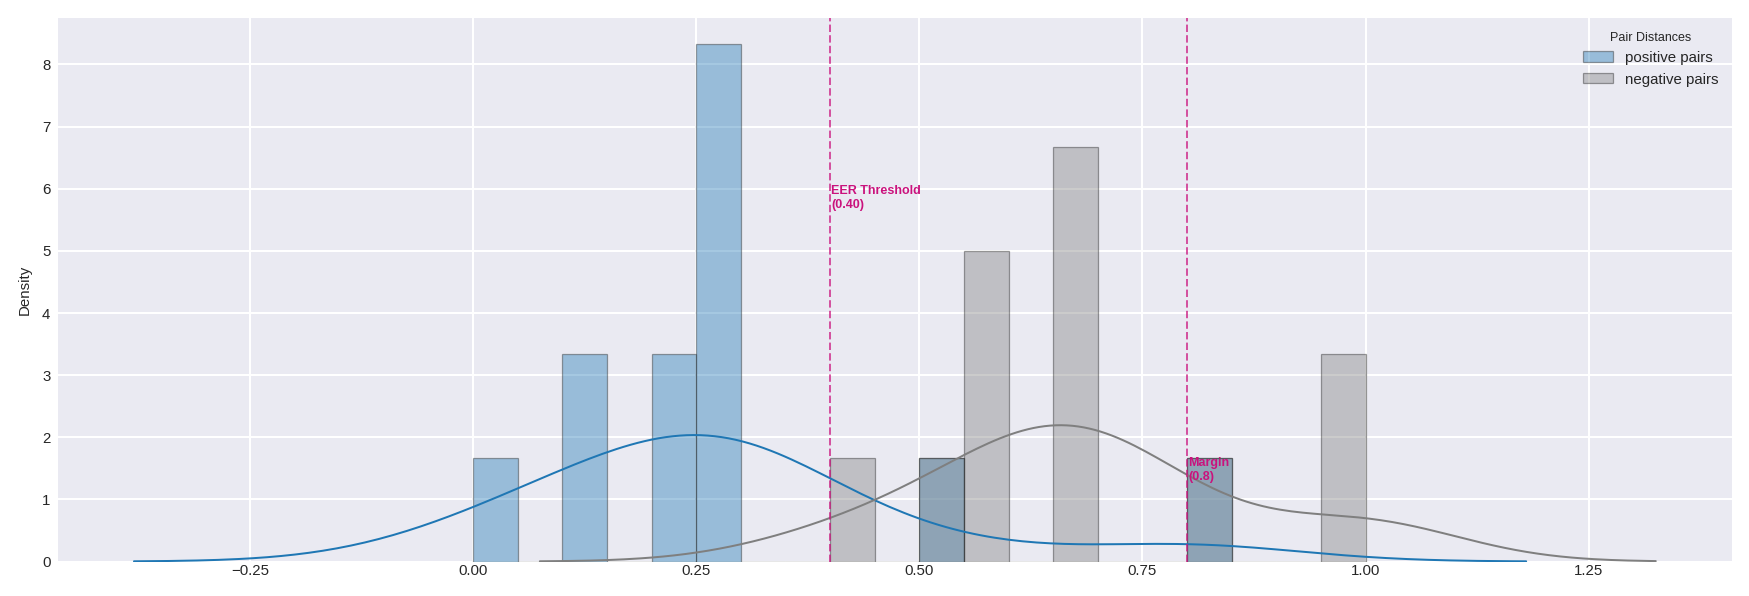

In [55]:
if TEST_MODE:
    dist_pos = np.array([0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.5, 0.8])
    dist_neg = np.array([0.4, 0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 1, 1])
    utils_plot_distance_hist(
        dist_pos, dist_neg, thres=0.4, desc="Pair", fig_size=(12, 4), margin=0.8
    )

# utils_create_cv_splits()

In [56]:
def utils_create_cv_splits(owner_key, train_dic, valid_test_dic, seed=0):
    '''
    return the required sets for an OCSVM trained on the user with key. 
    X_train: X data from train_dic[k], comes from exp2
    X_test_regular: X data from valid_test_dic[k], comes from exp1
    X_test_anomalous: X data from valid_test_dic[!k], comes from exp1
    
    Create cross-validation mask with train-valid pairs.
    
    See e.g. https://stackoverflow.com/a/37591377
    
    Arguments:
        cv_mask {np.ndarray} --
        
    Return:
        {list} -- List of tuple: (<train indices>, <valid indices>)
        
    '''
    
    if owner_key not in  train_dic:
        raise Exception("invalid key for dic")
    
        
    X_pos = train_dic[owner_key].copy()
    X_test_regular = valid_test_dic[owner_key].copy()
    X_test_anomalous = np.concatenate([valid_test_dic[key] for key in valid_test_dic.keys() if key != owner_key], axis=0).copy()
    
    train_idx_owner = np.arange(X_pos.shape[0])
    valid_idx_owner = np.arange(X_test_regular.shape[0]) + train_idx_owner.shape[0]
    
    print(f"owner: {owner_key} train_idx range: {train_idx_owner[0]}, {train_idx_owner[-1]}")
    print(f"owner: {owner_key} valid_idx range: {valid_idx_owner[0]}, {valid_idx_owner[-1]}")
    np.random.seed(seed + owner_key)
    np.random.shuffle(train_idx_owner)
    np.random.shuffle(valid_idx_owner)

    
    cv_splits = []
    base_idx = train_idx_owner.shape[0] + valid_idx_owner.shape[0]
    for key in valid_test_dic.keys():
        
        if key != owner_key:
            # Impostor validation indices
            valid_idx_impostor = np.arange(valid_test_dic[key].shape[0]) + base_idx
            print(f"imposter: {key} valid_idx range: {valid_idx_impostor[0]}, {valid_idx_impostor[-1]}")

            # Balance classes
            min_samples = min(valid_idx_owner.shape[0], valid_idx_impostor.shape[0])
            np.random.seed(seed + key)
            valid_idx_owner_samp = np.random.choice(
                valid_idx_owner, size=min_samples, replace=False
            )
            np.random.seed(seed + key)
            valid_idx_impostor_samp = np.random.choice(
                valid_idx_impostor, size=min_samples, replace=False
            )

            # Concat owner & impostor validation indices
            valid_idx_both = np.hstack([valid_idx_owner_samp, valid_idx_impostor_samp])

            # Add train/valid pair to cv
            cv_splits.append((list(train_idx_owner), list(valid_idx_both)))
            
            base_idx += valid_idx_impostor.shape[0]


    

    y_train = np.concatenate([np.repeat(1.0, X_pos.shape[0]), np.repeat(1.0, X_test_regular.shape[0]), np.repeat(-1.0, X_test_anomalous.shape[0])])
    X_train = np.concatenate([X_pos, X_test_regular, X_test_anomalous], axis=0)
    
    
    return {"X_train": X_train, "y_train": y_train, "X_test_regular": X_test_regular, "X_test_anomalous": X_test_anomalous, "cv_splits": cv_splits}

In [57]:
# if TEST_MODE:
#     # Mask Explained:
#     # -2 => Training data (owner)
#     # -1 => Validation data (owner)
#     # 0+ => Validation impostors
#     #              Indices:    0   1   2   3   4   5  6  7  8  9  10 11 12 13 14 15
#     dummy_cv_mask = np.array([-2, -2, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 2, 2, 2, -2])

#     # Generate tuples of training data and validation data, one tuple for each impostor (0, 1, 2).
#     # Training data (1st list in tuple) contains only indices of owner training data (-2)
#     # Validation data (2nd list in tuple) contains  indices of validation data from owner (-1) and
#     # from a single impostor (0+), each 50 %
#     splits = utils_create_cv_splits(dummy_cv_mask, seed=123)
#     [print(s) for s in splits]

# utils_cv_report()

In [58]:
TEST_MODE=0

In [59]:
def utils_cv_report(random_search, owner, impostors):
    """Transform the random_search.cv_results_ into nice formatted dataframe."""
    # Create report
    df_report = pd.DataFrame(random_search.cv_results_)

    # Add owner information
    df_report["owner"] = owner

    # Drop uninteressting columns
    drop_columns = [col for col in df_report.columns if "_train_" in col]
    drop_columns = drop_columns + [col for col in df_report.columns if col.startswith("split") and (col.endswith("recall") or col.endswith("precision") or col.endswith("f1") or col.endswith("roc_auc"))]
    drop_columns = drop_columns + ["params"]
    df_report = df_report.drop(columns=drop_columns)

    # Flip sign of eer (revert flip by sklearn scorer)
    eer_columns = [col for col in df_report.columns if col.endswith("_eer")]
    df_report[eer_columns] = df_report[eer_columns].abs()
    
    # Rename split result columns with impostor-ids used in split
    rename_cols = {}
    for idx, impostor in enumerate(impostors):
        print(f"idx: {idx}, impostor: {impostor}")
        to_rename_cols = [col for col in df_report.columns if col.startswith(f"split{idx}")]
        for col in to_rename_cols:
            rename_cols[col] = str(impostor)+col[len(f"split{idx}"):]
    df_report = df_report.rename(columns=rename_cols)      

    return df_report

In [60]:
if TEST_MODE:
    print("Performing Dummy RandomSearch...")
    from sklearn import svm, datasets
    from sklearn.model_selection import RandomizedSearchCV

    iris = datasets.load_iris()
    parameters = {"kernel": ("linear", "rbf"), "C": [1, 2, 3, 4, 5, 6, 7, 10]}
    svc = svm.SVC(gamma="scale")
    clf = RandomizedSearchCV(svc, parameters, cv=3, iid=False)
    clf.fit(iris.data, iris.target)
    print("Create report:")
    df_temp = utils_cv_report(clf, "owner x", ["impo_1", "impo_2", "impo_3"])
    display(df_temp)

In [61]:
def utils_plot_randomsearch_results(df_results, n_top=1):
    # Prepare data for plotting
    df_plot = df_results[df_results["rank_test_eer"] <= n_top].rename(
        columns={
            "param_model__nu": r"$\nu$",
            "param_model__gamma": r"$\gamma$",
            "mean_test_accuracy": "Mean Test Acc.",
            "mean_test_eer": "Mean Test EER",
        }
    )
    df_plot["Mean Test EER"] = df_plot["Mean Test EER"] * -1  # Because fewer is more

    median_nu = df_plot[r"$\nu$"].median()
    median_gamma = df_plot[r"$\gamma$"].median()

    # Plot
    fig = plt.figure(figsize=(5.473 / 1.3, 2), dpi=180)
    g = sns.scatterplot(
        x=r"$\nu$",
        y=r"$\gamma$",
        data=df_plot,
        size="Mean Test EER",
        sizes=(7, 60),
        hue="Mean Test EER",
        alpha=1,
        #        palette="Blues",
        linewidth=0,
    )

    # Format Legend labels
    leg = g.get_legend()
    new_handles = [h for h in leg.legendHandles]
    new_labels = []
    for i, handle in enumerate(leg.legendHandles):
        label = handle.get_label()
        print(f'{i}, {label}')
        if ord(label[0]) == 8722:
            label = '-' + label[1:]
            
        if i != 0:
            
            try:
                new_labels.append(f"{abs(float(label)):.3f}")

            except ValueError:
                new_labels.append("")

    # Plot mean values
    plt.plot(
        [-0.01, 0.31],
        [median_gamma, median_gamma],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        0.23,
        median_gamma * 1.7 ** 2,
        r"median($\gamma$)",
        fontsize=6,
        color="black",
        alpha=0.9,
    )
    plt.text(
        0.23,
        median_gamma * 1.2 ** 2,
        f"{median_gamma:.3f}",
        fontsize=5,
        color="black",
        alpha=0.9,
    )

    plt.plot(
        [median_nu, median_nu],
        [0.0001, 1000],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        median_nu + 0.005, 400, r"median($\nu$)", fontsize=6, color="black", alpha=0.9
    )
    plt.text(
        median_nu + 0.005, 200, f"{median_nu:.3f}", fontsize=5, color="black", alpha=0.9
    )

    # Adjust axes & legend
    plt.yscale("log")
    plt.ylim(0.0001, 1000)
    plt.xlim(0, 0.305)
#     print(new_handles)
    print(new_labels)
    plt.legend(
        new_handles,
        new_labels,
        bbox_to_anchor=(1.02, 1),
        loc=2,
        borderaxespad=0.0,
        title="Mean EER per Owner\n(Validation Results)",
        title_fontsize=5,
    )

    fig.tight_layout()
    return median_nu, median_gamma, fig



In [62]:
def utils_plot_2d_hyperparam_selection(h1_name, h1_val, h2_name, h2_val, df_plot):
    
    # Plot
    fig = plt.figure(figsize=(5.473 / 1.3, 2), dpi=100)
    g = sns.scatterplot(
        x=h1_name,
        y=h2_name,
        data=df_plot,
        size="Mean Test EER",
        sizes=(7, 60),
        hue="Mean Test EER",
        alpha=1,
        #        palette="Blues",
        linewidth=0,
    )

    # Format Legend labels
    leg = g.get_legend()
    new_handles = [h for h in leg.legendHandles]
    new_labels = []
    for i, handle in enumerate(leg.legendHandles):
        label = handle.get_label()
        print(f'{i}, {label}')
        if ord(label[0]) == 8722:
            label = '-' + label[1:]
            
        if i != 0:
            
            try:
                new_labels.append(f"{abs(float(label)):.3f}")

            except ValueError:
                new_labels.append("")

    # Plot mean values
    plt.plot(
        [-0.01, 0.31],
        [h2_val, h2_val],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        0.23,
        h2_val * 1.7 ** 2,
        f"median({h2_name})",
        fontsize=6,
        color="black",
        alpha=0.9,
    )
    plt.text(
        0.23,
        h2_val * 1.2 ** 2,
        f"{h2_val:.3f}",
        fontsize=5,
        color="black",
        alpha=0.9,
    )

    plt.plot(
        [h1_val, h1_val],
        [0.0001, 1000],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        h1_val + 0.005, 400, f"median({h1_name})", fontsize=6, color="black", alpha=0.9
    )
    plt.text(
        h1_val + 0.005, 200, f"{h1_val:.3f}", fontsize=5, color="black", alpha=0.9
    )

    # Adjust axes & legend
    plt.yscale("log")
    plt.ylim(0.0001, 1000)
    plt.xlim(0, 0.305)
#     print(new_handles)
    print(new_labels)
    plt.legend(
        new_handles,
        new_labels,
        bbox_to_anchor=(1.02, 1),
        loc=2,
        borderaxespad=0.0,
        title="Mean EER per Owner\n(Validation Results)",
        title_fontsize=5,
    )

    fig.tight_layout()
    
    return fig

In [63]:
# https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def arrange_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
        
    return fig

In [64]:
def utils_plot_randomsearch_results_IF(df_results, n_top=1):
    
    # Prepare data for plotting
    df_plot = df_results[df_results["rank_test_eer"] <= n_top].rename(
        columns={
                "param_model__n_estimators": "n_estimators",
                "param_model__max_samples": "max_samples",
                "param_model__contamination": "contamination",
                "param_model__max_features": "max_features",
                "mean_test_accuracy": "Mean Test Acc.",
                "mean_test_eer": "Mean Test EER",
        }
    )
    df_plot["Mean Test EER"] = df_plot["Mean Test EER"] * -1  # Because fewer is more

    print(df_plot.keys())
    median_n_estimators = df_plot["n_estimators"].median()
    median_max_samples = df_plot["max_samples"].median()
    median_contamination = df_plot["contamination"].median()
    median_max_features = df_plot["max_features"].median()

    figures = []
    figures.append(utils_plot_2d_hyperparam_selection("n_estimators", median_n_estimators, "max_samples", median_max_samples, df_plot))
    figures.append(utils_plot_2d_hyperparam_selection("n_estimators", median_n_estimators, "contamination", median_contamination, df_plot))
    figures.append(utils_plot_2d_hyperparam_selection("n_estimators", median_n_estimators, "max_features", median_max_features, df_plot))
    figures.append(utils_plot_2d_hyperparam_selection("max_samples", median_max_samples, "contamination", median_contamination, df_plot))
    figures.append(utils_plot_2d_hyperparam_selection("max_samples", median_max_samples, "max_features", median_max_features, df_plot))
    figures.append(utils_plot_2d_hyperparam_selection("contamination", median_contamination, "max_features", median_max_features, df_plot))
    
    # fig = arrange_figures(figures, nrows=3, ncols=2)
    

    return median_n_estimators, median_max_samples, median_contamination, median_max_features, None

In [65]:
def utils_plot_acc_eer_dist(df_plot, y_col):
    n_subject = len(df_plot["Owner"].unique()) - 1
    mean_col = df_plot[y_col].mean()

    fig = plt.figure(figsize=(5.473, 2), dpi=180)
    ax = sns.boxplot(x="Owner", y=y_col, data=df_plot, **utils_boxplot_style)
    ax.set_ylim((0, 1))

    plt.plot(
        [-0.6, n_subject + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=6, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=4.5, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    
    print(f"Overall mean: {mean_col:.4f}")
    return fig



# X_vals_owner_idx['X_train']
def utils_plot_acc_eer_dist_thesis(EER_distro_df, y_col, discription, save_file_name=None, boxplot_color="springgreen"):

    sns.set(err_distro_rc)
    n_subject = len(EER_distro_df['owner'].unique())+1
    mean_col = EER_distro_df[y_col].mean()
    fig = plt.figure()
    ax = sns.boxplot(x="owner", y=y_col, data=EER_distro_df, color=boxplot_color)#, **utils_boxplot_style)
    
    # Select which box you want to change    
    mybox = ax.patches[4]

    ax.set_ylim((0, 1))
    # sns.swarmplot(x="owner", y=y_col, data=EER_distro_df, color=".25")
    

    plt.plot(
        [-0.5, n_subject -1.5],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=2,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject/2, mean_col + 0.01, f"mean", fontsize=err_distro_rc["ytick.labelsize"], color=MAGENTA)
    plt.text(
        n_subject/2, mean_col - 0.04, f"{mean_col:.3f}", fontsize=err_distro_rc["ytick.labelsize"], color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.title(discription)
    
    ax.set_xlabel("owner id")
    ax.set_ylabel(f"Mean {y_col}")
    
    plt.savefig(f'{save_file_name}', bbox_inches='tight')
    print(f"Overall mean: {mean_col:.4f}")
    

In [66]:
# if TEST_MODE:
#     print("Performing Dummy RandomSearch...")
#     from sklearn import svm, datasets
#     from sklearn.model_selection import RandomizedSearchCV

#     iris = datasets.load_iris()
#     parameters = {"kernel": ("linear", "rbf"), "C": [1, 2, 3, 4, 5, 6, 7, 10]}
#     svc = svm.SVC(gamma="scale")
#     clf = RandomizedSearchCV(svc, parameters, cv=3, iid=False)
#     clf.fit(iris.data, iris.target)
#     print("Create report:")
#     df_temp = utils_cv_report(clf, "owner x", ["impo_1", "impo_2", "impo_3"])
#     display(df_temp)

In [67]:
class pca_feature_selector:
    def __init__(self, n_components):
        self._pca_dict = {}
        self.n_components = n_components
        
    def add_user_pca(self, owner_idx, user_pca):
        if owner_idx in self._pca_dict:
            raise Exception(f"owner_idx: {owner_idx} alraedy exists!")
        
        self._pca_dict[owner_idx] = user_pca
        
    def user_feature_ranking(self, owner_idx):
        '''
        these two are the same 
        np.matmul(pca.explained_variance_ratio_[np.newaxis], abs_components) == np.dot(pca.explained_variance_ratio_, abs_components)[np.newaxis]
        '''
        pca = self._pca_dict[owner_idx]
        abs_components = np.abs(pca.components_)
        feature_importance = np.dot(pca.explained_variance_ratio_, abs_components)[np.newaxis]
        top_feature_indices = np.argsort(-1*feature_importance)
        
        return {"top_feature_indices": top_feature_indices, "feature_importance": feature_importance}
    
    def get_comparison_matrix(self):
        
        feature_importance_matrix = []
        top_feature_matrix = []
        for owner_idx in self._pca_dict:
            user_feature_dict = self.user_feature_ranking(owner_idx) 
            feature_importance_matrix += [user_feature_dict["feature_importance"]]
            top_feature_matrix += [user_feature_dict["top_feature_indices"]]
            
        self._feature_importance_matrix = np.concatenate(feature_importance_matrix, axis=0)
        self._top_feature_matrix = np.concatenate(top_feature_matrix, axis=0)

        return {"feature_importance_matrix": self._feature_importance_matrix, "top_feature_matrix" :self._top_feature_matrix}
    
    def find_top_n_features(self):
        
        best_feature_lst = []
        for i in range(self.n_components):
            best_feature_lst.append(self.find_next_best_feature(best_feature_lst))
            
        return best_feature_lst
        
    def find_next_best_feature(self, curr_feature_lst):
        
        curr_pc_idx = len(curr_feature_lst)
        feature_column_count = np.bincount(self._top_feature_matrix[:, curr_pc_idx])
        print(f"top_f_m: {self._top_feature_matrix[:, curr_pc_idx]}")
        print(curr_feature_lst)
        
        i = 0
        #probably need to use a tree type or heap structure
        while i < len(feature_column_count):
            top_feature_idx = np.argmax(feature_column_count[i:]) + i
            if top_feature_idx not in curr_feature_lst:
                return top_feature_idx
            print('-------')
            print(feature_column_count)
            print(f"i: {i}, top_feature_idx: {top_feature_idx}")

            i = top_feature_idx + 1
            
        raise Exception('could not find best feature')

In [68]:
def utils_plot_training_loss(history):
    """Plot Train/Valid Loss during Epochs."""
    fig = plt.figure(figsize=(5.473, 2.7), dpi=180)
    plt.plot(history["loss"], label="train", color="tab:blue")
    plt.plot(history["val_loss"], label="valid", color=MAGENTA)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc="upper right")
    fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.tight_layout()
    return plt


In [69]:
if TEST_MODE:
    HistoryDummy = type("History", (object,), {})
    history = HistoryDummy()
    history.history = {}
    history.history["loss"] = [0.6, 0.4, 0.3, 0.2, 0.21, 0.15]
    history.history["val_loss"] = [0.9, 0.7, 0.5, 0.4, 0.35, 0.3]
    utils_plot_training_loss(history.history)

In [70]:
# randomized_data_idx = list(range(len(r)))
# random.shuffle(randomized_data_idx)
# split_idx = 2 * (len(randomized_data_idx)//3) + 1
# train_set = randomized_data_idx[: split_idx]
# test_set = randomized_data_idx[split_idx: ]
# print(f"train_set: {train_set}\ntest_set: {test_set}")

In [71]:
# # preparing train data
# # train_set = r
# dfList_exp1_train, dfList_exp2_train = [dfList_exp1[i] for i in train_set], [dfList_exp2[i] for i in train_set]
# print(f"len(dfList_exp1_train): {len(dfList_exp1_train)}")
# print(f"len(dfList_exp2_train): {len(dfList_exp2_train)}")
# XExpTrainDict = MakeXExpDic(dfList_exp1_train, dfList_exp2_train, window_size = 250, step = 251, numSamplePoints= 18000)
# X_exp1_train_dic, X_exp2_train_dic = XExpTrainDict["X_exp1_dic"], XExpTrainDict["X_exp2_dic"]

# # preparing test data
# dfList_exp1_test, dfList_exp2_test = [dfList_exp1[i] for i in test_set], [dfList_exp2[i] for i in test_set]
# print(f"len(dfList_exp1_test): {len(dfList_exp1_test)}")
# print(f"len(dfList_exp2_test): {len(dfList_exp2_test)}")
# XExpTestDict = MakeXExpDic(dfList_exp1_test, dfList_exp2_test, window_size = 250, step = 251, numSamplePoints= 18000)
# X_exp1_test_dic, X_exp2_test_dic = XExpTestDict["X_exp1_dic"], XExpTestDict["X_exp2_dic"]

**use the following to write tests for distro functions**

In [72]:
# source: https://zhiyzuo.github.io/Plot-Lorenz/
#  0 representing perfect equality, and 1 absolute inequality.
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def lorenz_curve(X):
    ## first sort
    X = X.copy()
    X.sort()
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='x', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')
    ax.set_xlabel('% of Population')
    ax.set_ylabel('% of Errors')

In [73]:
# window = 1000
# window_farDistro_array = DistroFAR(dic["window_farDistro_dict"][window], threshold = dic["window_EER_threshold_dict"][window])
# window_frrDistro_array = DistroFRR(dic["window_frrDistro_dict"][window], threshold = dic["window_EER_threshold_dict"][window])
# X = np.array(window_frrDistro_array)
# # print(X)
# print(gini(X))
# lorenz_curve(X)

In [74]:
# X = np.array(window_farDistro_array)
# # print(X)
# print(gini(X))
# lorenz_curve(X)

In [75]:
# keys_list = r
# values_list = window_frrDistro_array
# #Get pairs of elements


# zip_iterator = zip(keys_list, values_list)

# Distro_dict = dict(zip_iterator)

# Distro_dict = {k: v for k, v in sorted(Distro_dict.items(), key=lambda item: item[1])}

# fig, ax =plt.subplots(1,1, figsize=(8,8))

# ax.set_title('FRR Distrobution')
# print(Distro_dict)
# data = {"User": list(Distro_dict.keys()), "False Rejects": list(Distro_dict.values())}
# g = sns.barplot(x=data["User"], y=data["False Rejects"], order=data["User"],ax = ax)
# #y=EER_dict.values()

# # y_ticks = np.arange(0, .25 + 0.001, .05)

# # g.set_yticks(y_ticks)
# ax.axhline(np.mean(data["False Rejects"]), ls='--')
# ax.set_xlabel('User')
# ax.set_ylabel('False Rejects')

# fig.show()

In [76]:
# X = np.array(window_farDistro_array)
# # print(X)
# print(gini(X))
# lorenz_curve(X)

In [77]:
# auc(frrList, farList)

In [78]:
def getAUROCDist(window_frrList_dict, window_farList_dict, start_window_size=250, end_window_size=3000, increment_step=250):
    
    window_AUROC_dict = {}
    lst = np.arange(start_window_size, end_window_size + 1, increment_step)
    
    for w in lst:
        
        frrList = dic["window_frrList_dict"][w]
        farList = dic["window_farList_dict"][w]
        window_AUROC_dict[w] = auc(frrList, farList)
        
    return window_AUROC_dict

In [79]:
# AUROC_dict = getAUROCDist(dic["window_frrList_dict"], dic["window_farList_dict"])

In [80]:
# data = pd.read_csv('../input/wearable-assisted-ca/user10_1.docx', error_bad_lines = False, header=None, dtype = str)

In [81]:
# def extractTextFromDocx(path):
#     try:
#         doc = docx.Document(path)  # Creating word reader object.
#         data = ""
#         fullText = []
#         for para in doc.paragraphs:
#             fullText.append(para.text)
#             data = '\n'.join(fullText)

#     except IOError:
#         print('There was an error opening the file!')
#         return
#     return data

# # %% [code] {"execution":{"iopub.status.busy":"2022-03-18T18:34:19.771958Z","iopub.execute_input":"2022-03-18T18:34:19.772266Z","iopub.status.idle":"2022-03-18T18:34:19.793851Z","shell.execute_reply.started":"2022-03-18T18:34:19.772229Z","shell.execute_reply":"2022-03-18T18:34:19.792569Z"},"jupyter":{"outputs_hidden":false}}
# def numberOfWords(text):
#     return len(text.strip().split())

# def numberOfChars(text):
#     return len(text)

# def wordsPerMinute(text, mins):
#     return numberOfWords(text)/mins

# def charsPerMinute(text, mins):
#     return numberOfChars(text)/mins

# def classifyTypists(typistsSpeeds):
#     '''
#         WPM
#     Beginner	0 - 24
#     Intermediate	25 - 30
#     Average	31 - 41
#     Pro	42 - 54
#     Typemaster	55 - 79
#     Megaracer	80+
#     '''
#     exp2_typingspeeds = [29.96428571, 37.42857143, 44.89285714, 52.35714286, 59.82142857, 67.28571429]
#     speedDict = {"Beginner": 24, "Intermediate": 30, "Average": 41, "Pro": 54, "Typemaster": 79, "Megaracer": 1000}
    
#     keys = list(speedDict.keys())
#     for i in range(len(speedDict.keys())):
#         speedDict[keys[i]] = exp2_typingspeeds[i]
    
#     speedStats = {"Beginner": 0, "Intermediate": 0, "Average": 0, "Pro": 0, "Typemaster": 0, "Megaracer": 0}
#     typistsIDStats = {"Beginner": [], "Intermediate": [], "Average": [], "Pro": [], "Typemaster": [], "Megaracer": []}
    
#     for typist, speed in typistsSpeeds.items():
#         if speed <= speedDict["Beginner"]:
#             speedStats["Beginner"] += 1
#             typistsIDStats["Beginner"].append(typist)
            
#         elif speed <= speedDict["Intermediate"]:
#             speedStats["Intermediate"] += 1
#             typistsIDStats["Intermediate"].append(typist)
            
#         elif speed <= speedDict["Average"]:
#             speedStats["Average"] += 1
#             typistsIDStats["Average"].append(typist)
            
#         elif speed <= speedDict["Pro"]:
#             speedStats["Pro"] += 1
#             typistsIDStats["Pro"].append(typist)
            
#         elif speed <= speedDict["Typemaster"]:
#             speedStats["Typemaster"] += 1
#             typistsIDStats["Typemaster"].append(typist)
            
#         else:
#             speedStats["Megaracer"] += 1
#             typistsIDStats["Megaracer"].append(typist)
            
#     return {"speedStats": speedStats, "typistsIDStats": typistsIDStats}

# # %% [code] {"execution":{"iopub.status.busy":"2022-03-18T18:34:19.795159Z","iopub.execute_input":"2022-03-18T18:34:19.795733Z","iopub.status.idle":"2022-03-18T18:34:19.814022Z","shell.execute_reply.started":"2022-03-18T18:34:19.795693Z","shell.execute_reply":"2022-03-18T18:34:19.812934Z"},"jupyter":{"outputs_hidden":false}}
# r = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49]
# #r = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


# def users_typing_speed(user_ids_lst):
#     '''
#     input: 
#         user_ids_lst: list of selected user ids
#     Return {user_id: typing_speed in words per minute}
#     '''
#     typistsSpeeds = {}
#     for i in user_ids_lst:
#         user_text_data = extractTextFromDocx('../input/wearable-assisted-ca/user{0}_{1}.docx'.format(i, 2))

#         typistsSpeeds[i] = wordsPerMinute(user_text_data, 4)

In [82]:
# dic = classifyTypists(typistsSpeeds)
# dic

# Divide the users using histogram

In [83]:
# Define a style I use a lot for boxplots:
utils_boxplot_style = dict(
    color="tab:blue",
    linewidth=0.5,
    saturation=1,
    width=0.7,
    flierprops=dict(
        marker="o", markersize=2, markerfacecolor="none", markeredgewidth=0.5
    ),
)

# Define a style I use a lot for lineplots:
utils_lineplot_style = dict(
    color="tab:blue", linewidth=0.5, marker="o", markersize=3, markeredgewidth=0.5
)

In [84]:
print("utility functions imported")

utility functions imported


Loading exp1 data:


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631, gyro_count: 23835


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


44) accel_count: 24473, gyro_count: 23749
45) accel_count: 23974, gyro_count: 23229


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


46) accel_count: 23614, gyro_count: 23827
48) accel_count: 22828, gyro_count: 23904


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


49) accel_count: 24183, gyro_count: 24633
Loading exp2 data:
1) accel_count: 24049, gyro_count: 26943


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


2) accel_count: 24468, gyro_count: 27667
3) accel_count: 24611, gyro_count: 27000


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


4) accel_count: 24972, gyro_count: 26798
5) accel_count: 23573, gyro_count: 23372


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


6) accel_count: 23800, gyro_count: 23890
7) accel_count: 23347, gyro_count: 24145


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


8) accel_count: 22947, gyro_count: 22660
19) accel_count: 26156, gyro_count: 25815


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


21) accel_count: 23566, gyro_count: 24408
22) accel_count: 23844, gyro_count: 24589


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


26) accel_count: 23179, gyro_count: 23925
27) accel_count: 25109, gyro_count: 25820


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


28) accel_count: 23133, gyro_count: 24028
29) accel_count: 23180, gyro_count: 24314


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


35) accel_count: 23299, gyro_count: 23854
36) accel_count: 25497, gyro_count: 25059


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


37) accel_count: 25994, gyro_count: 25232
38) accel_count: 21164, gyro_count: 21182


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


39) accel_count: 24214, gyro_count: 23585
40) accel_count: 23944, gyro_count: 23170


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


41) accel_count: 23193, gyro_count: 24111
42) accel_count: 26505, gyro_count: 25697


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


43) accel_count: 22690, gyro_count: 23981
44) accel_count: 23002, gyro_count: 23829


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


45) accel_count: 23978, gyro_count: 23350
46) accel_count: 21128, gyro_count: 21848


/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


48) accel_count: 27996, gyro_count: 27205
49) accel_count: 23061, gyro_count: 24129


In [ ]:
# experimented with the follwoing LR scheduling functions, but ended up using from tensorflow.keras.callbacks import ReduceLROnPlateau
# commented out as it is not in use
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# def step_decay(epoch):
#     # initial_lr = 0.00001 #used for original size
#     # drop = 0.2
#     # # if epoch < 3:
#     # epochs_drop = 5# used for original size
#     # else: 
#     #     epochs_drop = 5

#     # initial_lr = 0.00003
#     # drop=1
#     # epochs_drop = 5

#     # if epoch<10:
#     #     lr = initial_lr - (initial_lr*0.1*epoch)
#     # elif epoch<20:
#     #     lr = initial_lr - (initial_lr*0.01*epoch)
#     # elif epoch<30:
#     #     lr = initial_lr - (initial_lr*0.001*epoch)
#     # else:
#     #     lr = initial_lr * drop ** (epoch // epochs_drop)
    
#     initial_lrate = 0.0001
#     k = 0.1
#     lrate = initial_lrate * exp(-k*t)
#     print(lr)
#     return lr


# def lr_time_based_decay(epoch):
#     initial_learning_rate=0.00005
#     decay = initial_learning_rate/epoch
#     return lr * 1 / (1 + decay * epoch)
    
# def lr_exp_decay(epoch, lr=0.001):
    
#     k = 0.5
#     lr = lr * math.exp(-k*epoch)
#     print(lr)
#     return lr
    
# def lr_step_based_decay(epoch, lr=.001):
#     drop_rate = 0.1
#     epochs_drop = 3
#     epochs_drop_rate=3

#     # lr = lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))
#     lr = lr * drop_rate ** (int(np.emath.logn(epochs_drop, epoch+1)))
#     print(lr)
#     return lr

# def lr_cyclic_step_based_decay(epoch, lr=0.001):
    
#     new_epoch = epoch%5
#     # initial_learning_rate=0.001 #0.0001, epoch 20 gives 10%
#     drop_rate = 0.5
#     epochs_drop = 1
#     lr = lr * math.pow(drop_rate, math.floor(new_epoch/epochs_drop))
#     print(lr)
#     return lr

# def lr_exp_decay_step_based_decay(epoch, lr=0.001):
#     initial_learning_rate=0.001
    
#     if epoch<3:
#         k = 0.3
#         lr = initial_learning_rate * math.exp(-k*epoch)
    
#     else:
#         drop_rate = 0.5
#         epochs_drop = 1
#         lr = lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))
#     print(lr)
#     return lr

# def lr_poly_scheduler(epoch, lr=0.001):
#     decay_rate = 10
#     lr=lr * (1 - epoch/50) ** decay_rate
#     print(lr)
#     return lr

# # define the learning rate scheduler callback

# def lr_schedule(epoch):
#     if epoch < 3:
#         return 0.001
#     else:
#         return 0.001 - (epoch - 2) * 0.0001
    
    
# # lr_scheduler = lr_exp_decay(lr_exp_decay)


# reduce_lr = ReduceLROnPlateau(monitor='eer_val', factor=0.01,
#                               patience=0, min_lr=0.000000001, verbose=1)

# # lr_schedule = tf.keras.experimental.CosineDecay(0.0001, 10)
# # lr_scheduler = LearningRateScheduler(lr_schedule)
# # lr_schedule(tf.range(30, dtype=tf.float32))

# x = np.arange(50)
# y = map(lr_exp_decay, x)
# sns.lineplot(x, y)

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
len(exp1_df_train_dict): 19
len(exp2_df_train_dict): 19
len(exp1_df_test_dict): 10
len(exp2_df_test_dict): 10
Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


47) accel_count: 17718, gyro_count: 18353
29
[ 1  3  5  6  7  8 11 13 16 17 19 20 21 22 24 25 26 27 28 29]
dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
train set: dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6])
validation set: dict_keys([25, 16, 1, 17, 27, 5, 29])
train set: dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6])
validation set: dict_keys([25, 16, 1, 17, 27, 5, 29])
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
len(exp1_df_user_set_dict): 10
len

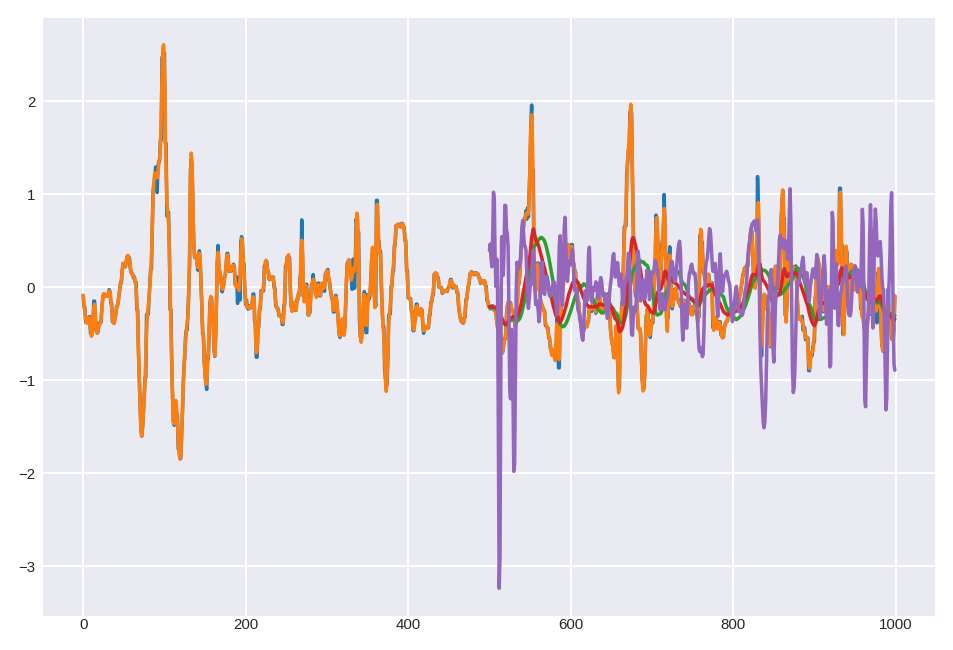

In [96]:
# This test was passed in earlier versions of the file, since we modifed prep_x_y and get_raw_windows_user_47, the test does not hold, as get_raw_windows_user_47 now takes care of the shorter
# stream length of user_47 data
if TEST_MODE:
    
#     user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49]
#     exp_begin_cutoff_idx = 500
#     exp_end_cutoff_idx = -500
#     num_sample_points_per_exp = 21000
#     df_exps_dict = load_data_frames(user_ids, exp_begin_cutoff_idx, exp_end_cutoff_idx, num_sample_points_per_exp)
#     dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']
    
#     raw_dfList_exp1 = dfList_exp1
#     raw_dfList_exp2 = dfList_exp2

    smoothing = "FFT"
    cut_off_freq=25
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    raw_dfList_exp2[0]['x_a'][0:1000].plot()
    ffted_dfList_exp2[0]['x_a'][0:1000].plot()
    # get_ffted_dfList([raw_dfList_exp2[0][raw_dfList_exp2[0].columns][500:1000]], cut_off_freq=P.cut_off_freq, filter_order=10)[0]['EMA_x_a'].plot()
    dfList_exp1 = ffted_dfList_exp1
    dfList_exp2 = ffted_dfList_exp2

    span=49
    # P.smoothing = "FFT+EMA"
    # # raw_dfList_exp1 = dfList_exp1
    # # raw_dfList_exp2 = dfList_exp2
    # P.cut_off_freq=42
    # ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
    # ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
    # ffted_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
    EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=span)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=span)
    # EMAed_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
    # dfList_exp1 = EMAed_dfList_exp1
    # dfList_exp2 = EMAed_dfList_exp2
    raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=30, min_periods=0).mean()[:].plot()
    raw_dfList_exp2[0]['x_a'][500:1000].ewm(span=30, adjust=False).mean()[:].plot()
    
    randomized_data_idx = list(range(len(user_ids)))
    random.Random(SEED).shuffle(randomized_data_idx)
    split_idx = 2 * (len(randomized_data_idx)//3) + 1
    train_set = randomized_data_idx[: split_idx]
    test_set = randomized_data_idx[split_idx: ]
    print(f"train_set: {train_set}\ntest_set: {test_set}")
    
    # preparing train data
    
    
    window_size = 500
    nn_step_width = window_size//2
    ocsvm_step_width = window_size//2
    scaler = "RobustScaler"


    # train_set = r
    exp1_df_train_dict, exp2_df_train_dict = {user_key: dfList_exp1[user_key] for user_key in train_set}, {user_key: dfList_exp2[user_key] for user_key in train_set}
    print(f"len(exp1_df_train_dict): {len(exp1_df_train_dict)}")
    print(f"len(exp2_df_train_dict): {len(exp2_df_train_dict)}")
    # Raw_X_Exp_Train_Dict = MakeRawXExpDic(exp1_df_train_dict, exp2_df_train_dict, window_size=P.window_size, step=P.nn_step_width, numSamplePoints=P.num_sample_points_per_exp, 
    #                                       scale_exp1=True, scale_exp2=True, scaler=P.scaler)
    # ---- new, realistic way
    Raw_X_Exp_Train_Dict = MakeRawXExpDict_old(exp1_df_train_dict, exp2_df_train_dict, window_size=window_size, step=nn_step_width, numSamplePoints=num_sample_points_per_exp, 
                                          scale_exp1=False, scale_exp2=True, scaler=scaler)

    fitted_scaler_SNN_exp2_train_dic = Raw_X_Exp_Train_Dict["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic, Raw_X_exp2_train_dic = Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"]

    # preparing test data
    exp1_df_test_dict, exp2_df_test_dict = {user_key: dfList_exp1[user_key] for user_key in test_set}, {user_key: dfList_exp2[user_key] for user_key in test_set}
    print(f"len(exp1_df_test_dict): {len(exp1_df_test_dict)}")
    print(f"len(exp2_df_test_dict): {len(exp2_df_test_dict)}")
    Raw_X_Exp_Test_Dict = MakeRawXExpDict_old(exp1_df_test_dict, exp2_df_test_dict, window_size=window_size, step=ocsvm_step_width, numSamplePoints=num_sample_points_per_exp, 
                                         scale_exp1=False, scale_exp2=True, scaler=scaler)

    fitted_scaler_ocsvm_exp2_dic = Raw_X_Exp_Test_Dict["fitted_scaler_exp2_dic"]
    Raw_X_exp1_test_dic, Raw_X_exp2_test_dic = Raw_X_Exp_Test_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Test_Dict["Raw_X_exp2_dic"]



    num_sample_points_per_exp_user_47 = 18000
    df_exps_dict_user_47 = load_data_frames([47], exp_begin_cutoff_idx, exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
    dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

    raw_dfList_exp1_user_47 = dfList_exp1_user_47
    raw_dfList_exp2_user_47 = dfList_exp2_user_47

    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()
    dfList_exp1_user_47 = ffted_dfList_exp1_user_47
    dfList_exp2_user_47 = ffted_dfList_exp2_user_47
    # EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
    # EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
    # EMAed_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()
    # dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
    # dfList_exp2_user_47 = EMAed_dfList_exp2_user_47
    exp1_df_dict_user_47, exp2_df_dict_user_47 = {47: dfList_exp1_user_47[0]}, {47: dfList_exp2_user_47[0]}
    Raw_X_Exp_Train_Dict_user_47 = MakeRawXExpDict_old(exp1_df_dict_user_47, exp2_df_dict_user_47, window_size=window_size, step=nn_step_width, numSamplePoints=num_sample_points_per_exp_user_47, 
                                          scale_exp1=False, scale_exp2=True, scaler=scaler)

    fitted_scaler_SNN_exp2_train_dic_user_47 = Raw_X_Exp_Train_Dict_user_47["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic_user_47, Raw_X_exp2_train_dic_user_47 = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict_user_47["Raw_X_exp2_dic"]



    user_47_idx = len(user_ids)
    print(user_47_idx)
    if user_47_idx not in train_set:
        train_set.append(user_47_idx)
    print(np.unique(train_set))
    user_47_key = user_47_idx
    Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"][user_47_key] = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp1_dic"][47]
    Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"][user_47_key] = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp2_dic"][47]
    Raw_X_Exp_Train_Dict['fitted_scaler_exp1_dic'][user_47_key] = Raw_X_Exp_Train_Dict_user_47['fitted_scaler_exp1_dic'][47]
    Raw_X_Exp_Train_Dict['fitted_scaler_exp2_dic'][user_47_key] = Raw_X_Exp_Train_Dict_user_47['fitted_scaler_exp2_dic'][47]

    print(Raw_X_Exp_Train_Dict['Raw_X_exp1_dic'].keys())
    fitted_scaler_SNN_exp2_train_dic = Raw_X_Exp_Train_Dict["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic, Raw_X_exp2_train_dic = Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"]


    spliter = 2*len(Raw_X_exp2_train_dic)//3
    cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[:spliter]}
    cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[:spliter]}
    cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[spliter:]}
    cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[spliter:]}


    print(f"train set: {cnn_train_exp2.keys()}\nvalidation set: {cnn_valid_exp2.keys()}")
    print(f"train set: {cnn_train_exp1.keys()}\nvalidation set: {cnn_valid_exp1.keys()}")


    X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict=get_raw_windows_3(dfList_exp1, dfList_exp2, window_size, nn_step_width, train_set[:-1], 
                                                                        scaler, num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

    X_exp1_dict_user_47, X_exp2_dict_user_47, fitted_scaler_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, nn_step_width, 
                                                                                                      scaler=scaler, num_sample_points_per_exp=18000, 
                                                                                                      EMA_per_win_span=None, SMA_per_win_winsize=None)

    X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict=append_user_47_to_data(X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict, user_ids, X_exp1_dict_user_47, X_exp2_dict_user_47, 
                                                                             fitted_scaler_exp2_dict_user_47, verbose=1)

    
    
    # preparing test data
    X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows_3(dfList_exp1, dfList_exp2, window_size, ocsvm_step_width, test_set, 
                                                                        scaler, num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

    assert fitted_scaler_SNN_exp2_train_dic.keys()==fitted_scaler_exp2_dict.keys()
    assert Raw_X_exp2_train_dic.keys()==X_exp1_dict.keys()
    assert Raw_X_exp1_train_dic.keys()==X_exp2_dict.keys()
    for user_key in Raw_X_exp2_train_dic:
        print(f"verifying user_key: {user_key}")
        for df_idx in range(len(Raw_X_exp2_train_dic[user_key])):
            try:
                assert_frame_equal(Raw_X_exp1_train_dic[user_key][df_idx], X_exp1_dict[user_key][df_idx])
                assert_frame_equal(Raw_X_exp2_train_dic[user_key][df_idx], X_exp2_dict[user_key][df_idx])
            except:
                print(f"user_key: {user_key}, df_idx: {df_idx}")
    # assert Raw_X_exp1_train_dic[1]==X_exp2_dict[1]
    print("no err train dicts")
    
    assert fitted_scaler_ocsvm_exp2_dic.keys()==fitted_scaler_test_exp2_dict.keys()
    assert Raw_X_exp2_test_dic.keys()==X_test_exp1_dict.keys()
    assert Raw_X_exp1_test_dic.keys()==X_test_exp2_dict.keys()
    for user_key in Raw_X_exp2_test_dic:
        print(f"verifying user_key: {user_key}")
        for df_idx in range(len(Raw_X_exp2_test_dic[user_key])):
            try:
                assert_frame_equal(Raw_X_exp1_test_dic[user_key][df_idx], X_test_exp1_dict[user_key][df_idx])
                assert_frame_equal(Raw_X_exp2_test_dic[user_key][df_idx], X_test_exp2_dict[user_key][df_idx])
            except:
                print(f"user_key: {user_key}, df_idx: {df_idx}")
    # assert Raw_X_exp1_train_dic[1]==X_exp2_dict[1]
    print("no err test dicts")